In [1]:
import pandas as pd
from pandas.io import sql
from time import time
import MySQLdb
import numpy as np
import sklearn as sk
import sklearn.ensemble
from sklearn.experimental import enable_hist_gradient_boosting
import pyltr
import math, random
import pprint
import xgboost as xgb
from tqdm import tqdm 
from sklearn.datasets import make_classification, load_svmlight_file
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, RFECV, mutual_info_regression, SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold, train_test_split, GroupShuffleSplit, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from heatmap import heatmap, corrplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from scipy.stats import uniform, randint

## Exploratory data analysis

In [2]:
con1 = MySQLdb.connect('localhost', 'root', 'root', 'DMT')

Train_df = pd.read_sql("SELECT * FROM TrainSearch;", con = con1, index_col = 'row_num')

con1.close()

In [3]:
con2 = MySQLdb.connect('localhost', 'root', 'root', 'DMT')

Test_df = pd.read_sql("SELECT * FROM TestSearch;", con = con2, index_col = 'row_num')

con2.close()

In [247]:
Train_df.shape

(4958347, 54)

In [246]:
Test_df.shape

(4959183, 50)

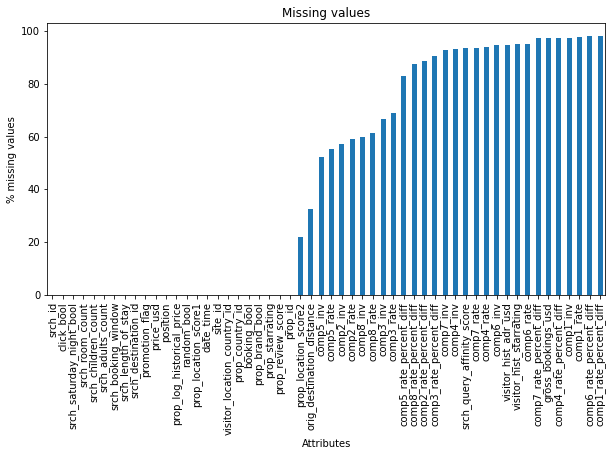

In [751]:
#Percentage of missing values sorted
Missing_Values=Train_df.isna().sum()
Percentage_Missing_Values=Missing_Values*100/len(Train_df)
Percentage_Missing_Values.sort_values(ascending=True).plot.bar(figsize=(10,5))
plt.ylabel('% missing values')
plt.xlabel('Attributes')
plt.title('Missing values')
plt.show()

In [ ]:
#Correlation Plot
plt.figure(figsize=(15,9))
corrplot(Train_df.corr(),size_scale=85)

In [ ]:
tot_books = Train_df['booking_bool'].sum()
tot_clicks = Train_df['click_bool'].sum()

# Dealing with NaNs

## Hotel descriptors(scores)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,4),dpi=200)
axs[0].set_ylabel('% of Hotels clicked or booked')
na = [100*Train_df[Train_df['prop_location_score2'].isnull()]['booking_bool'].sum()/Train_df['booking_bool'].sum(), 
      100*Train_df[Train_df['srch_query_affinity_score'].isnull()]['booking_bool'].sum()/Train_df['booking_bool'].sum()]

not_na = [100*Train_df[Train_df['prop_location_score2'].notnull()]['booking_bool'].sum()/Train_df['booking_bool'].sum(), 
         100*Train_df[Train_df['srch_query_affinity_score'].notnull()]['booking_bool'].sum()/Train_df['booking_bool'].sum()]

index = ['prop_location_score2', 'srch_query_affinity_score']
df1 = pd.DataFrame({'NA': na, 'Not NA': not_na}, index=index)
df1.plot.bar(ax=axs[0], rot=0, color={"NA": "red", "Not NA": "blue"}, title='bookings')

na = [100*Train_df[Train_df['prop_location_score2'].isnull()]['click_bool'].sum()/Train_df['click_bool'].sum(), 
      100*Train_df[Train_df['srch_query_affinity_score'].isnull()]['click_bool'].sum()/Train_df['click_bool'].sum()]

not_na = [100*Train_df[Train_df['prop_location_score2'].notnull()]['click_bool'].sum()/Train_df['click_bool'].sum(), 
         100*Train_df[Train_df['srch_query_affinity_score'].notnull()]['click_bool'].sum()/Train_df['click_bool'].sum()]

df2 = pd.DataFrame({'NA': na, 'Not NA': not_na}, index=index)
df2.plot.bar(ax=axs[1],rot=0, color={"NA": "red", "Not NA": "blue"},title='clicks')
plt.tight_layout()

## Discussion:
1. We observe that most of clicks/bookings are when the prop_location_score2 area available, which is more likely in the real world also where prople often dont tend to click/book hotels without a location score. So we choose to fill these missing values with the minimum possible score, which is 0.

2. Here we observe that most of clicks/books are for the null values. This means most of the clicks/bookings came when the property was not registered in any searches, so we choose to fill them with the best possible values which is 0 . (since this attribute is log of probablility, therefore $\log 1 =0$ ) 

SC- should't you also compare this for non-bookings to conclude the above?

## User's Historical data

In [ ]:
temp = Train_df.copy()

In [ ]:
#temp = Train_df[Train_df['visitor_hist_starrating'].notnull()]
fig, axs = plt.subplots(figsize=(10,4),dpi=200)
temp['starrating_diff'] = abs(temp['visitor_hist_starrating']-temp['prop_starrating'])
#temp['usd_diff'] = abs(temp['visitor_hist_adr_usd']-temp['price_usd'])

#temp[(temp['starrating_diff']<=1)& (temp['starrating_diff']>=0)]['booking_bool'].sum()

absDiff1 = [100*temp[(temp['starrating_diff']>=0)& (temp['starrating_diff']<=1)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['starrating_diff']>=0)& (temp['starrating_diff']<=1)]['click_bool'].sum()/tot_clicks]

absDiff2 = [100*temp[(temp['starrating_diff']>1)& (temp['starrating_diff']<=2)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['starrating_diff']>1)& (temp['starrating_diff']<=2)]['click_bool'].sum()/tot_clicks]

absDiff3 = [100*temp[(temp['starrating_diff']>2)& (temp['starrating_diff']<=3)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['starrating_diff']>2)& (temp['starrating_diff']<=3)]['click_bool'].sum()/tot_clicks]

absDiff4 = [100*temp[(temp['starrating_diff']>3)& (temp['starrating_diff']<=4)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['starrating_diff']>3)& (temp['starrating_diff']<=4)]['click_bool'].sum()/tot_clicks]

absDiff5 = [100*temp[(temp['starrating_diff']>4)& (temp['starrating_diff']<=5)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['starrating_diff']>4)& (temp['starrating_diff']<=5)]['click_bool'].sum()/tot_clicks]

TheNas =  [100*temp[temp['starrating_diff'].isnull()]['booking_bool'].sum()/tot_books,
          100*temp[temp['starrating_diff'].isnull()]['click_bool'].sum()/tot_clicks]

index = ['bookings','clicks']
df3 = pd.DataFrame({'0<=abs(diff)<=1': absDiff1, '1<abs(diff)<=2': absDiff2, '2<abs(diff)<=3': absDiff3, 
                   '3<abs(diff)<=4': absDiff4, '4<abs(diff)<=5': absDiff5, 'NA': TheNas}, index=index)
df3.plot.bar(ax=axs, rot=0, color={'0<=abs(diff)<=1': "navy", '1<abs(diff)<=2': "red", '2<abs(diff)<=3':"lime",
                          '3<abs(diff)<=4':"yellow", '4<abs(diff)<=5': "black", 'NA':"aqua" }, 
             title='Effect of historical star ratings'+'\n'+'diff $=$ visitor_hist_starrating $-$ prop_starrating')
axs.set_ylabel('Percentage of Hotels clicked or booked')
plt.show()

In [ ]:
df3

In [ ]:
temp['usd_diff'] = abs(temp['visitor_hist_adr_usd']-temp['price_usd'])

In [ ]:
q25, q50, q75 = temp['usd_diff'].quantile(0.25), temp['usd_diff'].quantile(0.5), temp['usd_diff'].quantile(0.75)

absDiff25 = [100*temp[(temp['usd_diff']>=0)& (temp['usd_diff']<=q25)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['usd_diff']>=0)& (temp['usd_diff']<=q25)]['click_bool'].sum()/tot_clicks]

absDiff50 = [100*temp[(temp['usd_diff']>q25)& (temp['usd_diff']<=q50)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['usd_diff']>q25)& (temp['usd_diff']<=q50)]['click_bool'].sum()/tot_clicks]

absDiff75 = [100*temp[(temp['usd_diff']>q50)& (temp['usd_diff']<=q75)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['usd_diff']>q50)& (temp['usd_diff']<=q75)]['click_bool'].sum()/tot_clicks]

absDiffRest = [100*temp[(temp['usd_diff']>q75)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['usd_diff']>q75)]['click_bool'].sum()/tot_clicks]

Nas =  [100*temp[temp['usd_diff'].isnull()]['booking_bool'].sum()/tot_books,
          100*temp[temp['usd_diff'].isnull()]['click_bool'].sum()/tot_clicks]

index = ['bookings','clicks']
df4 = pd.DataFrame({'0<=abs(diff)<=q25': absDiff25, 'q25<abs(diff)<=q50': absDiff50, 'q50<abs(diff)<=q75': absDiff75, 
                   'q75<abs(diff)': absDiffRest, 'NA': Nas}, index=index)

fig, axs = plt.subplots(figsize=(10,4),dpi=200)
df4.plot.bar(ax=axs, rot=0, color={'0<=abs(diff)<=q25': "navy", 'q25<abs(diff)<=q50': "red", 'q50<abs(diff)<=q75':"lime",
                          'q75<abs(diff)':"yellow", 'NA':"aqua" }, 
             title='Effect of users historical purchases'+'\n'+'diff $=$ visitor_hist_adr_usd $-$ price_usd')
axs.set_ylabel('Percentage of Hotels clicked or booked')
plt.show()

In [ ]:
df4

## Discussion
We observe that for both the above attributes maximum clicks/bookings ($>95\%$) occured when the data was not present or when data were quite close to the user's historical behaviour.(abs diff within $0,1$ for starrating and absolute difference within 1st $25\%$ quantile for price of hotels previously purchased). So it is safe to impute the missing values for the absolute differences as 0.   

## Static hotel properties

In [ ]:
100*temp[temp['orig_destination_distance'].isnull()]['click_bool'].sum()/tot_clicks

In [ ]:
100*temp[temp['orig_destination_distance'].isnull()]['booking_bool'].sum()/tot_books

## Discussion

Again most clicks/bookings are when this attribute is not-null. We dont include this in our model because including physical distance between the hotel and the customer at the time of search seems less intutive. We may include this after some preliminary optimizations. 

## Comptetior data

In [ ]:
plt.rc('legend',fontsize='x-small')

In [ ]:
#fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(5,15),dpi=200)
index = ['bookings','clicks']

for i in range(1,9):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,2),dpi=200)
    minima = temp['comp{}_rate_percent_diff'.format(i)].min()
    #std = temp['comp{}_rate_percent_diff'.format(i)].std()
    q25 = temp['comp{}_rate_percent_diff'.format(i)].quantile(0.25) 
    q50 = temp['comp{}_rate_percent_diff'.format(i)].quantile(0.5) 
    q75 = temp['comp{}_rate_percent_diff'.format(i)].quantile(0.75)
    
    diff25 = [100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>=minima)& (temp['comp{}_rate_percent_diff'.format(i)]<=q25)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>=minima)& (temp['comp{}_rate_percent_diff'.format(i)]<=q25)]['click_bool'].sum()/tot_clicks]
    
    diff50 = [100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q25)& (temp['comp{}_rate_percent_diff'.format(i)]<=q50)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q25)& (temp['comp{}_rate_percent_diff'.format(i)]<=q50)]['click_bool'].sum()/tot_clicks]

    diff75 = [100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q50)& (temp['comp{}_rate_percent_diff'.format(i)]<=q75)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q50)& (temp['comp{}_rate_percent_diff'.format(i)]<=q75)]['click_bool'].sum()/tot_clicks]

    diffRest = [100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q75)]['booking_bool'].sum()/tot_books,
           100*temp[(temp['comp{}_rate_percent_diff'.format(i)]>q75)]['click_bool'].sum()/tot_clicks]
    
    Nas =  [100*temp[temp['comp{}_rate_percent_diff'.format(i)].isnull()]['booking_bool'].sum()/tot_books,
          100*temp[temp['comp{}_rate_percent_diff'.format(i)].isnull()]['click_bool'].sum()/tot_clicks]
    
    df1 = pd.DataFrame({'min<=abs(diff)<=q25': diff25, 'q25<abs(diff)<=q50': diff50, 'q50<abs(diff)<=q75': diff75, 
                   'q75<abs(diff)': diffRest, 'NA': Nas}, index=index)

    df1.plot.bar(ax=axs[0], rot=0, color={'min<=abs(diff)<=q25': "navy", 'q25<abs(diff)<=q50': "red", 
                                           'q50<abs(diff)<=q75':"lime", 'q75<abs(diff)':"yellow", 'NA':"aqua" }, 
             title='comp{}_rate_percent_diff'.format(i),stacked=True)
    
    axs[0].set_ylabel('% of Hotels clicked or booked',fontsize='small')
    
    rateLow =  [100*temp[temp['comp{}_rate'.format(i)]==1]['booking_bool'].sum()/tot_books, 
                100*temp[temp['comp{}_rate'.format(i)]==1]['click_bool'].sum()/tot_clicks]
    rateSame =  [100*temp[temp['comp{}_rate'.format(i)]==0]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_rate'.format(i)]==0]['click_bool'].sum()/tot_clicks]
    rateHigh =  [100*temp[temp['comp{}_rate'.format(i)]==-1]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_rate'.format(i)]==-1]['click_bool'].sum()/tot_clicks]
    rateNA =  [100*temp[temp['comp{}_rate'.format(i)].isnull()]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_rate'.format(i)].isnull()]['click_bool'].sum()/tot_clicks]
    
    df2 = pd.DataFrame({'ExpLow':rateLow, 'Same':rateSame, 'ExpHigh':rateHigh,'NA':rateNA}, index=index)
    df2.plot.bar(ax=axs[1], rot=0 , color={'ExpLow': "navy", 'Same': "red",'ExpHigh':"yellow", 'NA':"aqua" },
                title='comp{}_rate'.format(i),stacked=True)
  
    NoAvl =  [100*temp[temp['comp{}_inv'.format(i)]==1]['booking_bool'].sum()/tot_books, 
                100*temp[temp['comp{}_inv'.format(i)]==1]['click_bool'].sum()/tot_clicks]
    SameAvl =  [100*temp[temp['comp{}_inv'.format(i)]==0]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_inv'.format(i)]==0]['click_bool'].sum()/tot_clicks]
    IDK =  [100*temp[temp['comp{}_inv'.format(i)]==-1]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_inv'.format(i)]==-1]['click_bool'].sum()/tot_clicks]
    AvlNA =  [100*temp[temp['comp{}_inv'.format(i)].isnull()]['booking_bool'].sum()/tot_books,
                100*temp[temp['comp{}_inv'.format(i)].isnull()]['click_bool'].sum()/tot_clicks]
    
    df3 = pd.DataFrame({'CompNotAvail':NoAvl, 'Same':SameAvl, '(-1)NotKnown':IDK,'NA':AvlNA}, index=index)
    df3.plot.bar(ax=axs[2], rot=0 , color={'CompNotAvail': "navy", 'Same': "red",'(-1)NotKnown':"yellow", 'NA':"aqua" },
                title='comp{}_inv'.format(i),stacked=True)
     
    plt.tight_layout()
    plt.show()
    #display(df1);display(df2);display(df3)

## Discussion: 
For each of the $i$ competitors, $ i \in [1,2,\cdots 8]$
1. *comp{i}_rate*- It is evident that most of the clicks and books($>90\%$) come from fields where the rates are either **Same** or not available,i.e. **NULL**. If the clicks/bookings were (say) more for lower expedia prices or less for higher expedia prices, then we could have said that this attribute is significant while clicking/booking a hotel. Therefore it is reasonable to assume that this attribute is not significant.  

2. *comp{i}_inv* - We again observe that most of the clicks/bookings come from fields where the availabilities are either **Same** or not available,i.e. **NULL**. By the above argument, we can say that this attribute may not be significant.    

3. *comp{i}_rate_percent_diff* - Here, we observe that around $90\%$ of clicks/bookings come when the rate percentage differences are either **NULL** or within the first $25\%$ quantile. This means that adding the clicks/bookings for fields where values are **NULL** or rate percentage differences are quite small, accounts for most of the clicks/bookings. So, we can say this attribute is not signficant.   

SC- should't you also compare this for non-bookings to conclude the above?

## Now load the data and preprocess

In [4]:
default_cols = [
'prop_starrating',            
'prop_review_score',          
'prop_brand_bool',            
'prop_location_score1',       
'prop_location_score2',       
'prop_log_historical_price',  
'price_usd',                  
'promotion_flag',                    
'srch_length_of_stay',        
'srch_booking_window',
'srch_adults_count',          
'srch_children_count',        
'srch_room_count',                  
'srch_saturday_night_bool',        
'orig_destination_distance',          
'random_bool']  

In [123]:
train_df = Train_df.copy()

In [6]:
test_df = Test_df.copy()

In [5]:
train_df.isna().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                    0
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

In [124]:
# NaCols = train_df.columns[train_df.isna().any()].tolist()
# train_df['visitor_hist_starrating']=train_df[['srch_id', 'visitor_hist_starrating']].groupby('srch_id').mean()
# train_df[['prop_country_id'] + NaCols].groupby('prop_country_id').quantile(0.25)
# train_df[['prop_country_id', 'orig_destination_distance']].groupby('prop_country_id').quantile(0.5).isna().sum()
for col in ['orig_destination_distance','prop_location_score2']:
    train_df[col] = train_df[['prop_country_id'] + [col]].groupby('prop_country_id')[col].transform(lambda x: x.fillna(x.quantile(0.25)))

In [8]:
for col in ['orig_destination_distance','prop_location_score2']:
    test_df[col] = test_df[['prop_country_id'] + [col]].groupby('prop_country_id')[col].transform(lambda x: x.fillna(x.quantile(0.25)))

In [7]:
train_df.isna().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                    0
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2                 2
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

In [125]:
train_df.fillna(value = 0, inplace = True)

In [10]:
test_df.fillna(value = 0, inplace = True)

<AxesSubplot:>

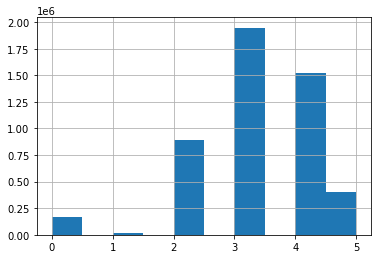

In [9]:
train_df['prop_starrating'].hist()

In [126]:
quantile_list = [0, .33, .67, 1.]

quantile_labels = ['0-33Q', '33-67Q', '67-100Q']

train_df['Propstarrating_quantile_label'] = pd.qcut(train_df['prop_starrating'], q=quantile_list, labels=quantile_labels)                   

In [12]:
quantile_list = [0, .33, .67, 1.]

quantile_labels = ['0-33Q', '33-67Q', '67-100Q']

test_df['Propstarrating_quantile_label'] = pd.qcut(test_df['prop_starrating'], q=quantile_list, labels=quantile_labels)   

<AxesSubplot:>

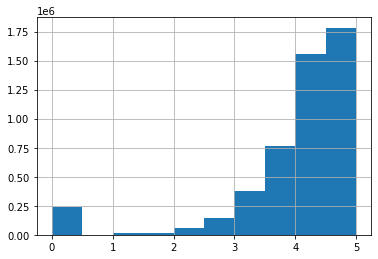

In [13]:
train_df['prop_review_score'].hist()

In [127]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Proprevscore_quantile_label'] = pd.qcut(train_df['prop_review_score'], q=quantile_list, labels=quantile_labels) 

In [15]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Proprevscore_quantile_label'] = pd.qcut(test_df['prop_review_score'], q=quantile_list, labels=quantile_labels) 

<AxesSubplot:>

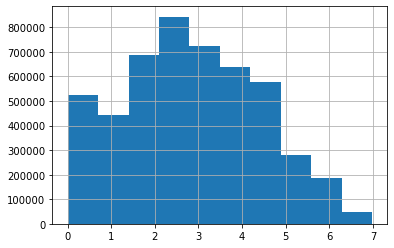

In [16]:
train_df['prop_location_score1'].hist()

In [128]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Proplocscore1_quantile_label'] = pd.qcut(train_df['prop_location_score1'], q=quantile_list, labels=quantile_labels) 

In [18]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Proplocscore1_quantile_label'] = pd.qcut(test_df['prop_location_score1'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

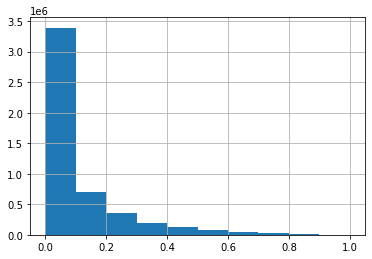

In [19]:
train_df['prop_location_score2'].hist()

In [129]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Proplocscore2_quantile_label'] = pd.qcut(train_df['prop_location_score2'], q=quantile_list, labels=quantile_labels)

In [21]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Proplocscore2_quantile_label'] = pd.qcut(test_df['prop_location_score2'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

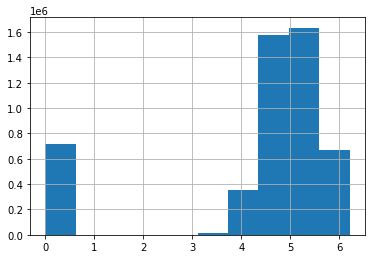

In [22]:
train_df['prop_log_historical_price'].hist()

In [130]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Proploghistprice_quantile_label'] = pd.qcut(train_df['prop_log_historical_price'], q=quantile_list, labels=quantile_labels)

In [24]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Proploghistprice_quantile_label'] = pd.qcut(test_df['prop_log_historical_price'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

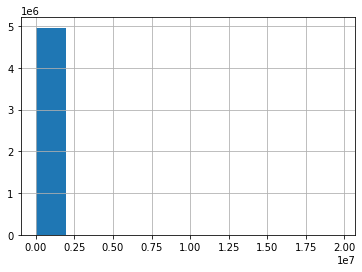

In [25]:
train_df['price_usd'].hist()

In [131]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Priceusd_quantile_label'] = pd.qcut(train_df['price_usd'], q=quantile_list, labels=quantile_labels)

In [27]:
quantile_list = [0, .25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Priceusd_quantile_label'] = pd.qcut(test_df['price_usd'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

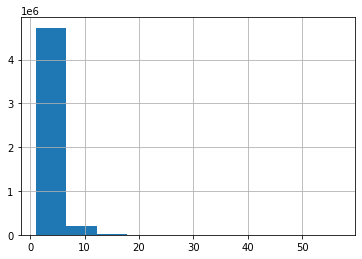

In [28]:
train_df['srch_length_of_stay'].hist()

In [132]:
quantile_list = [0, .5, 1.]

quantile_labels = ['0-50Q', '50-100Q']

train_df['Srchlenofstay_quantile_label'] = pd.qcut(train_df['srch_length_of_stay'], q=quantile_list, labels=quantile_labels)

In [30]:
quantile_list = [0, .5, 1.]

quantile_labels = ['0-50Q', '50-100Q']

test_df['Srchlenofstay_quantile_label'] = pd.qcut(test_df['srch_length_of_stay'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

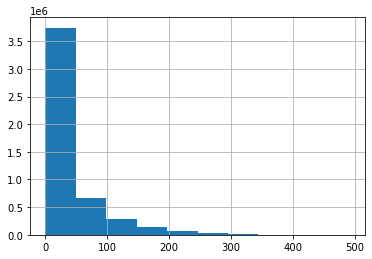

In [31]:
train_df['srch_booking_window'].hist()

In [133]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Srchbookwindow_quantile_label'] = pd.qcut(train_df['srch_booking_window'], q=quantile_list, labels=quantile_labels)

In [33]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Srchbookwindow_quantile_label'] = pd.qcut(test_df['srch_booking_window'], q=quantile_list, labels=quantile_labels)

In [134]:
train_df['price_per_person'] = (train_df['price_usd']*train_df['srch_room_count'])/(train_df['srch_children_count']+train_df['srch_adults_count'])

In [35]:
test_df['price_per_person'] = (test_df['price_usd']*test_df['srch_room_count'])/(test_df['srch_children_count']+test_df['srch_adults_count'])

<AxesSubplot:>

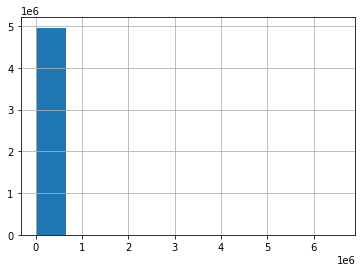

In [36]:
train_df['price_per_person'].hist()

In [135]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Priceperperson_quantile_label'] = pd.qcut(train_df['price_per_person'], q=quantile_list, labels=quantile_labels)

In [38]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Priceperperson_quantile_label'] = pd.qcut(test_df['price_per_person'], q=quantile_list, labels=quantile_labels)

<AxesSubplot:>

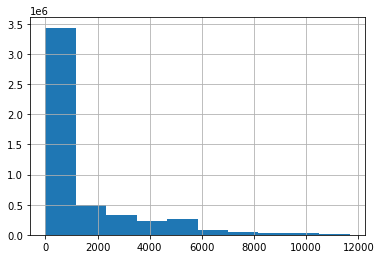

In [39]:
train_df['orig_destination_distance'].hist()

In [136]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

train_df['Origdestdist_quantile_label'] = pd.qcut(train_df['orig_destination_distance'], q=quantile_list, labels=quantile_labels)

In [41]:
quantile_list = [0,.25, .5, .75, 1.]

quantile_labels = ['0-25Q', '25-50Q','50-75Q' ,'75-100Q']

test_df['Origdestdist_quantile_label'] = pd.qcut(test_df['orig_destination_distance'], q=quantile_list, labels=quantile_labels)

In [112]:
train_df.shape

(4958347, 65)

In [138]:
'''xd = pd.DataFrame({'srch_id':[1,2,3,3,3,5,5,5],'target':[2,5,0,1,0,1,0,0]})
display(xd)

emp = pd.DataFrame()
for i in xd[xd['b']==1]['a'].unique():
    print(i)
    temp1 = xd[(xd['a']==i) & (xd['b']==0)].groupby("a").sample(n=1)
    temp2 = xd[(xd['a']==i) & (xd['b']==1)]
    emp = pd.concat([emp,temp1,temp2])
emp'''

train_inds, valid_inds = next(GroupShuffleSplit(train_size=0.9, n_splits=2).split(train_df, groups=train_df['srch_id']))
train, valid = train_df.iloc[train_inds], train_df.iloc[valid_inds]
print(train.shape)
print(valid.shape)

(4463208, 65)
(495139, 65)


In [139]:
def balancer(df, points=1):
    df2 = df[df['booking_bool']==1]
    srch_idlist = df[df['booking_bool']==1]['srch_id'].unique().tolist()
    df3 = df.loc[df['srch_id'].isin(srch_idlist)]
    df4 = df3[df3['booking_bool'] == 0]
    return pd.concat([df4.groupby("srch_id").sample(n=points),df2]).sort_values(by=['srch_id']).reset_index(drop=True)

In [140]:
tic = time()
balanced_train = balancer(train)
toc = time()
print('Elapsed time {:.2f} secs'.format(toc-tic))

Elapsed time 560.13 secs


In [244]:
tic = time()
balanced_train2 = balancer(train, points=5)
toc = time()
print('Elapsed time {:.2f} secs'.format(toc-tic))

ValueError: Cannot take a larger sample than population when 'replace=False'

In [142]:
balanced_train['booking_bool'].value_counts()

0    124458
1    124458
Name: booking_bool, dtype: int64

In [143]:
balanced_train2['booking_bool'].value_counts()

0    373374
1    124458
Name: booking_bool, dtype: int64

In [144]:
bal_train = balanced_train.loc[(balanced_train['price_usd'] <= 2000.0) & (balanced_train['price_usd'] != 0.0)]
bal_train['booking_bool'].value_counts()

1    124355
0    124324
Name: booking_bool, dtype: int64

In [145]:
'''
print(bal_train.shape)
bal_train[['booking_bool']].value_counts()
'''
bal_train2 = balanced_train2.loc[(balanced_train2['price_usd'] <= 2000.0) & (balanced_train2['price_usd'] != 0.0)]
bal_train2['booking_bool'].value_counts()

0    372964
1    124355
Name: booking_bool, dtype: int64

In [146]:
'''
'Propstarrating_quantile_label'
'Proprevscore_quantile_label'
'Proplocscore1_quantile_label'
'Proplocscore2_quantile_label'
'Proploghistprice_quantile_label'
'Priceusd_quantile_label'
'Srchlenofstay_quantile_label'
'Srchbookwindow_quantile_label'
'Priceperperson_quantile_label'
'Origdestdist_quantile_label'
'''
def transform(df, attribute, label_attribute):
    assert isinstance(attribute, str), 'Attribute name should be string type!'
    assert isinstance(label_attribute, str), 'Attribute name should be string type!'
    
    label_string = label_attribute.split("_")[0]
    le = LabelEncoder()
    labels = le.fit_transform(df[attribute])
    df[label_attribute] = labels
    
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[label_attribute]]).toarray()
    feature_labels = [label_string + str(cls_label) for cls_label in le.classes_]
    features = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features 

def encoder(df):
    f1 = transform(df,'Propstarrating_quantile_label','propstar_label' )    
    f2 = transform(df,'Proprevscore_quantile_label','rev_labels')
    f3 = transform(df,'Proplocscore1_quantile_label','1scor_labels')
    f4 = transform(df,'Proplocscore2_quantile_label','2scor_labels')
    f5 = transform(df, 'Proploghistprice_quantile_label', 'loghist_labels')
    f6 = transform(df, 'Priceusd_quantile_label', 'priceusd_labels')
    f7 = transform(df,'Srchlenofstay_quantile_label','lenofstay_labels')
    f8 = transform(df, 'Srchbookwindow_quantile_label', 'bookwin_labels')
    f9 = transform(df, 'Priceperperson_quantile_label', 'priceper_labels')
    f10 = transform(df, 'Origdestdist_quantile_label', 'destdist_labels')
    df.reset_index(drop=True,inplace=True)
    df_ohe = pd.concat([df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10], axis=1)
    
    return df_ohe

In [126]:
'''balanced_train.drop(columns=['propstar_label','rev_labels','scor1_labels','scor2_labels','loghist_labels',
                            'priceusd_labels','lenofstay_labels','bookwin_labels','priceper_labels','destdist_labels'], 
                    inplace=True)'''

In [147]:
#bal_train_ohe = pd.concat([bal_train,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10], axis=1)
bal_train_ohe = encoder(bal_train)
bal_train_ohe2 = encoder(bal_train2)

<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_attribute] = labels
<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_attribute] = labels
<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [148]:
bal_train_ohe.head(2)

srch_id           date_time  site_id  visitor_location_country_id  \
0        1 2013-04-04 08:32:15       12                          187   
1        1 2013-04-04 08:32:15       12                          187   

   visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  prop_id  \
0                      0.0                   0.0              219    56880   
1                      0.0                   0.0              219    68914   

   prop_starrating  prop_review_score  ...  bookwin50-75Q  bookwin75-100Q  \
0                4                4.0  ...            0.0             0.0   
1                2                3.0  ...            0.0             0.0   

   priceper0-25Q  priceper25-50Q  priceper50-75Q  priceper75-100Q  \
0            0.0             0.0             1.0              0.0   
1            1.0             0.0             0.0              0.0   

   destdist0-25Q  destdist25-50Q  destdist50-75Q  destdist75-100Q  
0            1.0             0.0             0.0              0.0  
1            1.0             0.0             0.0              0.0  

[2 rows x 112 columns]

In [149]:
valid_ohe = encoder(valid)

<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_attribute] = labels
<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_attribute] = labels
<ipython-input-146-d5a4362ec1b2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [150]:
valid_ohe.head(2)

srch_id           date_time  site_id  visitor_location_country_id  \
0        4 2012-12-31 08:59:22        5                          219   
1        4 2012-12-31 08:59:22        5                          219   

   visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  prop_id  \
0                      0.0                   0.0              219     3625   
1                      0.0                   0.0              219    11622   

   prop_starrating  prop_review_score  ...  bookwin50-75Q  bookwin75-100Q  \
0                4                4.0  ...            1.0             0.0   
1                4                4.0  ...            1.0             0.0   

   priceper0-25Q  priceper25-50Q  priceper50-75Q  priceper75-100Q  \
0            0.0             0.0             0.0              1.0   
1            0.0             0.0             0.0              1.0   

   destdist0-25Q  destdist25-50Q  destdist50-75Q  destdist75-100Q  
0            0.0             1.0             0.0              0.0  
1            0.0             1.0             0.0              0.0  

[2 rows x 112 columns]

In [152]:
test_df_ohe = encoder(test_df)

In [153]:
test_df_ohe.head(2)

srch_id           date_time  site_id  visitor_location_country_id  \
0        1 2013-02-02 15:27:40       24                          216   
1        1 2013-02-02 15:27:40       24                          216   

   visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  prop_id  \
0                      0.0                   0.0              219     3180   
1                      0.0                   0.0              219     5543   

   prop_starrating  prop_review_score  ...  bookwin50-75Q  bookwin75-100Q  \
0                3                4.5  ...            0.0             0.0   
1                3                4.5  ...            0.0             0.0   

   priceper0-25Q  priceper25-50Q  priceper50-75Q  priceper75-100Q  \
0            0.0             1.0             0.0              0.0   
1            0.0             1.0             0.0              0.0   

   destdist0-25Q  destdist25-50Q  destdist50-75Q  destdist75-100Q  
0            1.0             0.0             0.0              0.0  
1            1.0             0.0             0.0              0.0  

[2 rows x 108 columns]

In [154]:
unused_features = ['propstar_label',
'rev_labels',
'1scor_labels',
'2scor_labels',
'loghist_labels',
'priceusd_labels',
'lenofstay_labels',
'bookwin_labels',
'priceper_labels',
'destdist_labels',
'Propstarrating_quantile_label',
'Proprevscore_quantile_label',
'Proplocscore1_quantile_label',
'Proplocscore2_quantile_label',
'Proploghistprice_quantile_label',
'Priceusd_quantile_label',
'Srchlenofstay_quantile_label',
'Srchbookwindow_quantile_label',
'Priceperperson_quantile_label',
'Origdestdist_quantile_label',
'prop_starrating',            
'prop_review_score',                    
'prop_location_score1',       
'prop_location_score2',       
'prop_log_historical_price',  
'price_usd',                                      
'srch_length_of_stay',        
'srch_booking_window',
'srch_adults_count',          
'srch_children_count',        
'srch_room_count',
'price_per_person',
'orig_destination_distance',
'srch_id',                              
'date_time',
'site_id',
'visitor_location_country_id',
'visitor_hist_starrating',
'visitor_hist_adr_usd',
'prop_country_id',
'prop_id',
'position',
'srch_destination_id',                 
'srch_query_affinity_score',      
'comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',        
'comp2_rate',                     
'comp2_inv',                      
'comp2_rate_percent_diff',        
'comp3_rate',                     
'comp3_inv',                      
'comp3_rate_percent_diff',        
'comp4_rate',                     
'comp4_inv',                     
'comp4_rate_percent_diff',        
'comp5_rate',                     
'comp5_inv',                      
'comp5_rate_percent_diff',       
'comp6_rate',                     
'comp6_inv',                     
'comp6_rate_percent_diff',       
'comp7_rate',                    
'comp7_inv',                     
'comp7_rate_percent_diff',        
'comp8_rate',                     
'comp8_inv',                      
'comp8_rate_percent_diff',                                  
'gross_bookings_usd', 
]

targets = ['click_bool', 'booking_bool'] 

print(len(unused_features))
train_features = [i for i in bal_train_ohe.columns if i not in unused_features+targets]
print(len(train_features))
train_features

69
41


['prop_brand_bool',
 'promotion_flag',
 'srch_saturday_night_bool',
 'random_bool',
 'propstar0-33Q',
 'propstar33-67Q',
 'propstar67-100Q',
 'rev0-25Q',
 'rev25-50Q',
 'rev50-75Q',
 'rev75-100Q',
 '1scor0-25Q',
 '1scor25-50Q',
 '1scor50-75Q',
 '1scor75-100Q',
 '2scor0-25Q',
 '2scor25-50Q',
 '2scor50-75Q',
 '2scor75-100Q',
 'loghist0-25Q',
 'loghist25-50Q',
 'loghist50-75Q',
 'loghist75-100Q',
 'priceusd0-25Q',
 'priceusd25-50Q',
 'priceusd50-75Q',
 'priceusd75-100Q',
 'lenofstay0-50Q',
 'lenofstay50-100Q',
 'bookwin0-25Q',
 'bookwin25-50Q',
 'bookwin50-75Q',
 'bookwin75-100Q',
 'priceper0-25Q',
 'priceper25-50Q',
 'priceper50-75Q',
 'priceper75-100Q',
 'destdist0-25Q',
 'destdist25-50Q',
 'destdist50-75Q',
 'destdist75-100Q']

In [155]:
#xc1 = bal_train_ohe[train_features]
#xc2 = bal_train_ohe[train_features].astype('int64')

#X_train, X_valid = bal_train_ohe[train_features].astype('int64'), valid_ohe[train_features].astype('int64')
X_train, X_valid = bal_train_ohe[train_features], valid_ohe[train_features]
y_train, y_valid = bal_train_ohe['booking_bool'], valid_ohe['booking_bool']

In [225]:
X_train2, y_train2 = bal_train_ohe2[train_features], bal_train_ohe2['booking_bool']

In [199]:
gp = bal_train_ohe['srch_id'].values
#gp = bal_train_ohe2['srch_id'].values

In [272]:
cv_strat = GroupShuffleSplit(train_size=0.8, n_splits=3)  #.split(train_df, groups=train_df['srch_id']))

In [233]:
print(X_train.shape,X_train2.shape)

(248679, 41) (497319, 41)


In [248]:
rfcmodel = sk.ensemble.RandomForestClassifier(n_estimators = 140, min_samples_split = 1000,
                                             class_weight='balanced') #,max_features=0.3226, max_depth=5)
tic = time()
#rfcmodel.fit(X_train, y_train)
rfcmodel.fit(X_train2, y_train2)

toc = time()
print('Training time {:.2f} secs'.format(toc-tic))

Training time 58.40 secs


In [249]:
crossval_pred_arr = rfcmodel.predict_proba(X_valid)[:, 1]
ndcg_calc(valid_ohe, crossval_pred_arr)

<ipython-input-82-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-82-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


0.48081179004703495

In [227]:
rfcmodel = sk.ensemble.RandomForestClassifier()

params = {
    "n_estimators": list(range(10,300,10)),
    "max_features": np.linspace(0.01,1,20),
    "max_depth": randint(2, 10),
    "min_samples_split": np.linspace(0.01,1,20)} #np.linspace(0.01,1,20)
tic= time()
search = RandomizedSearchCV(rfcmodel, param_distributions=params, n_iter=20, cv=cv_strat,
                            verbose=1, n_jobs=-1, return_train_score=True, scoring='roc_auc')

search.fit(X_train, y_train, groups=gp)
toc= time()
print('Elapsed time to train model is {} seconds'.format(toc-tic))

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Elapsed time to train model is 251.65721583366394 seconds
Model with rank: 1
Mean validation score: 0.674 (std: 0.000)
Parameters: {'max_depth': 6, 'max_features': 0.11421052631578947, 'min_samples_split': 0.06210526315789474, 'n_estimators': 60}



In [236]:
logmodel = sk.linear_model.LogisticRegression(solver= 'sag', penalty= 'l2', C= 1438.449)
tic = time()
#logmodel.fit(X_train, y_train)
logmodel.fit(X_train2, y_train2)

toc = time()
print('Training time {:.2f} secs'.format(toc-tic))

Training time 20.92 secs


In [237]:
crossval_pred_arr = logmodel.predict_proba(X_valid)[:, 1]
ndcg_calc(valid_ohe, crossval_pred_arr)

<ipython-input-82-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-82-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


0.476813072116867

In [216]:
logmodel = sk.linear_model.LogisticRegression()

params = {
    "penalty": ['l1','l2'],
    "C": np.logspace(-4, 4, 20),
    "solver": ['liblinear', 'sag', 'saga'] }
tic= time()
search = RandomizedSearchCV(logmodel, param_distributions=params,  n_iter=20, cv=cv_strat,
                            verbose=1, n_jobs=-1, return_train_score=True, scoring='roc_auc')

search.fit(X_train, y_train, groups=gp)
toc= time()
print('Elapsed time to train model is {} seconds'.format(toc-tic))

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Kamlesh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.677677   0.67769659 0.67769655 0.67732844 0.6776953
 0.67769619 0.67769327 0.67769466 0.67767657 0.6776965  0.67769656
 0.67769068        nan 0.67769678 0.6773298  0.67769666 0.67769615
        nan 0.67769667]
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 0.67708833 0.67711591 0.67711594 0.67669349 0.67711555
 0.67711581 0.67710291 0.6771131  0.67708737 0.6771159  0.67711595
 0.67710718        nan 0.67711595 0.6766929  0.67711598 0.67711612
        nan 0.67711597]
  warnings.warn(


Elapsed time to train model is 80.02508020401001 seconds
Model with rank: 1
Mean validation score: 0.678 (std: 0.003)
Parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 1438.44988828766}



C:\Users\Kamlesh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [245]:
xgbmodel = xgb.XGBClassifier(n_estimators=136, objective="binary:logistic", eval_metric="auc", 
                                  learning_rate=0.09, max_depth=5, subsample=0.814, gamma=0.107, 
                                  colsample_bytree=0.7496, use_label_encoder=False, min_child_weight=1.8686)


'''{'colsample_bytree': 0.9627179608060532, 'gamma': 0.36973007369703925, 
'learning_rate': 0.20650188513259182, 'max_depth': 6, 'min_child_weight': 3.2536105866248355, 
'n_estimators': 108, 'subsample': 0.8525827087129543}

{'colsample_bytree': 0.7496384445650485, 'gamma': 0.10729010246627091, 'learning_rate': 0.09088714123532092, 
'max_depth': 5, 'min_child_weight': 1.8686954023215028, 'n_estimators': 136, 'subsample': 0.8142362403457358}

Parameters: {'colsample_bytree': 0.7265477506155757, 'gamma': 0.1959828624191452, 
'learning_rate': 0.05522728891053807, 'max_depth': 6, 'min_child_weight': 2.332063738136892, 
'n_estimators': 101, 'subsample': 0.7619076397167239}

Parameters: {'colsample_bytree': 0.8123620356542087, 'gamma': 0.9507143064099162, 
'learning_rate': 0.7419939418114051, 'max_depth': 6, 
'min_child_weight': 3.581100947678922, 'n_estimators': 141, 'subsample': 0.6467983561008608}

'''
tic = time()
xgbmodel.fit(X_train, y_train)
#xgbmodel.fit(X_train2, y_train2)
toc = time()
print('Training time {:.2f} secs'.format(toc-tic))

Training time 14.05 secs


In [246]:
crossval_pred_arr = xgbmodel.predict_proba(X_valid)[:, 1]
ndcg_calc(valid_ohe, crossval_pred_arr)

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-82-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-82-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(

0.48134120858940826

In [228]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",eval_metric="auc",use_label_encoder=False) #binary:logistic

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 1),
    "learning_rate": uniform(0.01, 1), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(20, 150), # default 100
    "subsample": uniform(0.6, 0.3),
    "min_child_weight": uniform(0, 6)
}
tic= time()
search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            n_iter=20, cv=cv_strat, verbose=1, n_jobs=-1, return_train_score=True, scoring='roc_auc')

search.fit(X_train, y_train, groups = gp)
toc= time()
print('Elapsed time to train model is {} seconds'.format(toc-tic))

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Elapsed time to train model is 202.57672834396362 seconds
Model with rank: 1
Mean validation score: 0.690 (std: 0.002)
Parameters: {'colsample_bytree': 0.7496384445650485, 'gamma': 0.10729010246627091, 'learning_rate': 0.09088714123532092, 'max_depth': 5, 'min_child_weight': 1.8686954023215028, 'n_estimators': 136, 'subsample': 0.8142362403457358}



In [240]:
xgbpred_df=test_pred_sorted(test_df_ohe, xgbmodel, cols = train_features)

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [241]:
xgbpred_df

srch_id  prop_id  sort_score
23             1    99484    0.625856
9              1    54937    0.605047
5              1    28181    0.488527
12             1    61934    0.461816
4              1    24194    0.443823
...          ...      ...         ...
4959177   332787    29018    0.390174
4959182   332787    99509    0.340496
4959178   332787    32019    0.300207
4959181   332787    94437    0.253458
4959180   332787    35240    0.122558

[4959183 rows x 3 columns]

In [242]:
bench_results= xgbpred_df[['srch_id', 'prop_id']]
bench_results.to_csv('Results/bench1.csv', index=False)

In [238]:
gbmodel = sk.ensemble.GradientBoostingClassifier(n_estimators=1840, max_depth=5,
                                                learning_rate=1.13125, min_samples_split=0.687)
'''
{'learning_rate': 1.13125, 'max_depth': 5, 
'max_features': 1.0, 'min_samples_split': 0.6873684210526316, 'n_estimators': 1840, 'subsample': 1.0}

'''
tic = time()
gbmodel.fit(X_train2, y_train2)
#gbmodel.fit(X_train, y_train)
toc = time()
print('Training time {:.2f} secs'.format(toc-tic))

Training time 740.91 secs


In [239]:
crossval_pred_arr = gbmodel.predict_proba(X_valid)[:, 1]
ndcg_calc(valid_ohe, crossval_pred_arr)

<ipython-input-82-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-82-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


0.4813165601976032

In [188]:
gbmodel = sk.ensemble.GradientBoostingClassifier()

params = {
    "n_estimators": list(range(10,2000,10)),
    "learning_rate": np.linspace(0.01,3,25),
    "subsample": np.linspace(1,5,20),
    "max_features": np.linspace(0.01,1,20),
    "max_depth": randint(2, 10),
    "min_samples_split": np.linspace(0.01,1,20)}
tic= time()
search = RandomizedSearchCV(gbmodel, param_distributions=params, n_iter=20, cv=cv_strat,
                            verbose=1, n_jobs = -1, return_train_score=True, scoring='roc_auc')
search.fit(X_train, y_train, groups=gp)
toc= time()
print('Elapsed time to train model is {} seconds'.format(toc-tic))

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Kamlesh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.68805551        nan        nan
        nan        nan        nan        nan        nan 0.67917426
        nan        nan]
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.69107084        nan        nan
        nan        nan        nan        nan        nan 0.67985917
        nan        nan]
  warnings.warn(


Elapsed time to train model is 910.3563714027405 seconds
Model with rank: 1
Mean validation score: 0.688 (std: 0.001)
Parameters: {'learning_rate': 1.13125, 'max_depth': 5, 'max_features': 1.0, 'min_samples_split': 0.6873684210526316, 'n_estimators': 1840, 'subsample': 1.0}



In [110]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) 

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) 

Elapsed time to train model is 337.0317096710205 seconds
Model with rank: 1
Mean validation score: 0.667 (std: 0.000)
Parameters: {'colsample_bytree': 0.8123620356542087, 'gamma': 0.9507143064099162, 'learning_rate': 0.7419939418114051, 'max_depth': 6, 'min_child_weight': 3.581100947678922, 'n_estimators': 141, 'subsample': 0.6467983561008608}

Model with rank: 1
Mean validation score: 0.667 (std: 0.000)
Parameters: {'colsample_bytree': 0.981565812704725, 'gamma': 0.0007787658410143283, 'learning_rate': 1.0022115592912175, 'max_depth': 2, 'min_child_weight': 1.8254534577572263, 'n_estimators': 41, 'subsample': 0.6021198915659152}

Model with rank: 1
Mean validation score: 0.667 (std: 0.000)
Parameters: {'colsample_bytree': 0.7069187275124247, 'gamma': 0.5247746602583891, 'learning_rate': 0.4098609717152555, 'max_depth': 5, 'min_child_weight': 5.842533113048755, 'n_estimators': 34, 'subsample': 0.7368209952651108}

Model with rank: 1
Mean validation score: 0.667 (std: 0.000)
Parameters:

In [565]:
train_with_newattr = Loader_Preprocessor(added_main_cols=', ((price_usd*srch_room_count)/(srch_adults_count+srch_children_count)) AS per_person_price'
                            ,  added_cols_in=['per_person_price'], added_cols_out=['srch_per_person_price_mean'], 
                            added_cols_agg=['per_person_price_by_mean'])

In [566]:
train_with_newattr.columns

Index(['srch_id', 'prop_id', 'prop_review_score', 'random_bool',
       'srch_adults_count', 'srch_booking_window', 'srch_children_count',
       'srch_length_of_stay', 'srch_query_affinity_score', 'srch_room_count',
       'prop_brand_bool', 'srch_saturday_night_bool', 'prop_cnt',
       'promotion_cnt', 'train_price_avg', 'booking_bool', 'click_bool',
       'proploc_score1_by_mean', 'proploc_score2_by_mean',
       'book_per_pcnt_by_mean', 'rev_by_price_by_mean',
       'star_by_price_by_mean', 'loghistp_by_mean',
       'click_nobper_pcnt_by_mean', 'price_diff_by_mean',
       'starrating_diff_by_mean', 'per_person_price_by_mean', 'price_by_med'],
      dtype='object')

In [567]:
trainer(train_with_newattr, model = None, target='booking_bool', print_factors = True, return_model = False,new_features=True)

<ipython-input-564-9ccec92ba1f2>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.5150468471693163
Feature Importances:
[[0.15433761917247707, 'proploc_score2_by_mean'],
 [0.13616865338875225, 'book_per_pcnt_by_mean'],
 [0.11872346929486718, 'random_bool'],
 [0.11457547650972165, 'star_by_price_by_mean'],
 [0.06324437360551591, 'rev_by_price_by_mean'],
 [0.06171393794620515, 'loghistp_by_mean'],
 [0.05026417179262957, 'proploc_score1_by_mean'],
 [0.04635734528317228, 'per_person_price_by_mean'],
 [0.042069080425618736, 'price_by_med'],
 [0.037017875081363755, 'train_price_avg'],
 [0.03670188030336206, 'click_nobper_pcnt_by_mean'],
 [0.03309013185397608, 'prop_cnt'],
 [0.01883438326440435, 'srch_booking_window'],
 [0.014284382967266775, 'promotion_cnt'],
 [0.013344578161980227, 'prop_review_score'],
 [0.01188769349908771, 'srch_query_affinity_score'],
 [0.00924919089890806, 'srch_length_of_stay'],
 [0.008291516574216668, 'price_diff_by_mean'],
 [0.008275701685994747, 'starrating_diff_by_mean'],
 [0.006553444079350054, 'srch_adults_count'],
 [0.006084497308164

<ipython-input-564-9ccec92ba1f2>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


(0.5150468471693163,
 [[0.15433761917247707, 'proploc_score2_by_mean'],
  [0.13616865338875225, 'book_per_pcnt_by_mean'],
  [0.11872346929486718, 'random_bool'],
  [0.11457547650972165, 'star_by_price_by_mean'],
  [0.06324437360551591, 'rev_by_price_by_mean'],
  [0.06171393794620515, 'loghistp_by_mean'],
  [0.05026417179262957, 'proploc_score1_by_mean'],
  [0.04635734528317228, 'per_person_price_by_mean'],
  [0.042069080425618736, 'price_by_med'],
  [0.037017875081363755, 'train_price_avg'],
  [0.03670188030336206, 'click_nobper_pcnt_by_mean'],
  [0.03309013185397608, 'prop_cnt'],
  [0.01883438326440435, 'srch_booking_window'],
  [0.014284382967266775, 'promotion_cnt'],
  [0.013344578161980227, 'prop_review_score'],
  [0.01188769349908771, 'srch_query_affinity_score'],
  [0.00924919089890806, 'srch_length_of_stay'],
  [0.008291516574216668, 'price_diff_by_mean'],
  [0.008275701685994747, 'starrating_diff_by_mean'],
  [0.006553444079350054, 'srch_adults_count'],
  [0.006084497308164572,

In [569]:
train_with_newattr1 = train_with_newattr.drop(columns=['srch_room_count','srch_adults_count','srch_children_count'])

In [570]:
trainer(train_with_newattr1, model = None, target='booking_bool', print_factors = True, return_model = False,new_features=True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.5154972413767178
Feature Importances:
[[0.15730918040053626, 'proploc_score2_by_mean'],
 [0.13688413349910064, 'book_per_pcnt_by_mean'],
 [0.12035806478578759, 'star_by_price_by_mean'],
 [0.11907051754579823, 'random_bool'],
 [0.06702266745592317, 'rev_by_price_by_mean'],
 [0.0646728138843569, 'loghistp_by_mean'],
 [0.05198187554685268, 'proploc_score1_by_mean'],
 [0.04583436754707816, 'per_person_price_by_mean'],
 [0.04131417349025307, 'price_by_med'],
 [0.03920196372811364, 'train_price_avg'],
 [0.03874829056266377, 'click_nobper_pcnt_by_mean'],
 [0.03282976398695895, 'prop_cnt'],
 [0.018530011593933762, 'srch_booking_window'],
 [0.013901126716440775, 'promotion_cnt'],
 [0.011758312590333627, 'prop_review_score'],
 [0.011514287621977792, 'srch_query_affinity_score'],
 [0.00908902678178892, 'srch_length_of_stay'],
 [0.008560390002942873, 'starrating_diff_by_mean'],
 [0.008162290557426712, 'price_diff_by_mean'],
 [0.002485585484089236, 'prop_brand_bool'],
 [0.000771156217643436

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


(0.5154972413767178,
 [[0.15730918040053626, 'proploc_score2_by_mean'],
  [0.13688413349910064, 'book_per_pcnt_by_mean'],
  [0.12035806478578759, 'star_by_price_by_mean'],
  [0.11907051754579823, 'random_bool'],
  [0.06702266745592317, 'rev_by_price_by_mean'],
  [0.0646728138843569, 'loghistp_by_mean'],
  [0.05198187554685268, 'proploc_score1_by_mean'],
  [0.04583436754707816, 'per_person_price_by_mean'],
  [0.04131417349025307, 'price_by_med'],
  [0.03920196372811364, 'train_price_avg'],
  [0.03874829056266377, 'click_nobper_pcnt_by_mean'],
  [0.03282976398695895, 'prop_cnt'],
  [0.018530011593933762, 'srch_booking_window'],
  [0.013901126716440775, 'promotion_cnt'],
  [0.011758312590333627, 'prop_review_score'],
  [0.011514287621977792, 'srch_query_affinity_score'],
  [0.00908902678178892, 'srch_length_of_stay'],
  [0.008560390002942873, 'starrating_diff_by_mean'],
  [0.008162290557426712, 'price_diff_by_mean'],
  [0.002485585484089236, 'prop_brand_bool'],
  [0.0007711562176434361, '

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
  4%|███▍                                                                               | 1/24 [00:09<03:39,  9.55s/it]

NDCG: 0.48730229316344265
Feature Importances:
[[0.1704337830908144, 'proploc_score2_by_mean'],
 [0.15260805637223973, 'book_per_pcnt_by_mean'],
 [0.11433435268823589, 'star_by_price_by_mean'],
 [0.11287365311136471, 'random_bool'],
 [0.06802819424688118, 'rev_by_price_by_mean'],
 [0.05295853692188461, 'loghistp_by_mean'],
 [0.050904191857046525, 'proploc_score1_by_mean'],
 [0.043427542190295654, 'per_person_price_by_mean'],
 [0.03966270885291057, 'train_price_avg'],
 [0.037295977331553536, 'price_by_med'],
 [0.03678095449390381, 'click_nobper_pcnt_by_mean'],
 [0.03300170561831314, 'prop_cnt'],
 [0.014219594563851568, 'prop_review_score'],
 [0.013197404697113108, 'srch_booking_window'],
 [0.010717885048150142, 'promotion_cnt'],
 [0.009919867589905925, 'srch_query_affinity_score'],
 [0.0093996927037671, 'price_diff'],
 [0.006812482874249754, 'srch_length_of_stay'],
 [0.005981315317666397, 'srch_children_count'],
 [0.005829412430213478, 'starrating_diff'],
 [0.005656151417927115, 'srch_a

<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
  8%|██████▉                                                                            | 2/24 [00:19<03:35,  9.82s/it]

NDCG: 0.4936351958908811
Feature Importances:
[[0.16797696806516463, 'proploc_score2_by_mean'],
 [0.14031774459778418, 'book_per_pcnt_by_mean'],
 [0.10899423356380217, 'random_bool'],
 [0.10286544808309987, 'star_by_price_by_mean'],
 [0.06438361434939438, 'rev_by_price_by_mean'],
 [0.06377314706450762, 'loghistp_by_mean'],
 [0.0524484432636625, 'proploc_score1_by_mean'],
 [0.044594725909248956, 'per_person_price_by_mean'],
 [0.043548980074816196, 'click_nobper_pcnt_by_mean'],
 [0.04191647821733386, 'price_by_med'],
 [0.04141621185725563, 'train_price_avg'],
 [0.03005571844088454, 'prop_cnt'],
 [0.01609983192174853, 'srch_booking_window'],
 [0.015807754376520405, 'srch_query_affinity_score'],
 [0.012367112552710622, 'prop_review_score'],
 [0.012028946914194108, 'promotion_cnt'],
 [0.007542898534077715, 'price_diff'],
 [0.007540360894057879, 'srch_adults_count'],
 [0.00717337721036009, 'srch_length_of_stay'],
 [0.006712930289296296, 'srch_children_count'],
 [0.006111718238225697, 'srch_r

<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 12%|██████████▍                                                                        | 3/24 [00:30<03:33, 10.19s/it]

NDCG: 0.5028303188368829
Feature Importances:
[[0.17393250623281442, 'proploc_score2_by_mean'],
 [0.12045707963828707, 'book_per_pcnt_by_mean'],
 [0.11907501195918752, 'star_by_price_by_mean'],
 [0.10954794907305886, 'random_bool'],
 [0.07399621233620207, 'rev_by_price_by_mean'],
 [0.06129121899081835, 'loghistp_by_mean'],
 [0.05185329181153906, 'proploc_score1_by_mean'],
 [0.04673346338225726, 'train_price_avg'],
 [0.04225746853239784, 'per_person_price_by_mean'],
 [0.039685271984401645, 'click_nobper_pcnt_by_mean'],
 [0.03738146961158492, 'price_by_med'],
 [0.030119298652783025, 'prop_cnt'],
 [0.020375236788194112, 'srch_booking_window'],
 [0.01208530836979938, 'promotion_cnt'],
 [0.010380792310263807, 'srch_query_affinity_score'],
 [0.010209266449060101, 'prop_review_score'],
 [0.00942586216625595, 'price_diff'],
 [0.007096104600970629, 'srch_length_of_stay'],
 [0.007080280434724115, 'srch_children_count'],
 [0.005919331290271624, 'srch_room_count'],
 [0.0058241712299550875, 'srch_a

<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 17%|█████████████▊                                                                     | 4/24 [00:41<03:31, 10.56s/it]

NDCG: 0.49408398697525313
Feature Importances:
[[0.16939251778322853, 'proploc_score2_by_mean'],
 [0.12786586398342106, 'book_per_pcnt_by_mean'],
 [0.12530839712367814, 'star_by_price_by_mean'],
 [0.1075714542353834, 'random_bool'],
 [0.06580278752220266, 'rev_by_price_by_mean'],
 [0.061738634587018774, 'loghistp_by_mean'],
 [0.05456141131031792, 'proploc_score1_by_mean'],
 [0.04836808465579757, 'click_nobper_pcnt_by_mean'],
 [0.045938864738383406, 'train_price_avg'],
 [0.04021576988270092, 'price_by_med'],
 [0.04011746031451123, 'per_person_price_by_mean'],
 [0.02751799256846396, 'prop_cnt'],
 [0.017641640446482632, 'srch_booking_window'],
 [0.012071955598494121, 'promotion_cnt'],
 [0.011686577854255443, 'prop_review_score'],
 [0.011287146682280527, 'srch_query_affinity_score'],
 [0.008316822087274064, 'price_diff'],
 [0.008296611772664409, 'srch_children_count'],
 [0.006252784058997889, 'srch_length_of_stay'],
 [0.0050707790358362195, 'srch_room_count'],
 [0.004976443758607199, 'srch

<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 21%|█████████████████▎                                                                 | 5/24 [00:52<03:25, 10.83s/it]

NDCG: 0.49906702374195744
Feature Importances:
[[0.1698191854975613, 'proploc_score2_by_mean'],
 [0.1327911145699288, 'book_per_pcnt_by_mean'],
 [0.11702476882026629, 'random_bool'],
 [0.11481880736475324, 'star_by_price_by_mean'],
 [0.06528764245221047, 'rev_by_price_by_mean'],
 [0.05424985807199073, 'loghistp_by_mean'],
 [0.053464875433659846, 'proploc_score1_by_mean'],
 [0.047825081027472655, 'train_price_avg'],
 [0.04701545888422499, 'click_nobper_pcnt_by_mean'],
 [0.04250529537678755, 'per_person_price_by_mean'],
 [0.03978601367249168, 'price_by_med'],
 [0.02879341770720056, 'prop_cnt'],
 [0.01788750450815513, 'srch_booking_window'],
 [0.014655602435131027, 'srch_query_affinity_score'],
 [0.01461744679657625, 'prop_review_score'],
 [0.013641413087084608, 'promotion_cnt'],
 [0.008182240330088332, 'price_diff'],
 [0.005915978146072826, 'srch_length_of_stay'],
 [0.005873200229297684, 'srch_room_count'],
 [0.005845095589045973, 'srch_children_count']]
RandomForestClassifier(min_sample

<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 25%|████████████████████▊                                                              | 6/24 [01:04<03:22, 11.27s/it]

NDCG: 0.4805188472815328
Feature Importances:
[[0.17310724510917352, 'proploc_score2_by_mean'],
 [0.15009485532943304, 'book_per_pcnt_by_mean'],
 [0.12075299771277966, 'star_by_price_by_mean'],
 [0.10737883449178319, 'random_bool'],
 [0.06864947295376043, 'rev_by_price_by_mean'],
 [0.06275028929599132, 'loghistp_by_mean'],
 [0.04873283074965371, 'proploc_score1_by_mean'],
 [0.04854594756165397, 'train_price_avg'],
 [0.04123839836336346, 'click_nobper_pcnt_by_mean'],
 [0.04092371544070768, 'price_by_med'],
 [0.037266619439114655, 'per_person_price_by_mean'],
 [0.03017341637533364, 'prop_cnt'],
 [0.014120951807031521, 'srch_booking_window'],
 [0.013107185114226014, 'srch_query_affinity_score'],
 [0.01252000709311809, 'prop_review_score'],
 [0.012462932590133065, 'promotion_cnt'],
 [0.0073225669940582, 'price_diff'],
 [0.005523136720006166, 'srch_length_of_stay'],
 [0.005328596858678569, 'srch_room_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.57 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 29%|████████████████████████▏                                                          | 7/24 [01:16<03:13, 11.36s/it]

NDCG: 0.49337110783797394
Feature Importances:
[[0.18856026301182838, 'proploc_score2_by_mean'],
 [0.13766830675049532, 'book_per_pcnt_by_mean'],
 [0.1251761822942653, 'star_by_price_by_mean'],
 [0.1041947413706575, 'random_bool'],
 [0.06894580454692605, 'rev_by_price_by_mean'],
 [0.06697924155323796, 'loghistp_by_mean'],
 [0.04863341322732961, 'proploc_score1_by_mean'],
 [0.04249163855253104, 'train_price_avg'],
 [0.040029115622590664, 'price_by_med'],
 [0.0399587664950033, 'per_person_price_by_mean'],
 [0.03729960960799211, 'click_nobper_pcnt_by_mean'],
 [0.030064855757057002, 'prop_cnt'],
 [0.017152805645083494, 'srch_booking_window'],
 [0.013363079000942902, 'promotion_cnt'],
 [0.012759697516646849, 'srch_query_affinity_score'],
 [0.01220849755413458, 'prop_review_score'],
 [0.008355603797869175, 'price_diff'],
 [0.006158377695408693, 'srch_length_of_stay']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.02 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 33%|███████████████████████████▋                                                       | 8/24 [01:28<03:05, 11.60s/it]

NDCG: 0.5010337247356836
Feature Importances:
[[0.19054654242408492, 'proploc_score2_by_mean'],
 [0.13733724152138402, 'book_per_pcnt_by_mean'],
 [0.12134206655304101, 'star_by_price_by_mean'],
 [0.11200419746020975, 'random_bool'],
 [0.06731595906934694, 'rev_by_price_by_mean'],
 [0.06266521118579321, 'loghistp_by_mean'],
 [0.04881298227600146, 'proploc_score1_by_mean'],
 [0.04642248574527083, 'train_price_avg'],
 [0.04243188523640276, 'click_nobper_pcnt_by_mean'],
 [0.04160340738376191, 'per_person_price_by_mean'],
 [0.03366283167164196, 'prop_cnt'],
 [0.03212839935749452, 'price_by_med'],
 [0.017975677836215686, 'srch_booking_window'],
 [0.013684049143420534, 'promotion_cnt'],
 [0.011313422845178354, 'prop_review_score'],
 [0.010882384050042562, 'srch_query_affinity_score'],
 [0.009871256240709619, 'price_diff']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.60 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 38%|███████████████████████████████▏                                                   | 9/24 [01:41<02:58, 11.93s/it]

NDCG: 0.49595808360539106
Feature Importances:
[[0.18870749068023054, 'proploc_score2_by_mean'],
 [0.13878862017951474, 'book_per_pcnt_by_mean'],
 [0.12230223402918773, 'star_by_price_by_mean'],
 [0.12060100205452513, 'random_bool'],
 [0.06358799565327893, 'rev_by_price_by_mean'],
 [0.056695029037091234, 'proploc_score1_by_mean'],
 [0.05570453819833209, 'loghistp_by_mean'],
 [0.04694259472107497, 'click_nobper_pcnt_by_mean'],
 [0.04536226395103605, 'train_price_avg'],
 [0.04090594274095937, 'per_person_price_by_mean'],
 [0.03506946336741348, 'price_by_med'],
 [0.03263554369765407, 'prop_cnt'],
 [0.01511680791719514, 'srch_booking_window'],
 [0.01397684074421824, 'promotion_cnt'],
 [0.012337097598923229, 'srch_query_affinity_score'],
 [0.011266535429365163, 'prop_review_score']]
RandomForestClassifier(min_samples_split=1000)
Training time = 12.14 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 42%|██████████████████████████████████▏                                               | 10/24 [01:50<02:38, 11.30s/it]

NDCG: 0.5062976945780773
Feature Importances:
[[0.19224184260049654, 'proploc_score2_by_mean'],
 [0.1252420106443163, 'book_per_pcnt_by_mean'],
 [0.12222620237425327, 'random_bool'],
 [0.1140959625398029, 'star_by_price_by_mean'],
 [0.06931831355428056, 'rev_by_price_by_mean'],
 [0.061744591503935776, 'loghistp_by_mean'],
 [0.056434943060545896, 'proploc_score1_by_mean'],
 [0.04653659027069598, 'click_nobper_pcnt_by_mean'],
 [0.046341017047166325, 'train_price_avg'],
 [0.04547447327458492, 'per_person_price_by_mean'],
 [0.04322387001104092, 'price_by_med'],
 [0.03157021159199567, 'prop_cnt'],
 [0.01750197806009388, 'srch_booking_window'],
 [0.014932598296285024, 'promotion_cnt'],
 [0.013115395170506132, 'srch_query_affinity_score']]
RandomForestClassifier(min_samples_split=1000)
Training time = 9.40 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 46%|█████████████████████████████████████▌                                            | 11/24 [02:01<02:23, 11.02s/it]

NDCG: 0.49563790948790504
Feature Importances:
[[0.1723311551355981, 'proploc_score2_by_mean'],
 [0.1388661713861418, 'book_per_pcnt_by_mean'],
 [0.12437599437300799, 'star_by_price_by_mean'],
 [0.10879560078155215, 'random_bool'],
 [0.07920597830221113, 'rev_by_price_by_mean'],
 [0.06309848451168094, 'loghistp_by_mean'],
 [0.06072904119096746, 'train_price_avg'],
 [0.05058348468336603, 'per_person_price_by_mean'],
 [0.05038766547469862, 'proploc_score1_by_mean'],
 [0.04556867137367163, 'click_nobper_pcnt_by_mean'],
 [0.04144679741452949, 'price_by_med'],
 [0.03368068340461974, 'prop_cnt'],
 [0.017042515398525186, 'srch_booking_window'],
 [0.013887756569429737, 'promotion_cnt']]
RandomForestClassifier(min_samples_split=1000)
Training time = 9.88 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 50%|█████████████████████████████████████████                                         | 12/24 [02:12<02:11, 10.94s/it]

NDCG: 0.5031213706302802
Feature Importances:
[[0.17631431772973674, 'proploc_score2_by_mean'],
 [0.14061938533893795, 'book_per_pcnt_by_mean'],
 [0.13221926663642458, 'star_by_price_by_mean'],
 [0.12226849352060648, 'random_bool'],
 [0.07785951207207852, 'rev_by_price_by_mean'],
 [0.07317188129039559, 'loghistp_by_mean'],
 [0.05976926343302152, 'proploc_score1_by_mean'],
 [0.045605581409485216, 'per_person_price_by_mean'],
 [0.041684156163784514, 'train_price_avg'],
 [0.04116848746748812, 'price_by_med'],
 [0.037489516095154926, 'click_nobper_pcnt_by_mean'],
 [0.03445269281645861, 'prop_cnt'],
 [0.017377446026427282, 'srch_booking_window']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.26 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 54%|████████████████████████████████████████████▍                                     | 13/24 [02:23<02:01, 11.01s/it]

NDCG: 0.5034568058337641
Feature Importances:
[[0.1942614385100206, 'proploc_score2_by_mean'],
 [0.1294481039733872, 'star_by_price_by_mean'],
 [0.125366789558694, 'book_per_pcnt_by_mean'],
 [0.12275719709219861, 'random_bool'],
 [0.07361921073027243, 'rev_by_price_by_mean'],
 [0.07122094374670444, 'loghistp_by_mean'],
 [0.052988265827128574, 'proploc_score1_by_mean'],
 [0.04915781901412382, 'click_nobper_pcnt_by_mean'],
 [0.04864279184113795, 'per_person_price_by_mean'],
 [0.04780326318417083, 'price_by_med'],
 [0.04666877808579831, 'train_price_avg'],
 [0.03806539843636336, 'prop_cnt']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.69 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 58%|███████████████████████████████████████████████▊                                  | 14/24 [02:34<01:51, 11.17s/it]

NDCG: 0.4984004869815957
Feature Importances:
[[0.18561043687721449, 'proploc_score2_by_mean'],
 [0.1487799997221399, 'book_per_pcnt_by_mean'],
 [0.12767239968397345, 'star_by_price_by_mean'],
 [0.1174237265633046, 'random_bool'],
 [0.07944603656029334, 'loghistp_by_mean'],
 [0.07847219774713138, 'rev_by_price_by_mean'],
 [0.06649364767770331, 'proploc_score1_by_mean'],
 [0.05778803949527022, 'train_price_avg'],
 [0.04706866019358097, 'click_nobper_pcnt_by_mean'],
 [0.04607300229354911, 'per_person_price_by_mean'],
 [0.045171853185839134, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.08 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 62%|███████████████████████████████████████████████████▎                              | 15/24 [02:45<01:40, 11.15s/it]

NDCG: 0.5155603287886499
Feature Importances:
[[0.19523352591279372, 'proploc_score2_by_mean'],
 [0.1479014785965121, 'book_per_pcnt_by_mean'],
 [0.14094601047686706, 'star_by_price_by_mean'],
 [0.12773163412588442, 'random_bool'],
 [0.08374234507232294, 'rev_by_price_by_mean'],
 [0.07729999120196973, 'loghistp_by_mean'],
 [0.06446071909335141, 'proploc_score1_by_mean'],
 [0.06111658893095551, 'per_person_price_by_mean'],
 [0.05856402396216722, 'train_price_avg'],
 [0.043003682627175965, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.63 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 67%|██████████████████████████████████████████████████████▋                           | 16/24 [02:57<01:29, 11.21s/it]

NDCG: 0.4990725017657869
Feature Importances:
[[0.20350664359897608, 'proploc_score2_by_mean'],
 [0.15923186468223033, 'book_per_pcnt_by_mean'],
 [0.1456899804328344, 'star_by_price_by_mean'],
 [0.12198177038793656, 'random_bool'],
 [0.08897342573436155, 'loghistp_by_mean'],
 [0.08582922790194711, 'rev_by_price_by_mean'],
 [0.07097466071955216, 'proploc_score1_by_mean'],
 [0.06394993519452673, 'train_price_avg'],
 [0.05986249134763508, 'per_person_price_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.90 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 71%|██████████████████████████████████████████████████████████                        | 17/24 [03:04<01:10, 10.13s/it]

NDCG: 0.4838976947470052
Feature Importances:
[[0.20555627377290184, 'proploc_score2_by_mean'],
 [0.19172498211033803, 'book_per_pcnt_by_mean'],
 [0.15946264393615553, 'star_by_price_by_mean'],
 [0.11970944224495907, 'random_bool'],
 [0.09716595928230334, 'rev_by_price_by_mean'],
 [0.09393386255818409, 'loghistp_by_mean'],
 [0.06778770345183961, 'train_price_avg'],
 [0.0646591326433185, 'proploc_score1_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 7.16 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [03:12<00:55,  9.27s/it]

NDCG: 0.49394489153796983
Feature Importances:
[[0.22084770150709876, 'proploc_score2_by_mean'],
 [0.1676796562849095, 'book_per_pcnt_by_mean'],
 [0.16621011250965767, 'star_by_price_by_mean'],
 [0.129347282371447, 'random_bool'],
 [0.1260402746871323, 'rev_by_price_by_mean'],
 [0.10148390976499862, 'loghistp_by_mean'],
 [0.08839106287475619, 'train_price_avg']]
RandomForestClassifier(min_samples_split=1000)
Training time = 6.86 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [03:18<00:42,  8.54s/it]

NDCG: 0.5037541883079871
Feature Importances:
[[0.23980603560628913, 'proploc_score2_by_mean'],
 [0.2036199503898786, 'book_per_pcnt_by_mean'],
 [0.17653416051631285, 'star_by_price_by_mean'],
 [0.1280320451794551, 'random_bool'],
 [0.12690830713338677, 'rev_by_price_by_mean'],
 [0.12509950117467758, 'loghistp_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 6.41 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [03:25<00:32,  8.04s/it]

NDCG: 0.5018193206123558
Feature Importances:
[[0.28095726856445125, 'proploc_score2_by_mean'],
 [0.2229052489438385, 'star_by_price_by_mean'],
 [0.22265772190449792, 'book_per_pcnt_by_mean'],
 [0.14454138349098009, 'rev_by_price_by_mean'],
 [0.1289383770962323, 'random_bool']]
RandomForestClassifier(min_samples_split=1000)
Training time = 6.44 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [03:34<00:24,  8.26s/it]

NDCG: 0.48997318592757066
Feature Importances:
[[0.3175037545139686, 'proploc_score2_by_mean'],
 [0.27961653652507784, 'star_by_price_by_mean'],
 [0.22052650013795128, 'book_per_pcnt_by_mean'],
 [0.18235320882300227, 'rev_by_price_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 8.32 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [03:39<00:14,  7.30s/it]

NDCG: 0.4792506240047518
Feature Importances:
[[0.35720822115634704, 'proploc_score2_by_mean'],
 [0.33855282593817176, 'star_by_price_by_mean'],
 [0.30423895290548125, 'book_per_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 4.62 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [03:45<00:06,  6.93s/it]

NDCG: 0.46719941618604605
Feature Importances:
[[0.51212646638384, 'star_by_price_by_mean'],
 [0.48787353361616004, 'proploc_score2_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 5.66 sec


<ipython-input-455-7bdfa5a78e15>:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-455-7bdfa5a78e15>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [03:55<00:00,  9.81s/it]


NDCG: 0.3912923294121095
Feature Importances:
[[1.0, 'star_by_price_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 9.33 sec


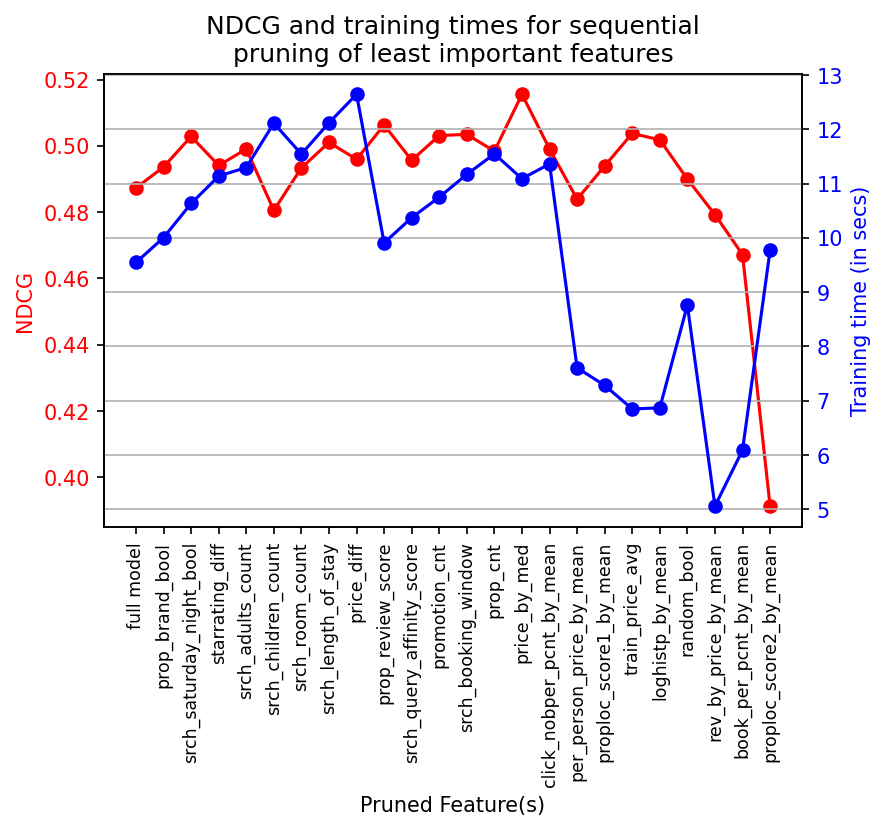

In [456]:
optimizer(train_with_newattr[:int(1e5)], features_to_prune = 23, return_data=False, small_train=True, verbose=True)

In [713]:
'''Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean', 'star_by_price_by_mean', 'random_bool', 
                    'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean','per_person_price_by_mean']'''

Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean', 'star_by_price_by_mean', 'random_bool', 
                    'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean','per_person_price_by_mean',
                    'price_by_med','train_price_avg']

In [660]:
Rfc = sk.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
ndcg, feature_list = iterator(train_with_newattr1[:int(1e5)], Rfc, new_attr=True)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 10%|████████▎                                                                          | 1/10 [00:09<01:29,  9.89s/it]<ipython-i

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.36s/it]


In [662]:
Selected_features = [i[1] for i in feature_list[:10]]
model_dict_new = {}
for i in range(20):
    model, ndcg = trainer(train_with_newattr1[:int(1e5)], Selected_features, model = None, target='booking_bool', 
                         print_factors = True, return_model = True, small_trainer=True)
    model_dict_new[model] = ndcg
    
small_rfc_new = max(model_dict_new, key = model_dict_new.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.48827188383750975
Feature Importances:
[[0.20854306083423638, 'proploc_score2_by_mean'],
 [0.14470889637882722, 'book_per_pcnt_by_mean'],
 [0.1350688852297985, 'star_by_price_by_mean'],
 [0.12767442588471214, 'random_bool'],
 [0.08808099380396607, 'rev_by_price_by_mean'],
 [0.08093722189568257, 'loghistp_by_mean'],
 [0.06330520864241868, 'proploc_score1_by_mean'],
 [0.05249897567646407, 'per_person_price_by_mean'],
 [0.049813866293295046, 'click_nobper_pcnt_by_mean'],
 [0.04936846536059932, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.35 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5062244151586501
Feature Importances:
[[0.20213753357895958, 'proploc_score2_by_mean'],
 [0.15813562398795022, 'book_per_pcnt_by_mean'],
 [0.1459383821942962, 'star_by_price_by_mean'],
 [0.1137784607042528, 'random_bool'],
 [0.07952771158697786, 'rev_by_price_by_mean'],
 [0.07553406561518512, 'loghistp_by_mean'],
 [0.06818705567831675, 'proploc_score1_by_mean'],
 [0.05648759903200909, 'price_by_med'],
 [0.054358643771137666, 'per_person_price_by_mean'],
 [0.04591492385091457, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.56 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5089568681758233
Feature Importances:
[[0.19734296751205624, 'proploc_score2_by_mean'],
 [0.15140158070114157, 'book_per_pcnt_by_mean'],
 [0.14358558003263047, 'star_by_price_by_mean'],
 [0.12163635152386405, 'random_bool'],
 [0.08680266510879234, 'rev_by_price_by_mean'],
 [0.08043828242628366, 'loghistp_by_mean'],
 [0.06392800852444441, 'proploc_score1_by_mean'],
 [0.05904657356304422, 'per_person_price_by_mean'],
 [0.052906810607841505, 'price_by_med'],
 [0.042911179999901614, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.83 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4971814717432763
Feature Importances:
[[0.21734395733113573, 'proploc_score2_by_mean'],
 [0.14822527885353792, 'book_per_pcnt_by_mean'],
 [0.13383788282725093, 'star_by_price_by_mean'],
 [0.12102957977405766, 'random_bool'],
 [0.08691126249131019, 'rev_by_price_by_mean'],
 [0.07655728515600439, 'loghistp_by_mean'],
 [0.06775926647114533, 'proploc_score1_by_mean'],
 [0.0512928798903381, 'price_by_med'],
 [0.05065927331965359, 'per_person_price_by_mean'],
 [0.04638333388556612, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.56 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4873445051722277
Feature Importances:
[[0.20942152663445252, 'proploc_score2_by_mean'],
 [0.14534078519588361, 'book_per_pcnt_by_mean'],
 [0.1363816439697035, 'star_by_price_by_mean'],
 [0.12260776368272909, 'random_bool'],
 [0.08670455756213999, 'loghistp_by_mean'],
 [0.08198798809065182, 'rev_by_price_by_mean'],
 [0.0684001961865249, 'proploc_score1_by_mean'],
 [0.053700507870873965, 'per_person_price_by_mean'],
 [0.048451564297562734, 'click_nobper_pcnt_by_mean'],
 [0.04700346650947795, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.18 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5024269010545378
Feature Importances:
[[0.20446219319843145, 'proploc_score2_by_mean'],
 [0.15092159787848045, 'book_per_pcnt_by_mean'],
 [0.1378578537351911, 'star_by_price_by_mean'],
 [0.12388065610423224, 'random_bool'],
 [0.08703863912685757, 'loghistp_by_mean'],
 [0.07983694501373087, 'rev_by_price_by_mean'],
 [0.07110403429881024, 'proploc_score1_by_mean'],
 [0.05056790984696162, 'per_person_price_by_mean'],
 [0.048578936036467214, 'price_by_med'],
 [0.045751234760837214, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.84 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5072650400421437
Feature Importances:
[[0.21074294176135183, 'proploc_score2_by_mean'],
 [0.1411115736590061, 'star_by_price_by_mean'],
 [0.14012928054813067, 'book_per_pcnt_by_mean'],
 [0.1205459665642484, 'random_bool'],
 [0.08687128258442453, 'loghistp_by_mean'],
 [0.07722142504730863, 'rev_by_price_by_mean'],
 [0.06641314083425373, 'proploc_score1_by_mean'],
 [0.057106166843491034, 'per_person_price_by_mean'],
 [0.051698765557546614, 'click_nobper_pcnt_by_mean'],
 [0.04815945660023848, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.97 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49626690300497284
Feature Importances:
[[0.19500413410351153, 'proploc_score2_by_mean'],
 [0.151072696816807, 'book_per_pcnt_by_mean'],
 [0.14185677691384452, 'star_by_price_by_mean'],
 [0.1218871785333463, 'random_bool'],
 [0.08530812090213086, 'loghistp_by_mean'],
 [0.08506957434267243, 'rev_by_price_by_mean'],
 [0.06744523559996993, 'proploc_score1_by_mean'],
 [0.052402610045882654, 'per_person_price_by_mean'],
 [0.0510389373673371, 'price_by_med'],
 [0.04891473537449774, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.64 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.502893980275141
Feature Importances:
[[0.1927034886556273, 'proploc_score2_by_mean'],
 [0.15323202806118383, 'star_by_price_by_mean'],
 [0.14047960537869805, 'book_per_pcnt_by_mean'],
 [0.12219188296017541, 'random_bool'],
 [0.08804441513788179, 'loghistp_by_mean'],
 [0.07679367164435232, 'rev_by_price_by_mean'],
 [0.06614695476021873, 'proploc_score1_by_mean'],
 [0.06325416140309856, 'per_person_price_by_mean'],
 [0.05037285915558905, 'price_by_med'],
 [0.04678093284317499, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.82 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5070237594154835
Feature Importances:
[[0.19410898966810172, 'proploc_score2_by_mean'],
 [0.14645374755459523, 'book_per_pcnt_by_mean'],
 [0.14194339646724655, 'star_by_price_by_mean'],
 [0.13039265836881056, 'random_bool'],
 [0.08454291899486381, 'rev_by_price_by_mean'],
 [0.07997909316553599, 'loghistp_by_mean'],
 [0.06495057306870412, 'proploc_score1_by_mean'],
 [0.05505957648636719, 'per_person_price_by_mean'],
 [0.052212123827351575, 'click_nobper_pcnt_by_mean'],
 [0.05035692239842329, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.22 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5130287808609292
Feature Importances:
[[0.20112377728180567, 'proploc_score2_by_mean'],
 [0.15278717437201922, 'book_per_pcnt_by_mean'],
 [0.1308532318815295, 'star_by_price_by_mean'],
 [0.12596625054431715, 'random_bool'],
 [0.09228671795286814, 'loghistp_by_mean'],
 [0.08268193592049301, 'rev_by_price_by_mean'],
 [0.06717689964234498, 'proploc_score1_by_mean'],
 [0.05198228347962189, 'price_by_med'],
 [0.049324003172262924, 'per_person_price_by_mean'],
 [0.04581772575273752, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.45 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.491953733031403
Feature Importances:
[[0.20154360844676975, 'proploc_score2_by_mean'],
 [0.15086882237256846, 'book_per_pcnt_by_mean'],
 [0.13756846808867576, 'star_by_price_by_mean'],
 [0.12228103092010707, 'random_bool'],
 [0.08514728849413954, 'rev_by_price_by_mean'],
 [0.07917077743649684, 'loghistp_by_mean'],
 [0.0675775291172721, 'proploc_score1_by_mean'],
 [0.052845051652839245, 'per_person_price_by_mean'],
 [0.051756205384893485, 'price_by_med'],
 [0.051241218086237814, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.68 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5001477972615042
Feature Importances:
[[0.20562464482076467, 'proploc_score2_by_mean'],
 [0.15643121810359223, 'book_per_pcnt_by_mean'],
 [0.13954527381704562, 'star_by_price_by_mean'],
 [0.12073783597300261, 'random_bool'],
 [0.08185898634292489, 'rev_by_price_by_mean'],
 [0.07951446060851766, 'loghistp_by_mean'],
 [0.06819349681615121, 'proploc_score1_by_mean'],
 [0.052648603470684306, 'per_person_price_by_mean'],
 [0.04835566250462958, 'price_by_med'],
 [0.04708981754268724, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.92 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5012601373757081
Feature Importances:
[[0.20951543837676975, 'proploc_score2_by_mean'],
 [0.14644974044172934, 'book_per_pcnt_by_mean'],
 [0.14415428366440514, 'star_by_price_by_mean'],
 [0.1285402850964064, 'random_bool'],
 [0.08499787043014205, 'rev_by_price_by_mean'],
 [0.07913334842426152, 'loghistp_by_mean'],
 [0.05842609522619798, 'proploc_score1_by_mean'],
 [0.05701915117457472, 'per_person_price_by_mean'],
 [0.04830027614989078, 'price_by_med'],
 [0.043463511015622465, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.45 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4915219256111323
Feature Importances:
[[0.20597155654948962, 'proploc_score2_by_mean'],
 [0.15185925524473737, 'book_per_pcnt_by_mean'],
 [0.13375265504238557, 'star_by_price_by_mean'],
 [0.12021649645636258, 'random_bool'],
 [0.08343466552400779, 'rev_by_price_by_mean'],
 [0.07718446868569774, 'loghistp_by_mean'],
 [0.06521799133222915, 'proploc_score1_by_mean'],
 [0.05665576642277314, 'per_person_price_by_mean'],
 [0.05590765308135771, 'click_nobper_pcnt_by_mean'],
 [0.049799491660959386, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.95 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4913869037010105
Feature Importances:
[[0.21284910464911996, 'proploc_score2_by_mean'],
 [0.15627324154727515, 'book_per_pcnt_by_mean'],
 [0.13393372540514753, 'random_bool'],
 [0.12780436159581243, 'star_by_price_by_mean'],
 [0.08238017439633699, 'rev_by_price_by_mean'],
 [0.08093334442577982, 'loghistp_by_mean'],
 [0.056491113205281274, 'proploc_score1_by_mean'],
 [0.0547136631517895, 'price_by_med'],
 [0.05445849739578415, 'per_person_price_by_mean'],
 [0.040162774227673205, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.00 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4856294562565668
Feature Importances:
[[0.19908295731441747, 'proploc_score2_by_mean'],
 [0.15391236453614257, 'book_per_pcnt_by_mean'],
 [0.1415920033491831, 'star_by_price_by_mean'],
 [0.12876377594893484, 'random_bool'],
 [0.0832861066819995, 'rev_by_price_by_mean'],
 [0.07696456182926427, 'loghistp_by_mean'],
 [0.06865410154202635, 'proploc_score1_by_mean'],
 [0.05333180263966878, 'price_by_med'],
 [0.04758996002228335, 'per_person_price_by_mean'],
 [0.04682236613607982, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.14 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49756571930055904
Feature Importances:
[[0.2047758809309799, 'proploc_score2_by_mean'],
 [0.14861949089059281, 'book_per_pcnt_by_mean'],
 [0.14110781169495068, 'star_by_price_by_mean'],
 [0.12817719363658786, 'random_bool'],
 [0.08178154493512131, 'loghistp_by_mean'],
 [0.07934288276854506, 'rev_by_price_by_mean'],
 [0.06565239281533715, 'proploc_score1_by_mean'],
 [0.051926091344615385, 'per_person_price_by_mean'],
 [0.051715740961720574, 'price_by_med'],
 [0.046900970021549374, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.89 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.504402968097348
Feature Importances:
[[0.2020702617569443, 'proploc_score2_by_mean'],
 [0.1503257176107194, 'star_by_price_by_mean'],
 [0.14326263480741885, 'book_per_pcnt_by_mean'],
 [0.12608376512173694, 'random_bool'],
 [0.0808816483704083, 'loghistp_by_mean'],
 [0.08024180425442458, 'rev_by_price_by_mean'],
 [0.06618589854832155, 'proploc_score1_by_mean'],
 [0.053333642825445525, 'per_person_price_by_mean'],
 [0.052748916698946303, 'click_nobper_pcnt_by_mean'],
 [0.04486571000563418, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.13 sec
NDCG: 0.48633195142186114
Feature Importances:
[[0.20525307637732165, 'proploc_score2_by_mean'],
 [0.15707014548778048, 'book_per_pcnt_by_mean'],
 [0.14116356481604597, 'star_by_price_by_mean'],
 [0.11967557502230002, 'random_bool'],
 [0.09232471474147977, 'rev_by_price_by_mean'],
 [0.0779177697550844, 'loghistp_by_mean'],
 [0.06232897378850565, 'proploc_score1_by_mean'],
 [0.05490480670654858, 'per_person

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [663]:
model_dict_new[small_rfc_new]

0.5130287808609292

In [656]:
weaklearner = sk.tree.DecisionTreeClassifier(max_depth=1, min_samples_split=4)
AdaModel = sk.ensemble.AdaBoostClassifier(base_estimator = weaklearner, n_estimators=100)
ndcg, feature_list = iterator(train_with_newattr1[:int(1e5)], AdaModel, new_attr=True)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 10%|████████▎                                                                          | 1/10 [00:10<01:30, 10.02s/it]<ipython-i

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.96s/it]


In [658]:
Selected_features = [i[1] for i in feature_list[:10]]
model_dict_new = {}
for i in range(20):
    weaklearner = sk.tree.DecisionTreeClassifier(max_depth=1, min_samples_split=4)
    AdaModel = sk.ensemble.AdaBoostClassifier(base_estimator = weaklearner, n_estimators=100)
    model, ndcg = trainer(train_with_newattr1[:int(1e5)], Selected_features , model = AdaModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict_new[model]= ndcg
    
small_ada_new = max(model_dict_new, key=model_dict_new.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5052224021464051
Feature Importances:
[[0.14, 'star_by_price_by_mean'],
 [0.14, 'proploc_score2_by_mean'],
 [0.13, 'book_per_pcnt_by_mean'],
 [0.11, 'price_by_med'],
 [0.1, 'train_price_avg'],
 [0.1, 'per_person_price_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.06, 'prop_cnt'],
 [0.05, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.35 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5096832295605228
Feature Importances:
[[0.14, 'proploc_score2_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.13, 'price_by_med'],
 [0.11, 'per_person_price_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.1, 'rev_by_price_by_mean'],
 [0.08, 'train_price_avg'],
 [0.07, 'proploc_score1_by_mean'],
 [0.07, 'loghistp_by_mean'],
 [0.06, 'prop_cnt']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.66 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49444119883790527
Feature Importances:
[[0.14, 'proploc_score2_by_mean'],
 [0.14, 'price_by_med'],
 [0.14, 'book_per_pcnt_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.11, 'train_price_avg'],
 [0.1, 'rev_by_price_by_mean'],
 [0.08, 'per_person_price_by_mean'],
 [0.07, 'proploc_score1_by_mean'],
 [0.05, 'prop_cnt'],
 [0.04, 'loghistp_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.67 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.496899471370835
Feature Importances:
[[0.15, 'proploc_score2_by_mean'],
 [0.14, 'star_by_price_by_mean'],
 [0.13, 'price_by_med'],
 [0.11, 'per_person_price_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'train_price_avg'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.06, 'proploc_score1_by_mean'],
 [0.04, 'prop_cnt']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.48 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4941206439256918
Feature Importances:
[[0.16, 'star_by_price_by_mean'],
 [0.16, 'proploc_score2_by_mean'],
 [0.15, 'per_person_price_by_mean'],
 [0.1, 'rev_by_price_by_mean'],
 [0.1, 'price_by_med'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.07, 'train_price_avg'],
 [0.07, 'prop_cnt'],
 [0.06, 'loghistp_by_mean'],
 [0.03, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.51 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4938129414295853
Feature Importances:
[[0.19, 'proploc_score2_by_mean'],
 [0.14, 'rev_by_price_by_mean'],
 [0.13, 'per_person_price_by_mean'],
 [0.12, 'star_by_price_by_mean'],
 [0.11, 'price_by_med'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.07, 'proploc_score1_by_mean'],
 [0.06, 'prop_cnt'],
 [0.06, 'loghistp_by_mean'],
 [0.04, 'train_price_avg']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.54 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.507451173273957
Feature Importances:
[[0.18, 'proploc_score2_by_mean'],
 [0.15, 'per_person_price_by_mean'],
 [0.1, 'star_by_price_by_mean'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.09, 'rev_by_price_by_mean'],
 [0.09, 'prop_cnt'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'price_by_med'],
 [0.07, 'train_price_avg'],
 [0.05, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.93 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5003559764961106
Feature Importances:
[[0.14, 'star_by_price_by_mean'],
 [0.14, 'price_by_med'],
 [0.13, 'proploc_score2_by_mean'],
 [0.13, 'per_person_price_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'train_price_avg'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.05, 'proploc_score1_by_mean'],
 [0.04, 'prop_cnt']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.90 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5064235981623418
Feature Importances:
[[0.19, 'proploc_score2_by_mean'],
 [0.18, 'star_by_price_by_mean'],
 [0.16, 'per_person_price_by_mean'],
 [0.09, 'train_price_avg'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'price_by_med'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.05, 'rev_by_price_by_mean'],
 [0.05, 'prop_cnt'],
 [0.03, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.84 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49731047547158236
Feature Importances:
[[0.15, 'proploc_score2_by_mean'],
 [0.13, 'per_person_price_by_mean'],
 [0.12, 'star_by_price_by_mean'],
 [0.11, 'price_by_med'],
 [0.1, 'loghistp_by_mean'],
 [0.09, 'book_per_pcnt_by_mean'],
 [0.08, 'train_price_avg'],
 [0.08, 'rev_by_price_by_mean'],
 [0.07, 'proploc_score1_by_mean'],
 [0.07, 'prop_cnt']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.27 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.50295735408826
Feature Importances:
[[0.16, 'proploc_score2_by_mean'],
 [0.14, 'price_by_med'],
 [0.13, 'star_by_price_by_mean'],
 [0.12, 'train_price_avg'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'per_person_price_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.07, 'loghistp_by_mean'],
 [0.06, 'prop_cnt'],
 [0.04, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.62 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4997904937589216
Feature Importances:
[[0.14, 'proploc_score2_by_mean'],
 [0.14, 'price_by_med'],
 [0.13, 'star_by_price_by_mean'],
 [0.11, 'train_price_avg'],
 [0.11, 'per_person_price_by_mean'],
 [0.09, 'rev_by_price_by_mean'],
 [0.09, 'book_per_pcnt_by_mean'],
 [0.08, 'loghistp_by_mean'],
 [0.07, 'prop_cnt'],
 [0.04, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.56 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.48722668654439705
Feature Importances:
[[0.14, 'star_by_price_by_mean'],
 [0.14, 'price_by_med'],
 [0.13, 'proploc_score2_by_mean'],
 [0.13, 'book_per_pcnt_by_mean'],
 [0.12, 'per_person_price_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'train_price_avg'],
 [0.08, 'rev_by_price_by_mean'],
 [0.05, 'prop_cnt'],
 [0.04, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.64 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.48755956789231564
Feature Importances:
[[0.14, 'proploc_score2_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.12, 'price_by_med'],
 [0.12, 'per_person_price_by_mean'],
 [0.11, 'rev_by_price_by_mean'],
 [0.09, 'prop_cnt'],
 [0.08, 'train_price_avg'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.07, 'loghistp_by_mean'],
 [0.06, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.67 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49249372741661396
Feature Importances:
[[0.16, 'price_by_med'],
 [0.14, 'per_person_price_by_mean'],
 [0.13, 'proploc_score2_by_mean'],
 [0.13, 'book_per_pcnt_by_mean'],
 [0.12, 'star_by_price_by_mean'],
 [0.09, 'rev_by_price_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.06, 'prop_cnt'],
 [0.05, 'train_price_avg'],
 [0.03, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.80 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4944633302601245
Feature Importances:
[[0.19, 'proploc_score2_by_mean'],
 [0.12, 'price_by_med'],
 [0.11, 'star_by_price_by_mean'],
 [0.11, 'per_person_price_by_mean'],
 [0.1, 'train_price_avg'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.08, 'prop_cnt'],
 [0.07, 'rev_by_price_by_mean'],
 [0.07, 'loghistp_by_mean'],
 [0.05, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.51 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.48028243577328905
Feature Importances:
[[0.2, 'proploc_score2_by_mean'],
 [0.14, 'star_by_price_by_mean'],
 [0.12, 'rev_by_price_by_mean'],
 [0.11, 'per_person_price_by_mean'],
 [0.1, 'proploc_score1_by_mean'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.07, 'prop_cnt'],
 [0.07, 'price_by_med'],
 [0.05, 'train_price_avg'],
 [0.04, 'loghistp_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.75 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49380327058607126
Feature Importances:
[[0.15, 'per_person_price_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.12, 'proploc_score2_by_mean'],
 [0.11, 'rev_by_price_by_mean'],
 [0.11, 'price_by_med'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.1, 'loghistp_by_mean'],
 [0.06, 'proploc_score1_by_mean'],
 [0.06, 'prop_cnt'],
 [0.05, 'train_price_avg']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.82 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4988948530416796
Feature Importances:
[[0.16, 'price_by_med'],
 [0.14, 'star_by_price_by_mean'],
 [0.13, 'proploc_score2_by_mean'],
 [0.13, 'per_person_price_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.08, 'loghistp_by_mean'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.07, 'train_price_avg'],
 [0.07, 'prop_cnt'],
 [0.06, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.63 sec
NDCG: 0.49236914073398147
Feature Importances:
[[0.14, 'price_by_med'],
 [0.13, 'rev_by_price_by_mean'],
 [0.13, 'per_person_price_by_mean'],
 [0.12, 'star_by_price_by_mean'],
 [0.12, 'proploc_score2_by_mean'],
 [0.1, 'prop_cnt'],
 [0.08, 'train_price_avg'],
 [0.08, 'loghistp_by_mean'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.02, 'proploc_score1_by_mean']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
     

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [659]:
model_dict_new[small_ada_new]

0.5096832295605228

In [653]:
def iterator(df, some_model, iterations=10, new_attr = False):
    a_dict = {}
    for i in tqdm(range(iterations)):
        ndcg, feature_list = trainer(df, model = some_model, target='booking_bool', 
                                     print_factors = False, return_model = False, small_trainer=True, new_features=new_attr)

        a_dict[ndcg] = feature_list

    max_ndcg = max(a_dict.keys())
    #print('The dict: ', a_dict)

    return max_ndcg, a_dict[max_ndcg]

In [651]:
GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)

ndcg, feature_list = iterator(train_with_newattr1[:int(1e5)], GradModel, new_attr=True)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 10%|████████▎                                                                          | 1/10 [00:17<02:39, 17.75s/it]<ipython-i

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.51s/it]

The dict:  {0.512657090592281: [[0.2063242264122118, 'proploc_score2_by_mean'], [0.1759073250362679, 'star_by_price_by_mean'], [0.16226946676274745, 'random_bool'], [0.1581939831851103, 'book_per_pcnt_by_mean'], [0.056212215622869925, 'rev_by_price_by_mean'], [0.04347650371415398, 'loghistp_by_mean'], [0.03780189187788062, 'click_nobper_pcnt_by_mean'], [0.028968182482205517, 'train_price_avg'], [0.02788605894224114, 'per_person_price_by_mean'], [0.018322051327506073, 'srch_query_affinity_score'], [0.017912542396567126, 'proploc_score1_by_mean'], [0.01595964963297907, 'srch_booking_window'], [0.014279349291982527, 'prop_cnt'], [0.011635144181244322, 'promotion_cnt'], [0.005067466583169136, 'srch_length_of_stay'], [0.005011211291798413, 'starrating_diff_by_mean'], [0.004531537234700429, 'prop_review_score'], [0.003914316320256068, 'price_diff_by_mean'], [0.0031181041067008244, 'price_by_med'], [0.0023827045124395108, 'prop_brand_bool'], [0.0008260690849678273, 'srch_saturday_night_bool']

In [654]:
# Selected_features = [i[1] for i in feature_list[:8]]
Selected_features = [i[1] for i in feature_list[:10]]

model_dict_new = {}
for i in range(20):
    GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
    model, ndcg = trainer(train_with_newattr1[:int(1e5)], Selected_features , model = GradModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict_new[model]= ndcg
    
small_grad_new = max(model_dict_new, key=model_dict_new.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49606413188673215
Feature Importances:
[[0.24349186439315296, 'proploc_score2_by_mean'],
 [0.1778537242368524, 'book_per_pcnt_by_mean'],
 [0.1702567190194524, 'random_bool'],
 [0.15912365556892039, 'star_by_price_by_mean'],
 [0.06185446885350436, 'loghistp_by_mean'],
 [0.061806748813019036, 'rev_by_price_by_mean'],
 [0.05013130815353286, 'proploc_score1_by_mean'],
 [0.03789605916252431, 'click_nobper_pcnt_by_mean'],
 [0.02096759174932104, 'train_price_avg'],
 [0.016617860049720063, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.02 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5056711890003375
Feature Importances:
[[0.24398685184729227, 'proploc_score2_by_mean'],
 [0.18644527657651838, 'random_bool'],
 [0.1639802887262899, 'star_by_price_by_mean'],
 [0.16197436202820367, 'book_per_pcnt_by_mean'],
 [0.07623369791956508, 'loghistp_by_mean'],
 [0.05688059462500114, 'rev_by_price_by_mean'],
 [0.046866459743482365, 'click_nobper_pcnt_by_mean'],
 [0.025314190314058817, 'proploc_score1_by_mean'],
 [0.020007795759370693, 'train_price_avg'],
 [0.01831048246021764, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.10 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5135773480087797
Feature Importances:
[[0.23599241199304521, 'proploc_score2_by_mean'],
 [0.17249664207883483, 'random_bool'],
 [0.1682757861758028, 'star_by_price_by_mean'],
 [0.14487478870127052, 'book_per_pcnt_by_mean'],
 [0.06952677317705133, 'loghistp_by_mean'],
 [0.06756619742824174, 'rev_by_price_by_mean'],
 [0.047556111394563366, 'proploc_score1_by_mean'],
 [0.043294831453684755, 'click_nobper_pcnt_by_mean'],
 [0.034740445094569854, 'train_price_avg'],
 [0.015676012502935502, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.43 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4992373819610138
Feature Importances:
[[0.24079579308128998, 'proploc_score2_by_mean'],
 [0.17906495134166417, 'book_per_pcnt_by_mean'],
 [0.17175267805446123, 'random_bool'],
 [0.16203945712961354, 'star_by_price_by_mean'],
 [0.07390918585513681, 'loghistp_by_mean'],
 [0.06563385148172131, 'rev_by_price_by_mean'],
 [0.036413165497299345, 'proploc_score1_by_mean'],
 [0.02984736228583785, 'click_nobper_pcnt_by_mean'],
 [0.02274213730540483, 'train_price_avg'],
 [0.017801417967570992, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.34 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5099187864119249
Feature Importances:
[[0.266818092156666, 'proploc_score2_by_mean'],
 [0.2210513981456192, 'star_by_price_by_mean'],
 [0.19285060762689218, 'random_bool'],
 [0.1480622066379233, 'book_per_pcnt_by_mean'],
 [0.06160160030547328, 'loghistp_by_mean'],
 [0.050738117195890345, 'rev_by_price_by_mean'],
 [0.024966142131171157, 'train_price_avg'],
 [0.016886843317083483, 'click_nobper_pcnt_by_mean'],
 [0.012138726051552994, 'proploc_score1_by_mean'],
 [0.004886266431728148, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.10 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5088368882836588
Feature Importances:
[[0.25162591512053584, 'proploc_score2_by_mean'],
 [0.20310544398586414, 'random_bool'],
 [0.18182128500415703, 'star_by_price_by_mean'],
 [0.1656939781180879, 'book_per_pcnt_by_mean'],
 [0.05752912000866613, 'rev_by_price_by_mean'],
 [0.05170610357231216, 'loghistp_by_mean'],
 [0.038218095791417724, 'proploc_score1_by_mean'],
 [0.020261055954651712, 'click_nobper_pcnt_by_mean'],
 [0.016091282733330346, 'prop_cnt'],
 [0.013947719710977089, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.41 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.506733584331152
Feature Importances:
[[0.24618155665631383, 'proploc_score2_by_mean'],
 [0.1924992595616537, 'book_per_pcnt_by_mean'],
 [0.1849731241757538, 'random_bool'],
 [0.15849079955730044, 'star_by_price_by_mean'],
 [0.07696174697854083, 'loghistp_by_mean'],
 [0.06006659541260397, 'rev_by_price_by_mean'],
 [0.028980900777505095, 'proploc_score1_by_mean'],
 [0.025187166160976132, 'train_price_avg'],
 [0.019043394341098408, 'click_nobper_pcnt_by_mean'],
 [0.007615456378253805, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 7.83 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5122245438874645
Feature Importances:
[[0.26029807596485893, 'proploc_score2_by_mean'],
 [0.19755957169016816, 'random_bool'],
 [0.17516141018913484, 'star_by_price_by_mean'],
 [0.1629898977791328, 'book_per_pcnt_by_mean'],
 [0.06745315779475296, 'loghistp_by_mean'],
 [0.05103858347033181, 'rev_by_price_by_mean'],
 [0.028600223018261397, 'proploc_score1_by_mean'],
 [0.026202766125864942, 'train_price_avg'],
 [0.025237081273281933, 'click_nobper_pcnt_by_mean'],
 [0.0054592326942125135, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.42 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5140039726904164
Feature Importances:
[[0.23302919462339328, 'proploc_score2_by_mean'],
 [0.18406541560603681, 'star_by_price_by_mean'],
 [0.15724739608941996, 'random_bool'],
 [0.13729581152474404, 'book_per_pcnt_by_mean'],
 [0.08675195827307941, 'rev_by_price_by_mean'],
 [0.07836452067213652, 'loghistp_by_mean'],
 [0.03581296609539738, 'proploc_score1_by_mean'],
 [0.03474245983054207, 'click_nobper_pcnt_by_mean'],
 [0.03274069743513355, 'train_price_avg'],
 [0.019949579850116854, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 12.34 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5037121388197091
Feature Importances:
[[0.22486602264726888, 'proploc_score2_by_mean'],
 [0.1982980696706233, 'random_bool'],
 [0.1975828802842097, 'star_by_price_by_mean'],
 [0.17623429176714908, 'book_per_pcnt_by_mean'],
 [0.07082059836836589, 'loghistp_by_mean'],
 [0.05372722281807816, 'rev_by_price_by_mean'],
 [0.023675181556760114, 'click_nobper_pcnt_by_mean'],
 [0.020466183329613745, 'prop_cnt'],
 [0.017705435361231127, 'train_price_avg'],
 [0.016624114196699825, 'proploc_score1_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 7.00 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5181695502152985
Feature Importances:
[[0.2139800918175752, 'proploc_score2_by_mean'],
 [0.17760146184531053, 'random_bool'],
 [0.17273170289892312, 'book_per_pcnt_by_mean'],
 [0.16886822636514687, 'star_by_price_by_mean'],
 [0.07033036487675896, 'loghistp_by_mean'],
 [0.05323913432521648, 'rev_by_price_by_mean'],
 [0.05290024229309298, 'proploc_score1_by_mean'],
 [0.0397828010602394, 'train_price_avg'],
 [0.033210916841700966, 'click_nobper_pcnt_by_mean'],
 [0.017355057676035436, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.24 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5071824794685774
Feature Importances:
[[0.24284870372693673, 'proploc_score2_by_mean'],
 [0.16640513743991933, 'random_bool'],
 [0.1599503923183945, 'book_per_pcnt_by_mean'],
 [0.15364398663800838, 'star_by_price_by_mean'],
 [0.09343238937644216, 'loghistp_by_mean'],
 [0.06946132860953254, 'rev_by_price_by_mean'],
 [0.03819178575483716, 'train_price_avg'],
 [0.03624305955256329, 'click_nobper_pcnt_by_mean'],
 [0.02275622199485136, 'proploc_score1_by_mean'],
 [0.01706699458851446, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.77 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5003026623029503
Feature Importances:
[[0.21755211998738808, 'proploc_score2_by_mean'],
 [0.18217275252597528, 'star_by_price_by_mean'],
 [0.1767100355007618, 'random_bool'],
 [0.17541952805479874, 'book_per_pcnt_by_mean'],
 [0.06551865551382165, 'rev_by_price_by_mean'],
 [0.059156239348972385, 'loghistp_by_mean'],
 [0.04029530763857575, 'click_nobper_pcnt_by_mean'],
 [0.03362336936155105, 'proploc_score1_by_mean'],
 [0.027855159497730913, 'train_price_avg'],
 [0.02169683257042439, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.38 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4915326121699073
Feature Importances:
[[0.24754204686227, 'proploc_score2_by_mean'],
 [0.20424767532616564, 'random_bool'],
 [0.199523666263136, 'star_by_price_by_mean'],
 [0.17997146716205567, 'book_per_pcnt_by_mean'],
 [0.05760380685486571, 'rev_by_price_by_mean'],
 [0.05365163139453538, 'loghistp_by_mean'],
 [0.018589738355507188, 'click_nobper_pcnt_by_mean'],
 [0.016851427076828556, 'prop_cnt'],
 [0.011017094811641748, 'proploc_score1_by_mean'],
 [0.011001445892994064, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.72 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5060434907052896
Feature Importances:
[[0.22155215748504015, 'proploc_score2_by_mean'],
 [0.18644965104562525, 'star_by_price_by_mean'],
 [0.1840900016350361, 'book_per_pcnt_by_mean'],
 [0.1776266528230062, 'random_bool'],
 [0.07693789020135454, 'loghistp_by_mean'],
 [0.06135318886461648, 'rev_by_price_by_mean'],
 [0.04227045018876647, 'proploc_score1_by_mean'],
 [0.018155198084671035, 'train_price_avg'],
 [0.016271153667185314, 'prop_cnt'],
 [0.015293656004698397, 'click_nobper_pcnt_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 7.96 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4992223463296358
Feature Importances:
[[0.2438776805357639, 'proploc_score2_by_mean'],
 [0.19447431249228653, 'random_bool'],
 [0.18841036063698333, 'star_by_price_by_mean'],
 [0.17682817216421376, 'book_per_pcnt_by_mean'],
 [0.057019871773827946, 'loghistp_by_mean'],
 [0.055388528527029295, 'rev_by_price_by_mean'],
 [0.03003456171072975, 'click_nobper_pcnt_by_mean'],
 [0.020205961711187805, 'train_price_avg'],
 [0.020184544444298427, 'proploc_score1_by_mean'],
 [0.013576006003679161, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 7.59 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5029802780671045
Feature Importances:
[[0.22880673335065035, 'proploc_score2_by_mean'],
 [0.17985446018617665, 'star_by_price_by_mean'],
 [0.14798021561414457, 'random_bool'],
 [0.13087071955885604, 'book_per_pcnt_by_mean'],
 [0.08670236567390138, 'rev_by_price_by_mean'],
 [0.07557984386726238, 'loghistp_by_mean'],
 [0.050783569769714945, 'proploc_score1_by_mean'],
 [0.040609318486013145, 'click_nobper_pcnt_by_mean'],
 [0.03583403580322361, 'train_price_avg'],
 [0.022978737690056993, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 12.91 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4886295566084698
Feature Importances:
[[0.24058584948271117, 'proploc_score2_by_mean'],
 [0.20098418684286568, 'book_per_pcnt_by_mean'],
 [0.19353014291579432, 'star_by_price_by_mean'],
 [0.18534386540931538, 'random_bool'],
 [0.05080906183443051, 'rev_by_price_by_mean'],
 [0.04540361383715507, 'proploc_score1_by_mean'],
 [0.0363725093756461, 'loghistp_by_mean'],
 [0.020312765145374313, 'click_nobper_pcnt_by_mean'],
 [0.020125070816688764, 'train_price_avg'],
 [0.006532934340018657, 'prop_cnt']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.09 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5099507799084722
Feature Importances:
[[0.23700749622388684, 'proploc_score2_by_mean'],
 [0.2025143408068743, 'random_bool'],
 [0.18385246354095042, 'book_per_pcnt_by_mean'],
 [0.18228904892671252, 'star_by_price_by_mean'],
 [0.0627209906048802, 'rev_by_price_by_mean'],
 [0.053308856708038845, 'loghistp_by_mean'],
 [0.03404302704774635, 'proploc_score1_by_mean'],
 [0.0319364564574552, 'train_price_avg'],
 [0.006932119352224425, 'prop_cnt'],
 [0.005395200331230897, 'click_nobper_pcnt_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.44 sec
NDCG: 0.4931185736099828
Feature Importances:
[[0.23474547625678613, 'proploc_score2_by_mean'],
 [0.19072450391598564, 'random_bool'],
 [0.18530821745377152, 'star_by_price_by_mean'],
 [0.17472618429709436, 'book_per_pcnt_by_mean'],
 [0.07116768208489485, 'loghistp_by_mean'],
 [0.052830760584366435, 'rev_by_price_by_mean'],
 [0.03198911043451852, 'click_nobper_pcnt_by_mean'],
 [0.026877347751704517

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [655]:
model_dict_new[small_grad_new]

0.5181695502152985

In [602]:
Selected_features = ['proploc_score2_by_mean', 'random_bool', 'book_per_pcnt_by_mean', 'star_by_price_by_mean', 
                     'rev_by_price_by_mean', 'loghistp_by_mean', 'click_nobper_pcnt_by_mean', 'proploc_score1_by_mean', 
                     'prop_cnt', 'price_by_med']
model_dict_new = {}
for i in range(20):
    GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
    model, ndcg = trainer(train_with_newattr1[:int(1e5)], Selected_features , model = GradModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict_new[model]= ndcg
    
small_grad_new = max(model_dict_new, key=model_dict_new.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5047905332333518
Feature Importances:
[[0.26123846632130876, 'proploc_score2_by_mean'],
 [0.20460329044128273, 'random_bool'],
 [0.17325327548486538, 'star_by_price_by_mean'],
 [0.14934352826524874, 'book_per_pcnt_by_mean'],
 [0.06728085849063349, 'rev_by_price_by_mean'],
 [0.05160701033009765, 'loghistp_by_mean'],
 [0.03724925047477171, 'proploc_score1_by_mean'],
 [0.025933741209725497, 'train_price_avg'],
 [0.020882502599467258, 'per_person_price_by_mean'],
 [0.008608076382598685, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 6.89 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5059167468268596
Feature Importances:
[[0.23557850080862636, 'proploc_score2_by_mean'],
 [0.17158958998260126, 'random_bool'],
 [0.17087187339088566, 'star_by_price_by_mean'],
 [0.16884811744438227, 'book_per_pcnt_by_mean'],
 [0.06782277010697035, 'rev_by_price_by_mean'],
 [0.05623082072539723, 'loghistp_by_mean'],
 [0.05566870362534852, 'proploc_score1_by_mean'],
 [0.02935187296703867, 'train_price_avg'],
 [0.025981964178895114, 'per_person_price_by_mean'],
 [0.018055786769854535, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.41 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4987128431382486
Feature Importances:
[[0.22781247016474526, 'proploc_score2_by_mean'],
 [0.19726020952958323, 'star_by_price_by_mean'],
 [0.17226926738257728, 'book_per_pcnt_by_mean'],
 [0.1704664608605582, 'random_bool'],
 [0.0572691217284129, 'loghistp_by_mean'],
 [0.051185763043444424, 'rev_by_price_by_mean'],
 [0.05021151581915133, 'proploc_score1_by_mean'],
 [0.03075174566096863, 'per_person_price_by_mean'],
 [0.029457498389102568, 'train_price_avg'],
 [0.013315947421456231, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.24 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49417133911517247
Feature Importances:
[[0.22874115140086712, 'proploc_score2_by_mean'],
 [0.1828012447203742, 'star_by_price_by_mean'],
 [0.18277273698928892, 'random_bool'],
 [0.1475284931433299, 'book_per_pcnt_by_mean'],
 [0.07878477425714961, 'loghistp_by_mean'],
 [0.05817460899347376, 'rev_by_price_by_mean'],
 [0.0418653556954545, 'proploc_score1_by_mean'],
 [0.03783413362174669, 'per_person_price_by_mean'],
 [0.025046510262317252, 'train_price_avg'],
 [0.01645099091599801, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.92 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5124726332588078
Feature Importances:
[[0.257070227895137, 'proploc_score2_by_mean'],
 [0.18967900663936962, 'random_bool'],
 [0.16809023114875413, 'star_by_price_by_mean'],
 [0.1672370095410545, 'book_per_pcnt_by_mean'],
 [0.05605094286564523, 'rev_by_price_by_mean'],
 [0.04306716396992966, 'proploc_score1_by_mean'],
 [0.041118925664643646, 'loghistp_by_mean'],
 [0.03485920901355195, 'train_price_avg'],
 [0.021975448152877518, 'price_by_med'],
 [0.020851835109036564, 'per_person_price_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.02 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4997961309489325
Feature Importances:
[[0.2530016393511718, 'proploc_score2_by_mean'],
 [0.19783591506573092, 'random_bool'],
 [0.17783123820906602, 'star_by_price_by_mean'],
 [0.16350446035760227, 'book_per_pcnt_by_mean'],
 [0.06377502044567086, 'rev_by_price_by_mean'],
 [0.05455632044101559, 'loghistp_by_mean'],
 [0.04179197473004577, 'proploc_score1_by_mean'],
 [0.02054872232510649, 'per_person_price_by_mean'],
 [0.01672756603963741, 'train_price_avg'],
 [0.010427143034952733, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.24 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5018493990556537
Feature Importances:
[[0.2509337815938554, 'proploc_score2_by_mean'],
 [0.18927225433541514, 'star_by_price_by_mean'],
 [0.1761933980201709, 'random_bool'],
 [0.150580215125136, 'book_per_pcnt_by_mean'],
 [0.06684678089043299, 'loghistp_by_mean'],
 [0.06274834538040604, 'rev_by_price_by_mean'],
 [0.037800487968601276, 'train_price_avg'],
 [0.026594916324519692, 'per_person_price_by_mean'],
 [0.023985586128738287, 'proploc_score1_by_mean'],
 [0.015044234232724595, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.10 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5074659610359875
Feature Importances:
[[0.22997384482926062, 'proploc_score2_by_mean'],
 [0.19851336090467117, 'star_by_price_by_mean'],
 [0.1813661204434055, 'random_bool'],
 [0.14677217856343724, 'book_per_pcnt_by_mean'],
 [0.06511524691267585, 'loghistp_by_mean'],
 [0.05417418111533931, 'rev_by_price_by_mean'],
 [0.04880837049462009, 'proploc_score1_by_mean'],
 [0.0426385367998741, 'train_price_avg'],
 [0.02602636921215381, 'per_person_price_by_mean'],
 [0.006611790724562325, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.01 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5001892930531222
Feature Importances:
[[0.2131370286611713, 'proploc_score2_by_mean'],
 [0.1915681196943696, 'book_per_pcnt_by_mean'],
 [0.17579184019255345, 'star_by_price_by_mean'],
 [0.17530590747254415, 'random_bool'],
 [0.0688816027463799, 'rev_by_price_by_mean'],
 [0.06294103421869666, 'loghistp_by_mean'],
 [0.03926857389652014, 'per_person_price_by_mean'],
 [0.029610164769667068, 'train_price_avg'],
 [0.029574974459568318, 'proploc_score1_by_mean'],
 [0.013920753888529386, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.74 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.503539428672738
Feature Importances:
[[0.22960638257487465, 'proploc_score2_by_mean'],
 [0.19684453092022658, 'star_by_price_by_mean'],
 [0.18538041842695208, 'random_bool'],
 [0.17212314511534388, 'book_per_pcnt_by_mean'],
 [0.07396675742778233, 'rev_by_price_by_mean'],
 [0.060619320838122964, 'loghistp_by_mean'],
 [0.0286720860988064, 'proploc_score1_by_mean'],
 [0.026411603027988916, 'per_person_price_by_mean'],
 [0.01676387471247342, 'train_price_avg'],
 [0.009611880857428635, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.62 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49955786195172064
Feature Importances:
[[0.24798651643440933, 'proploc_score2_by_mean'],
 [0.18601341384423337, 'random_bool'],
 [0.18022040468069303, 'star_by_price_by_mean'],
 [0.14374781961049377, 'book_per_pcnt_by_mean'],
 [0.06479297440428229, 'rev_by_price_by_mean'],
 [0.05447357543123945, 'loghistp_by_mean'],
 [0.03850377117066943, 'proploc_score1_by_mean'],
 [0.038141191166930134, 'train_price_avg'],
 [0.025769683472591055, 'price_by_med'],
 [0.020350649784458087, 'per_person_price_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.58 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5191695409822014
Feature Importances:
[[0.22932460006815333, 'proploc_score2_by_mean'],
 [0.1876236393583667, 'random_bool'],
 [0.1830018760403805, 'star_by_price_by_mean'],
 [0.15693526349992035, 'book_per_pcnt_by_mean'],
 [0.07789607395009264, 'loghistp_by_mean'],
 [0.06246023191082112, 'rev_by_price_by_mean'],
 [0.03256961540528474, 'proploc_score1_by_mean'],
 [0.032045070756318336, 'per_person_price_by_mean'],
 [0.02585085215507491, 'train_price_avg'],
 [0.012292776855587379, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.25 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49609983373347205
Feature Importances:
[[0.21045588165843496, 'proploc_score2_by_mean'],
 [0.1863801419102232, 'random_bool'],
 [0.177582202431961, 'star_by_price_by_mean'],
 [0.1746973872019203, 'book_per_pcnt_by_mean'],
 [0.07652694585999663, 'rev_by_price_by_mean'],
 [0.06478170386538215, 'loghistp_by_mean'],
 [0.038303794513700314, 'proploc_score1_by_mean'],
 [0.03735315102233507, 'train_price_avg'],
 [0.02264408323163299, 'per_person_price_by_mean'],
 [0.011274708304413378, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.22 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.503165802427768
Feature Importances:
[[0.23323053505362223, 'proploc_score2_by_mean'],
 [0.19195223818424104, 'random_bool'],
 [0.18731876727369742, 'book_per_pcnt_by_mean'],
 [0.1736076068066839, 'star_by_price_by_mean'],
 [0.06900515842403124, 'rev_by_price_by_mean'],
 [0.06347983807748964, 'loghistp_by_mean'],
 [0.034961239456141394, 'train_price_avg'],
 [0.028589550484500164, 'proploc_score1_by_mean'],
 [0.009237049010301096, 'price_by_med'],
 [0.008618017229291869, 'per_person_price_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 6.85 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5044980247423313
Feature Importances:
[[0.23240913672163635, 'proploc_score2_by_mean'],
 [0.176153473957244, 'random_bool'],
 [0.16617550891625282, 'star_by_price_by_mean'],
 [0.1556968737541621, 'book_per_pcnt_by_mean'],
 [0.06287199934265474, 'rev_by_price_by_mean'],
 [0.05850072862113354, 'loghistp_by_mean'],
 [0.04544333022914131, 'proploc_score1_by_mean'],
 [0.04322462230221686, 'per_person_price_by_mean'],
 [0.03877435538353326, 'train_price_avg'],
 [0.020749970772025023, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.10 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4815648114900512
Feature Importances:
[[0.22005346268830628, 'proploc_score2_by_mean'],
 [0.18783237360111962, 'random_bool'],
 [0.18323333683368134, 'star_by_price_by_mean'],
 [0.17144973162369662, 'book_per_pcnt_by_mean'],
 [0.07185122937255287, 'rev_by_price_by_mean'],
 [0.05935959446414309, 'loghistp_by_mean'],
 [0.02916424703199609, 'train_price_avg'],
 [0.029109861587115243, 'proploc_score1_by_mean'],
 [0.027573542772988395, 'per_person_price_by_mean'],
 [0.020372620024400438, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.63 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5131417230082614
Feature Importances:
[[0.24425712797748894, 'proploc_score2_by_mean'],
 [0.19105625887679573, 'star_by_price_by_mean'],
 [0.17061525547400155, 'random_bool'],
 [0.12975023900822158, 'book_per_pcnt_by_mean'],
 [0.07704974407386245, 'rev_by_price_by_mean'],
 [0.07332248489089646, 'loghistp_by_mean'],
 [0.04063239784941079, 'train_price_avg'],
 [0.03416290885370143, 'proploc_score1_by_mean'],
 [0.02177891846695785, 'per_person_price_by_mean'],
 [0.01737466452866337, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 13.08 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5131623731520671
Feature Importances:
[[0.2354380169051234, 'proploc_score2_by_mean'],
 [0.17748079731100508, 'star_by_price_by_mean'],
 [0.1632689672444987, 'random_bool'],
 [0.15115981227274056, 'book_per_pcnt_by_mean'],
 [0.06597476023046785, 'loghistp_by_mean'],
 [0.06444779479226075, 'rev_by_price_by_mean'],
 [0.048415309417097034, 'train_price_avg'],
 [0.03327071427722998, 'proploc_score1_by_mean'],
 [0.03169856613313837, 'price_by_med'],
 [0.028845261416438093, 'per_person_price_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 13.19 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49718167282654857
Feature Importances:
[[0.2363934594047894, 'proploc_score2_by_mean'],
 [0.2135010985981936, 'random_bool'],
 [0.18101231371280121, 'star_by_price_by_mean'],
 [0.17983339214428049, 'book_per_pcnt_by_mean'],
 [0.07451555192020057, 'rev_by_price_by_mean'],
 [0.0548624405767175, 'loghistp_by_mean'],
 [0.029577746552758064, 'proploc_score1_by_mean'],
 [0.015472065121133693, 'train_price_avg'],
 [0.010271758581694832, 'per_person_price_by_mean'],
 [0.0045601733874304174, 'price_by_med']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 6.81 sec
NDCG: 0.5179332764139765
Feature Importances:
[[0.20766821655703693, 'proploc_score2_by_mean'],
 [0.1861759175427653, 'star_by_price_by_mean'],
 [0.17453166692078206, 'book_per_pcnt_by_mean'],
 [0.17451414405470758, 'random_bool'],
 [0.07185537989362749, 'rev_by_price_by_mean'],
 [0.06612359660137365, 'loghistp_by_mean'],
 [0.03968001617591144, 'proploc_score1_by_mean'],
 [0.03701910927409436

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [603]:
model_dict_new[small_grad_new]

0.5191695409822014

In [714]:
Selected_features

['proploc_score2_by_mean',
 'book_per_pcnt_by_mean',
 'star_by_price_by_mean',
 'random_bool',
 'rev_by_price_by_mean',
 'loghistp_by_mean',
 'proploc_score1_by_mean',
 'per_person_price_by_mean',
 'price_by_med',
 'train_price_avg']

In [715]:
model_dict_new = {}
for i in range(20):
    _, _, small_train, small_valid = data_splitter(train_with_newattr1[:int(2e5)], Selected_features, small_train=True)


    y_train = small_train['booking_bool'].values
    x_train = small_train[Selected_features].values
    y_valid = small_valid['booking_bool'].values
    x_valid = small_valid[Selected_features].values

    group_train = small_train.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values
    group_valid = small_valid.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values

    train_dmatrix = xgb.DMatrix(x_train, label = y_train)
    valid_dmatrix = xgb.DMatrix(x_valid, label = y_valid)

    train_dmatrix.set_group(group_train)
    valid_dmatrix.set_group(group_valid)

    params = {'objective': 'rank:ndcg', 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 5.127, 
              'max_depth': 2}
    params['eval_metric'] = ['ndcg']

    xgb_model = xgb.train(params, train_dmatrix, num_boost_round=999, evals=[(valid_dmatrix, 'Val')],
                          early_stopping_rounds=10)
    
    model_dict_new[xgb_model] = xgb_model.best_score

[0]	Val-ndcg:0.61140
[1]	Val-ndcg:0.61146
[2]	Val-ndcg:0.61223
[3]	Val-ndcg:0.61222
[4]	Val-ndcg:0.61255
[5]	Val-ndcg:0.61375
[6]	Val-ndcg:0.61375
[7]	Val-ndcg:0.62946
[8]	Val-ndcg:0.62976
[9]	Val-ndcg:0.62979
[10]	Val-ndcg:0.62979
[11]	Val-ndcg:0.62959
[12]	Val-ndcg:0.63176
[13]	Val-ndcg:0.63153
[14]	Val-ndcg:0.63175
[15]	Val-ndcg:0.63175
[16]	Val-ndcg:0.63366
[17]	Val-ndcg:0.63311
[18]	Val-ndcg:0.63309
[19]	Val-ndcg:0.63334
[20]	Val-ndcg:0.63762
[21]	Val-ndcg:0.63760
[22]	Val-ndcg:0.63733
[23]	Val-ndcg:0.63905
[24]	Val-ndcg:0.64222
[25]	Val-ndcg:0.64196
[26]	Val-ndcg:0.64345
[27]	Val-ndcg:0.64332
[28]	Val-ndcg:0.64365
[29]	Val-ndcg:0.64360
[30]	Val-ndcg:0.64433
[31]	Val-ndcg:0.64423
[32]	Val-ndcg:0.64430
[33]	Val-ndcg:0.64466
[34]	Val-ndcg:0.64499
[35]	Val-ndcg:0.64642
[36]	Val-ndcg:0.64611
[37]	Val-ndcg:0.64603
[38]	Val-ndcg:0.64618
[39]	Val-ndcg:0.64604
[40]	Val-ndcg:0.64624
[41]	Val-ndcg:0.64636
[42]	Val-ndcg:0.64627
[43]	Val-ndcg:0.64641
[44]	Val-ndcg:0.64732
[45]	Val-ndcg:0.6475

[56]	Val-ndcg:0.64859
[57]	Val-ndcg:0.64879
[58]	Val-ndcg:0.64855
[59]	Val-ndcg:0.64858
[60]	Val-ndcg:0.64913
[61]	Val-ndcg:0.64916
[62]	Val-ndcg:0.64976
[63]	Val-ndcg:0.64978
[64]	Val-ndcg:0.64978
[65]	Val-ndcg:0.65043
[66]	Val-ndcg:0.65037
[67]	Val-ndcg:0.65087
[68]	Val-ndcg:0.65037
[69]	Val-ndcg:0.65073
[70]	Val-ndcg:0.65130
[71]	Val-ndcg:0.65104
[72]	Val-ndcg:0.65125
[73]	Val-ndcg:0.65160
[74]	Val-ndcg:0.65142
[75]	Val-ndcg:0.65166
[76]	Val-ndcg:0.65224
[77]	Val-ndcg:0.65243
[78]	Val-ndcg:0.65260
[79]	Val-ndcg:0.65289
[80]	Val-ndcg:0.65324
[81]	Val-ndcg:0.65314
[82]	Val-ndcg:0.65324
[83]	Val-ndcg:0.65343
[84]	Val-ndcg:0.65350
[85]	Val-ndcg:0.65360
[86]	Val-ndcg:0.65419
[87]	Val-ndcg:0.65443
[88]	Val-ndcg:0.65476
[89]	Val-ndcg:0.65497
[90]	Val-ndcg:0.65479
[91]	Val-ndcg:0.65501
[92]	Val-ndcg:0.65504
[93]	Val-ndcg:0.65481
[94]	Val-ndcg:0.65511
[95]	Val-ndcg:0.65510
[96]	Val-ndcg:0.65545
[97]	Val-ndcg:0.65547
[98]	Val-ndcg:0.65534
[99]	Val-ndcg:0.65529
[100]	Val-ndcg:0.65495
[101]	Val

[39]	Val-ndcg:0.63980
[40]	Val-ndcg:0.63987
[41]	Val-ndcg:0.63983
[42]	Val-ndcg:0.63926
[43]	Val-ndcg:0.63936
[44]	Val-ndcg:0.63965
[45]	Val-ndcg:0.63985
[46]	Val-ndcg:0.64111
[47]	Val-ndcg:0.64210
[48]	Val-ndcg:0.64228
[49]	Val-ndcg:0.64341
[50]	Val-ndcg:0.64363
[51]	Val-ndcg:0.64344
[52]	Val-ndcg:0.64357
[53]	Val-ndcg:0.64356
[54]	Val-ndcg:0.64367
[55]	Val-ndcg:0.64331
[56]	Val-ndcg:0.64378
[57]	Val-ndcg:0.64374
[58]	Val-ndcg:0.64351
[59]	Val-ndcg:0.64319
[60]	Val-ndcg:0.64285
[61]	Val-ndcg:0.64317
[62]	Val-ndcg:0.64301
[63]	Val-ndcg:0.64307
[64]	Val-ndcg:0.64349
[65]	Val-ndcg:0.64332
[66]	Val-ndcg:0.64319
[0]	Val-ndcg:0.62013
[1]	Val-ndcg:0.62110
[2]	Val-ndcg:0.62119
[3]	Val-ndcg:0.62120
[4]	Val-ndcg:0.62120
[5]	Val-ndcg:0.62121
[6]	Val-ndcg:0.63091
[7]	Val-ndcg:0.63091
[8]	Val-ndcg:0.63093
[9]	Val-ndcg:0.63093
[10]	Val-ndcg:0.63131
[11]	Val-ndcg:0.63247
[12]	Val-ndcg:0.63737
[13]	Val-ndcg:0.63752
[14]	Val-ndcg:0.63801
[15]	Val-ndcg:0.63803
[16]	Val-ndcg:0.63821
[17]	Val-ndcg:0.6397

[21]	Val-ndcg:0.64975
[22]	Val-ndcg:0.65215
[23]	Val-ndcg:0.65298
[24]	Val-ndcg:0.65285
[25]	Val-ndcg:0.65182
[26]	Val-ndcg:0.65272
[27]	Val-ndcg:0.65303
[28]	Val-ndcg:0.65395
[29]	Val-ndcg:0.65396
[30]	Val-ndcg:0.65482
[31]	Val-ndcg:0.65471
[32]	Val-ndcg:0.65618
[33]	Val-ndcg:0.65653
[34]	Val-ndcg:0.65674
[35]	Val-ndcg:0.65639
[36]	Val-ndcg:0.65716
[37]	Val-ndcg:0.65727
[38]	Val-ndcg:0.65779
[39]	Val-ndcg:0.65755
[40]	Val-ndcg:0.65793
[41]	Val-ndcg:0.65803
[42]	Val-ndcg:0.65757
[43]	Val-ndcg:0.65765
[44]	Val-ndcg:0.65734
[45]	Val-ndcg:0.65758
[46]	Val-ndcg:0.65665
[47]	Val-ndcg:0.65732
[48]	Val-ndcg:0.65713
[49]	Val-ndcg:0.65699
[50]	Val-ndcg:0.65707
[0]	Val-ndcg:0.61377
[1]	Val-ndcg:0.61904
[2]	Val-ndcg:0.62116
[3]	Val-ndcg:0.62120
[4]	Val-ndcg:0.62118
[5]	Val-ndcg:0.63362
[6]	Val-ndcg:0.63362
[7]	Val-ndcg:0.63363
[8]	Val-ndcg:0.63362
[9]	Val-ndcg:0.63363
[10]	Val-ndcg:0.63522
[11]	Val-ndcg:0.63524
[12]	Val-ndcg:0.63536
[13]	Val-ndcg:0.63562
[14]	Val-ndcg:0.63525
[15]	Val-ndcg:0.6352

[192]	Val-ndcg:0.65774
[193]	Val-ndcg:0.65758
[194]	Val-ndcg:0.65759
[195]	Val-ndcg:0.65762
[196]	Val-ndcg:0.65781
[197]	Val-ndcg:0.65763
[198]	Val-ndcg:0.65791
[199]	Val-ndcg:0.65826
[200]	Val-ndcg:0.65817
[201]	Val-ndcg:0.65838
[202]	Val-ndcg:0.65836
[203]	Val-ndcg:0.65827
[204]	Val-ndcg:0.65835
[205]	Val-ndcg:0.65839
[206]	Val-ndcg:0.65815
[207]	Val-ndcg:0.65840
[208]	Val-ndcg:0.65848
[209]	Val-ndcg:0.65852
[210]	Val-ndcg:0.65823
[211]	Val-ndcg:0.65856
[212]	Val-ndcg:0.65860
[213]	Val-ndcg:0.65854
[214]	Val-ndcg:0.65868
[215]	Val-ndcg:0.65919
[216]	Val-ndcg:0.65919
[217]	Val-ndcg:0.65919
[218]	Val-ndcg:0.65914
[219]	Val-ndcg:0.65932
[220]	Val-ndcg:0.65943
[221]	Val-ndcg:0.65933
[222]	Val-ndcg:0.65911
[223]	Val-ndcg:0.65908
[224]	Val-ndcg:0.65923
[225]	Val-ndcg:0.65903
[226]	Val-ndcg:0.65889
[227]	Val-ndcg:0.65889
[228]	Val-ndcg:0.65912
[229]	Val-ndcg:0.65893
[230]	Val-ndcg:0.65895
[0]	Val-ndcg:0.61624
[1]	Val-ndcg:0.61666
[2]	Val-ndcg:0.61668
[3]	Val-ndcg:0.61668
[4]	Val-ndcg:0.6171

[121]	Val-ndcg:0.66589
[122]	Val-ndcg:0.66609
[123]	Val-ndcg:0.66633
[124]	Val-ndcg:0.66663
[125]	Val-ndcg:0.66683
[126]	Val-ndcg:0.66719
[127]	Val-ndcg:0.66710
[128]	Val-ndcg:0.66707
[129]	Val-ndcg:0.66699
[130]	Val-ndcg:0.66671
[131]	Val-ndcg:0.66707
[132]	Val-ndcg:0.66710
[133]	Val-ndcg:0.66700
[134]	Val-ndcg:0.66693
[135]	Val-ndcg:0.66679
[0]	Val-ndcg:0.61918
[1]	Val-ndcg:0.62022
[2]	Val-ndcg:0.62022
[3]	Val-ndcg:0.62022
[4]	Val-ndcg:0.62022
[5]	Val-ndcg:0.62022
[6]	Val-ndcg:0.62013
[7]	Val-ndcg:0.62048
[8]	Val-ndcg:0.63488
[9]	Val-ndcg:0.63511
[10]	Val-ndcg:0.63558
[11]	Val-ndcg:0.63604
[12]	Val-ndcg:0.63590
[13]	Val-ndcg:0.63645
[14]	Val-ndcg:0.63714
[15]	Val-ndcg:0.63779
[16]	Val-ndcg:0.64014
[17]	Val-ndcg:0.64023
[18]	Val-ndcg:0.64086
[19]	Val-ndcg:0.64194
[20]	Val-ndcg:0.64196
[21]	Val-ndcg:0.64108
[22]	Val-ndcg:0.64258
[23]	Val-ndcg:0.64274
[24]	Val-ndcg:0.64257
[25]	Val-ndcg:0.64452
[26]	Val-ndcg:0.64402
[27]	Val-ndcg:0.64407
[28]	Val-ndcg:0.64468
[29]	Val-ndcg:0.64475
[30]	

In [716]:
small_xgb_new = max(model_dict_new, key=model_dict_new.get)
model_dict_new[small_xgb_new]

0.667433

In [706]:
pred = small_xgb_new.predict(test_dmatrix, iteration_range=(0, small_xgb_new.best_iteration))

pred_df = pd.DataFrame({'Scores':pred},index=test.index)
temp = pd.concat([test[['srch_id', 'prop_id']], pred_df], axis=1)
#temp.sort_values(by=['srch_id','Scores'],ascending=[True,False]).groupby('srch_id').count().max()

In [707]:
Lamda_Res = temp.sort_values(by=['srch_id','Scores'],ascending=[True,False]).groupby('srch_id').head(38)[['srch_id', 'prop_id']]
Lamda_Res.to_csv('Results\Results_lamda_newattr_fulldata_10attr.csv', index=False)

In [ ]:
'''
1. see normalizing of:
'prop_review_score,srch_adults_count, srch_booking_window, srch_children_count, srch_length_of_stay, 
srch_query_affinity_score, srch_room_count, price_diff, starrating_diff,'

2. Understand how normalizing works and see if anything above can be normalized

3. See for more feature additions

'''

In [264]:
DEFAULT_COLS = ['prop_review_score', 'random_bool', 'srch_adults_count', 'srch_booking_window', 
                'srch_children_count', 'srch_length_of_stay', 'srch_query_affinity_score', 'srch_room_count', 
                'price_diff_by_mean', 'starrating_diff_by_mean', 'prop_brand_bool', 'srch_saturday_night_bool', 'prop_cnt', 
                'promotion_cnt', 'train_price_avg', 'proploc_score1_by_mean', 'proploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 'rev_by_price_by_mean',  'star_by_price_by_mean', 'loghistp_by_mean',
                'click_nobper_pcnt_by_mean', 'price_by_med', 'prop_location_score1', 'prop_location_score2', 'book_per_pcnt', 'rev_by_price', 'star_by_price', 
               'prop_log_historical_price', 'click_nobook_per_pcnt','price_diff', 'starrating_diff','price_usd']

In [276]:

DEFAULT_COLS = ['prop_review_score', 'random_bool', 'srch_adults_count', 'srch_booking_window', 
                'srch_children_count', 'srch_length_of_stay', 'srch_query_affinity_score', 'srch_room_count', 
                'price_diff_by_mean', 'starrating_diff_by_mean', 'prop_brand_bool', 'srch_saturday_night_bool', 'prop_cnt', 
                'promotion_cnt', 'train_price_avg', 'proploc_score1_by_mean', 'proploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 'rev_by_price_by_mean',  'star_by_price_by_mean', 'loghistp_by_mean',
                'click_nobper_pcnt_by_mean', 'price_by_med']

def Loader_Preprocessor(row_start=3499709, row_end=4958347, training=True, added_main_cols='''''',
                        added_cols_in=[], added_cols_out=[], added_cols_agg=[]):
    assert isinstance(row_start, int), "Enter valid row number"
    assert isinstance(row_end, int), "Enter valid row number"
    assert row_start >= 1, "row_start is always greater than or equal to 1"
    assert isinstance(added_main_cols, str), "added_main_cols should of type -string"
    assert all(isinstance(i, list) for i in [added_cols_in, added_cols_out, added_cols_agg]), "added_cols_in, added_cols_out, added_cols_agg should be of type-list"
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    
    main_cols = '''SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, 
    prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, 
    srch_children_count, srch_length_of_stay, srch_query_affinity_score, srch_room_count, 
    ABS(visitor_hist_adr_usd-price_usd) AS price_diff, ABS(visitor_hist_starrating-prop_starrating) AS starrating_diff,
    prop_brand_bool , srch_saturday_night_bool , (prop_starrating / price_usd) AS star_by_price, 
    (prop_review_score / price_usd) AS rev_by_price'''+ added_main_cols

    # removing (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price 
    agg_cols = ''', prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, 
    ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt'''
    
    agg_missing = ''', 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS click_nobook_per_pcnt'''

    if training:
         
        assert row_end <= 4958347, 'For training set, row_end cannot be greater than 4958347' 
        from_tables1 = ", booking_bool, click_bool FROM TrainSearch AS s, PropFactors7M AS p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors7M"


    else:
        assert row_end <= 4959183, 'For test set, row_end cannot be greater than 4959183'
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"
             
    
    where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"
    df_most = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id"+ where_str , 
                          con = dbcon, index_col = 'row_num')
    df_missing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + 
                            missing_from_table + ")"+ where_str , con = dbcon, index_col = 'row_num')

    dbcon.close()
    
    df = pd.concat([df_most, df_missing])
    df.sort_values(by='row_num',inplace = True)
    
    #aggregating 
    cols_in = ['prop_location_score1', 'prop_location_score2', 'book_per_pcnt', 'rev_by_price', 'star_by_price', 
               'prop_log_historical_price', 'click_nobook_per_pcnt','price_diff', 'starrating_diff'] + added_cols_in

    cols_out = ['srch_ploc_score1_mean', 'srch_ploc_score2_mean', 'srch_book_per_pcnt_mean', 'srch_rev_by_price_mean', 
                'srch_star_by_price_mean',  'srch_prop_log_historical_price_mean', 'click_nobook_per_pcnt_mean',
               'srch_price_diff','srch_starrating_diff'] +added_cols_out

    srch_df = df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index

    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['proploc_score1_by_mean', 'proploc_score2_by_mean', 'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 
                'star_by_price_by_mean', 'loghistp_by_mean', 'click_nobper_pcnt_by_mean','price_diff_by_mean',
                'starrating_diff_by_mean'] + added_cols_agg + ['price_by_med']

    for i in range(len(cols_inp)):
        df[cols_agg[i]] = df[cols_inp[i]] / df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]

    #impute missing values
    df.fillna(value = 0, inplace = True)
    df.loc[df.price_by_med == np.inf, 'price_by_med'] = 0
    
    if training:
        df.drop(df[(df.price_usd > 2000.0)|(df.price_usd == 0.0)].index,inplace=True) #remove the outlier prices
        #cols_inp.remove('price_usd')  #we need price_usd to remove outliers while training

    #drop redundant columns
    #df.drop(columns=cols_inp, inplace=True)

    return df

def data_splitter(df,col_list,t_loc1 = 3499709, t_loc2 = 4499607, v_loc1 = 4499608, v_loc2 = 4958347, 
                  small_train=False):
    target_features = ['click_bool', 'booking_bool']
    if small_train:
        train_inds, valid_inds = next(GroupShuffleSplit(train_size=0.7, 
                                                        n_splits=2).split(df, groups=df['srch_id']))
        y_train,  y_valid = df.iloc[train_inds], df.iloc[valid_inds] 
        X_train, X_valid = df.iloc[train_inds][col_list], df.iloc[valid_inds][col_list]

    else:
        y_train = df.loc[t_loc1:t_loc2] 
        y_valid = df.loc[v_loc1:v_loc2]
        X_train, X_valid = df.loc[t_loc1:t_loc2, col_list], df.loc[v_loc1:v_loc2, col_list]
        
    return X_train, X_valid, y_train, y_valid
        
def trainer(train_df, col_list=None , model = None, train_loc1 = 3499709, train_loc2 = 4499607, 
             cv_loc1 = 4499608, cv_loc2 = 4958347, target='booking_bool', print_factors = True, return_model = False,
           small_trainer=False, new_features=False):
    
    other_cols = ['srch_id' ,'prop_id','booking_bool','click_bool']
    """
    Default target is "booking_bool"
    
    Given pd.DataFrame of Expedia Personalized Search training data, 
    [list of columns in DF to train on], and optionally a SciKitLearn model.  Fit the model to classify rows
    based on "target" parameter and train on the train set deterimined by "valid_size".  Calculate the NDCG 
    on a validation sample.
    Optionally print an ordered list of the column names and their "feature_importances" with print_factors.
    Optionally return_model, e.g. for use with Test data.
    """
    if col_list is None:
        if new_features:
            assert set(train_df.columns) != set(DEFAULT_COLS+other_cols), 'No new features were added. Add features first!!' 
            col_list = [col for col in train_df.columns if col not in other_cols ]
        else:
            assert set(train_df.columns) == set(DEFAULT_COLS+other_cols), "New features were added. Set 'new_features = True'"
            col_list = DEFAULT_COLS
        
    target_features = ['click_bool', 'booking_bool']
    
    #exclude outlying prices for training.
    #train_df = train_df.loc[(train_df['price_usd'] <= 2000.0) & (train_df['price_usd'] != 0.0)]
    
    if small_trainer:        
        X_train, X_valid, y_train, y_valid = data_splitter(train_df, col_list, small_train=True)
    else:
        X_train, X_valid, y_train, y_valid = data_splitter(train_df, col_list ,t_loc1 = train_loc1, t_loc2 = train_loc2, 
                                                      v_loc1 = cv_loc1, v_loc2 = cv_loc2) 
        
    if model is None:
        model = sk.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
    
    tic = time()
    model.fit(X_train, y_train[target])
    toc = time()
     
    feature_scores_pairs = [[model.feature_importances_[i], col_list[i]] for i in range(len(col_list))]
    feature_scores = sorted(feature_scores_pairs, reverse = True)
    
    if hasattr(model, 'predict_proba'):
        crossval_pred_arr = model.predict_proba(X_valid)[:, 1]
    else:
        crossval_pred_arr = model.predict(X_valid)

    ndcg = ndcg_calc(y_valid, crossval_pred_arr)
    #feature_scores = sorted(feature_scores_pairs, reverse = True)
    
    if print_factors:
        print ("NDCG:", ndcg)
        print ("Feature Importances:")
        pprint.pprint(feature_scores)
        print (model)
        print ('Training time = {:.2f} sec'.format(toc-tic))
    
    if return_model:
        return model, ndcg
    else:
        return ndcg, feature_scores 
    

def ndcg_calc(train_df, pred_scores):
    """
    >>ndcg_calc(train_df, pred_scores)
       train_df: pd.DataFrame with Expedia Columns: 'srch_id', 'booking_bool', 'click_bool'
       pred_scores: np.Array like vector of scores with length = num. rows in train_df
       
    Calculate Normalized Discounted Cumulative Gain for a dataset is ranked with pred_scores (higher score = higher rank).
    If 'booking_bool' == 1 then that result gets 5 points.  If 'click_bool' == 1 then that result gets 1 point (except:
    'booking_bool' = 1 implies 'click_bool' = 1, so only award 5 points total).  
    
    NDCG = DCG / IDCG
    DCG = Sum( (2 ** points - 1) / log2(rank_in_results + 1) )
    IDCG = Maximum possible DCG given the set of bookings/clicks in the training sample.
    """
    eval_df = train_df[['srch_id', 'booking_bool', 'click_bool']]
    eval_df['score'] = pred_scores

    logger = lambda x: math.log(x + 1, 2)
    eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)

    book_dcg = (eval_df['booking_bool'] * 31.0 / eval_df['log_rank']).sum() #where 2 ** 5 - 1.0 = 31.0
    book_idcg = (31.0 * eval_df['booking_bool']).sum()
    
    click_dcg = (eval_df['click_bool'] * (eval_df['booking_bool'] == 0) / eval_df['log_rank']).sum()
    
    # Max number of clicks in training set is 25.
    # Calculate the 26 different contributions to IDCG that 0 to 25 clicks have
    # and put in dict {num of click: IDCG value}.
    disc = [1.0 / math.log(i + 1, 2) if i != 0 else 0 for i in range(26)]
    disc_dict = { i: np.array(disc).cumsum()[i] for i in range(26)}
    
    # Map the number of clicks to its IDCG and subtract off any clicks due to bookings
    # since these were accounted for in book_idcg.
    click_idcg = (eval_df.groupby(by = 'srch_id')['click_bool'].sum().map(disc_dict) 
                  - eval_df.groupby(by = 'srch_id')['booking_bool'].sum()).sum()

    return (book_dcg + click_dcg) / (book_idcg + click_idcg)

def test_pred_sorted(test_df, model, cols = None, regress_model = False):

    if cols is None:
        cols = DEFAULT_COLS  

    if regress_model:
        scores = model.predict(test_df[cols])
    else:
        scores = model.predict_proba(test_df[cols])[:, 1]
            
    test_df['sort_score'] = scores
     
    return test_df[['srch_id', 'prop_id', 'sort_score']].sort_values(by=['srch_id', 'sort_score'], ascending = [True, False])


def optimizer(df, features_to_prune = 5, return_data=False, small_train=False, verbose=False):
    
    #train_len = df.shape[0]
    #val_len = 0.25*train_len
    
    # exclude the target and other unnecessary columns
    cols = [col for col in df.columns if col not in ['srch_id' ,'prop_id','booking_bool','click_bool']]
    
    NDCG , pruned_features, comp_times = [], [], []
    #because the 1st iteration is for the full model , run the iteration with features_to_prune + 1
    for i in tqdm(range(0,features_to_prune+1)):
       
        tic = time()
        ndcg, feature_list = trainer(df, cols, model = None, print_factors = verbose, small_trainer = small_train, 
                                     return_model = False, target='booking_bool')
        toc = time()
        pruned = feature_list[-1][1]
        
        NDCG.append(ndcg)
        comp_times.append(toc-tic)
        pruned_features.append(pruned)
        
        cols = [j for j in cols if j not in [pruned]]
    
    pruned_features.insert(0,'full model')
    pruned_features = pruned_features[0:-1]
    
    #plotter
    fig, ax1 = plt.subplots(dpi=150)

    x = np.arange(0,len(pruned_features))
    labels = pruned_features

    ax1.set_xticks(range(0,len(pruned_features)))
    ax1.set_xticklabels(labels, rotation=90,fontsize='small')

    ax1.set_xlabel('Pruned Feature(s)')
    ax1.set_ylabel('NDCG', color='red')
    ax1.plot(x, NDCG, 'ro-')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx() 

    ax2.set_ylabel('Training time (in secs)', color='blue') 
    ax2.plot(x, comp_times, 'bo-')
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.title('NDCG and training times for sequential'+'\n'+'pruning of least important features')
    plt.grid()
    
    if return_data:
        return NDCG, pruned_features, comp_times

In [251]:
tic = time()
train = Loader_Preprocessor()
toc = time()
print('Loading and preprocessing time of train set is {:.2f} sec'.format(toc-tic))

Loading and preprocessing time of train set is 146.23 sec


In [252]:
tic = time()
test = Loader_Preprocessor(training=False, row_start=1, row_end=4959183)
toc = time()
print('Loading and preprocessing time of test set is {:.2f} sec'.format(toc-tic))

Loading and preprocessing time of test set is 492.45 sec


In [ ]:
train.columns

In [298]:
def Loader_Preprocessor2(row_start=3499709, row_end=4958347, training=True):
    assert isinstance(row_start, int), "Enter valid row number"
    assert isinstance(row_end, int), "Enter valid row number"
    assert row_start >= 1, "row_start is always greater than or equal to 1"
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    
    main_cols = '''SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, 
    prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, srch_children_count, 
    srch_length_of_stay, srch_query_affinity_score, srch_room_count, visitor_hist_adr_usd, 
    (prop_starrating / price_usd) AS star_by_price, (prop_review_score / price_usd) AS rev_by_price'''

    agg_cols = ''', prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, 
    (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price, 
    ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt'''

    agg_missing = ''', 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS promo_per_procnt, 
    0 AS avg_by_price, 0 AS click_nobook_per_pcnt'''
    
    if training:
         
        assert row_end <= 4958347, 'For training set, row_end cannot be greater than 4958347' 
        from_tables1 = ", booking_bool, click_bool FROM TrainSearch AS s, PropFactors7M AS p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors7M"


    else:
        assert row_end <= 4959183, 'For test set, row_end cannot be greater than 4959183'
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"
             
    
    where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"
    df_most = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id"+ where_str , 
                          con = dbcon, index_col = 'row_num')
    df_missing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + 
                            missing_from_table + ")"+ where_str , con = dbcon, index_col = 'row_num')

    dbcon.close()
    
    df = pd.concat([df_most, df_missing])
    df.sort_values(by='row_num',inplace = True)
    
    #aggregating 
    cols_in = ['prop_location_score1', 
                   'prop_location_score2', 
                   'book_per_pcnt', 
                   'avg_by_price', 
                   'rev_by_price', 
                   'star_by_price', 
                   'promo_per_procnt',
                   'prop_log_historical_price', 
                   'click_nobook_per_pcnt']

    cols_out = ['srch_ploc_score1_mean', 
                    'srch_ploc_score2_mean', 
                    'srch_book_per_pcnt_mean', 
                    'srch_avg_by_price_mean', 
                    'srch_rev_by_price_mean', 
                    'srch_star_by_price_mean', 
                    'srch_promo_per_procnt_mean', 
                    'srch_prop_log_historical_price_mean', 
                    'click_nobook_per_pcnt_mean']

    srch_df = df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index

    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['ploc_score1_by_mean', 
                'ploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 
                'avg_by_price_by_mean', 
                'rev_by_price_by_mean', 
                'star_by_price_by_mean', 
                'promo_perprocnt_by_mean', 
                'loghistp_by_mean', 
                'click_nobper_pcnt_by_mean',
                'price_by_med']

    for i in range(len(cols_inp)):
        df[cols_agg[i]] = df[cols_inp[i]] / df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]

    #impute missing values
    df.fillna(value = 0, inplace = True)
    df.loc[df.price_by_med == np.inf, 'price_by_med'] = 0
    
    if training:
        df.drop(df[(df.price_usd > 2000.0)|(df.price_usd == 0.0)].index,inplace=True) #remove the outlier prices
        #cols_inp.remove('price_usd')  #we need price_usd to remove outliers while training

    #drop redundant columns
    #df.drop(columns=cols_inp, inplace=True)
    return df


def trainer2(train_df, col_list = None, model = None, train_loc1 = 3499709, train_loc2 = 4499607, 
             cv_loc1 = 4499608, cv_loc2 = 4958347, print_factors = True, return_model = False, target= 'click_bool'):
    
    
    if col_list is None:
        col_list = DEFAULT_COLS

    #exclude outlying prices for training.
    #train_df = train_df.loc[(train_df['price_usd'] <= 2000.0) * (train_df['price_usd'] != 0.0)]
    
    if model is None:
        model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
    
    #model.fit(train_df.loc[train_loc1:train_loc2, col_list], train_df.loc[train_loc1:train_loc2, "click_bool"])
    tic = time()
    model.fit(train_df.loc[train_loc1:train_loc2, col_list], train_df.loc[train_loc1:train_loc2, target])
    toc = time()
    
    feature_scores_pairs = [[model.feature_importances_[i], col_list[i]] for i in range(len(col_list))]
    
    if hasattr(model, 'predict_proba'):
        crossval_pred_arr = model.predict_proba(train_df.loc[cv_loc1:cv_loc2, col_list])[:, 1]
    else:
        crossval_pred_arr = model.predict(train_df.loc[cv_loc1:cv_loc2, col_list])

    ndcg = ndcg_calc(train_df.loc[cv_loc1:cv_loc2], crossval_pred_arr)
    
    if print_factors:
        print ("NDCG:", ndcg)
        print ("Feature Importances:")
        pprint.pprint(sorted(feature_scores_pairs, reverse = True))
        print('Training time is {:.2f} sec'.format(toc-tic))
        print (model)
    
    if return_model:
        return model
    else:
        return ndcg

In [293]:
tic = time()
train2 = Loader_Preprocessor2()
toc = time()
print('Loading and preprocessing time of train set is {:.2f} sec'.format(toc-tic))

Loading and preprocessing time of train set is 151.84 sec


In [296]:
tic = time()
test2 = Loader_Preprocessor2(training=False, row_start=1, row_end=4959183)
toc = time()
print('Loading and preprocessing time of test set is {:.2f} sec'.format(toc-tic))

Loading and preprocessing time of test set is 458.61 sec


In [299]:
train_loc1 = 3499709
train_loc2 = 4499607

In [300]:
#GP = train.loc[train_loc1:train_loc2, 'srch_id'].values
GP = train2.loc[train_loc1:train_loc2, 'srch_id'].values

In [303]:
train_loc1 = 3499709
train_loc2 = 4499607
#target= 'click_bool'
target = 'booking_bool'
'''col_list = ['prop_location_score1','prop_location_score2','prop_log_historical_price','prop_review_score', 
            'random_bool', 'srch_adults_count','srch_booking_window', 'srch_children_count', 'srch_length_of_stay',
            'srch_query_affinity_score', 'srch_room_count', 'price_diff','starrating_diff', 'prop_brand_bool', 
            'srch_saturday_night_bool','star_by_price', 'rev_by_price', 'prop_cnt', 'promotion_cnt', 'train_price_avg', 
            'book_per_pcnt', 'click_nobook_per_pcnt','proploc_score1_by_mean','proploc_score2_by_mean', 
            'book_per_pcnt_by_mean','rev_by_price_by_mean', 'star_by_price_by_mean', 'loghistp_by_mean',
            'click_nobper_pcnt_by_mean', 'price_by_med']'''
            
col_list = ['ploc_score2_by_mean','star_by_price_by_mean','book_per_pcnt','avg_by_price_by_mean','book_per_pcnt_by_mean',
 'prop_location_score2','click_nobook_per_pcnt','random_bool','prop_location_score1','prop_review_score','srch_room_count',
 'prop_cnt','loghistp_by_mean', 'srch_adults_count','rev_by_price_by_mean', 'promo_per_procnt', 'visitor_hist_adr_usd',
'promo_perprocnt_by_mean', 'price_usd', 'train_price_avg', 'avg_by_price', 'prop_log_historical_price', 'price_by_med',
  'ploc_score1_by_mean',  'click_nobper_pcnt_by_mean', 'srch_children_count', 'star_by_price',  'srch_booking_window',
  'rev_by_price',  'promotion_cnt', 'srch_query_affinity_score',  'srch_length_of_stay']

xgb_model = xgb.XGBClassifier(objective="binary:logistic",eval_metric="auc")

params = {
    "colsample_bytree": uniform(0.2, 0.8),
    "gamma": uniform(0, 1),
    "learning_rate": uniform(0.01, 1), # default 0.1 
    "max_depth": randint(2, 7), # default 3
    "n_estimators": randint(20, 150), # default 100
    "subsample": uniform(0.3, 0.7),
    "max_delta_step": randint(1,10)
}
tic= time()
search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, 
                            cv=cv_strat, verbose=1, n_jobs=-1, return_train_score=True, scoring='roc_auc')
search.fit(train2.loc[train_loc1:train_loc2, col_list], train2.loc[train_loc1:train_loc2, target], groups=GP)
toc= time()
print('Elapsed time to train model is {} seconds'.format(toc-tic))

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Elapsed time to train model is 557.378625869751 seconds
Model with rank: 1
Mean validation score: 0.813 (std: 0.001)
Parameters: {'colsample_bytree': 0.7168736533712394, 'gamma': 0.03336311063008868, 'learning_rate': 0.171360368711719, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 70, 'subsample': 0.867062964297993}



In [305]:
'''model = xgb.XGBClassifier(colsample_bytree= 0.7165, gamma= 0.0097, learning_rate= 0.3138, max_delta_step= 1, max_depth= 5,
                          n_estimators= 95, subsample= 0.8827, objective="binary:logistic",eval_metric="auc")'''

model= xgb.XGBClassifier(colsample_bytree= 0.717, gamma= 0.033, learning_rate=0.171, max_delta_step= 2, max_depth= 5, 
                         n_estimators= 70, subsample= 0.867, objective="binary:logistic", eval_metric="auc")

ndcg = trainer2(train2, col_list, model, target='booking_bool')

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-276-03f4e8a1698a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores


NDCG: 0.5327050023088458
Feature Importances:
[[0.40632778, 'random_bool'],
 [0.051864114, 'book_per_pcnt_by_mean'],
 [0.047443435, 'ploc_score2_by_mean'],
 [0.044742063, 'avg_by_price_by_mean'],
 [0.03953924, 'prop_location_score2'],
 [0.03724387, 'prop_location_score1'],
 [0.037162866, 'book_per_pcnt'],
 [0.034666073, 'star_by_price_by_mean'],
 [0.02471946, 'rev_by_price_by_mean'],
 [0.023920016, 'prop_review_score'],
 [0.018784843, 'loghistp_by_mean'],
 [0.015923105, 'prop_cnt'],
 [0.014707512, 'promo_per_procnt'],
 [0.014494948, 'srch_room_count'],
 [0.014343729, 'click_nobook_per_pcnt'],
 [0.013613126, 'price_usd'],
 [0.013118223, 'srch_adults_count'],
 [0.0130192265, 'train_price_avg'],
 [0.012480944, 'click_nobper_pcnt_by_mean'],
 [0.011949597, 'promo_perprocnt_by_mean'],
 [0.011251109, 'ploc_score1_by_mean'],
 [0.011054234, 'avg_by_price'],
 [0.010920115, 'prop_log_historical_price'],
 [0.010352261, 'price_by_med'],
 [0.0096647, 'rev_by_price'],
 [0.009649592, 'srch_children_co

<ipython-input-276-03f4e8a1698a>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [306]:
#model = xgb.XGBClassifier(colsample_bytree=0.8336, gamma= 0.4198, learning_rate=0.128, max_delta_step= 8, max_depth= 4, n_estimators= 129, subsample= 0.852,objective="binary:logistic",eval_metric="auc")

'''model = xgb.XGBClassifier(colsample_bytree= 0.7165, gamma= 0.0097, learning_rate= 0.3138, max_delta_step= 1, max_depth= 5,
                          n_estimators= 95, subsample= 0.8827, objective="binary:logistic",eval_metric="auc")'''
model= xgb.XGBClassifier(colsample_bytree= 0.717, gamma= 0.033, learning_rate=0.171, max_delta_step= 2, max_depth= 5, 
                         n_estimators= 70, subsample= 0.867, objective="binary:logistic", eval_metric="auc")


final_model = trainer2(train2, col_list, model, train_loc2=4958347, target='booking_bool',return_model = True)

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-276-03f4e8a1698a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

NDCG: 0.547797409219669
Feature Importances:
[[0.40720275, 'random_bool'],
 [0.059780933, 'book_per_pcnt_by_mean'],
 [0.048819512, 'star_by_price_by_mean'],
 [0.04362153, 'book_per_pcnt'],
 [0.039669145, 'ploc_score2_by_mean'],
 [0.038612183, 'avg_by_price_by_mean'],
 [0.03382254, 'prop_location_score1'],
 [0.03381141, 'prop_location_score2'],
 [0.023953127, 'prop_review_score'],
 [0.02073418, 'rev_by_price_by_mean'],
 [0.019910919, 'loghistp_by_mean'],
 [0.016590115, 'promo_per_procnt'],
 [0.01569118, 'prop_cnt'],
 [0.015145298, 'click_nobook_per_pcnt'],
 [0.0148764625, 'srch_room_count'],
 [0.014130929, 'srch_adults_count'],
 [0.013697611, 'price_usd'],
 [0.013319968, 'srch_length_of_stay'],
 [0.012803222, 'promo_perprocnt_by_mean'],
 [0.011189264, 'train_price_avg'],
 [0.0104938485, 'avg_by_price'],
 [0.0103739165, 'ploc_score1_by_mean'],
 [0.010366092, 'srch_children_count'],
 [0.010074979, 'rev_by_price'],
 [0.009885707, 'prop_log_historical_price'],
 [0.009824678, 'click_nobper_p

<ipython-input-276-03f4e8a1698a>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [309]:
pred_df = test_pred_sorted(test2, final_model, col_list)

C:\Users\Kamlesh\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [310]:
pred_df

srch_id  prop_id  sort_score
row_num                              
24             1    99484    0.183997
6              1    28181    0.121170
10             1    54937    0.114489
7              1    34263    0.093760
13             1    61934    0.078489
...          ...      ...         ...
4959178   332787    29018    0.042611
4959182   332787    94437    0.040210
4959183   332787    99509    0.039778
4959179   332787    32019    0.016279
4959181   332787    35240    0.010460

[4959183 rows x 3 columns]

In [311]:
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/xgb4.csv', index=False)

In [730]:
full_RFC_book = trainer(train, model = None, train_loc2=4958347,target='booking_bool', 
                        print_factors = True, return_model = True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.6210377125536263
Feature Importances:
[[0.1608974125322403, 'proploc_score2_by_mean'],
 [0.14190816218155317, 'book_per_pcnt_by_mean'],
 [0.12206667180367148, 'random_bool'],
 [0.11914298916550162, 'star_by_price_by_mean'],
 [0.07132236772535354, 'rev_by_price_by_mean'],
 [0.06425823938580243, 'loghistp_by_mean'],
 [0.05268486319307278, 'proploc_score1_by_mean'],
 [0.04740926487205002, 'price_by_med'],
 [0.03938975083035554, 'click_nobper_pcnt_by_mean'],
 [0.03909390423428728, 'train_price_avg'],
 [0.033752037987012824, 'prop_cnt'],
 [0.01908841674125128, 'srch_booking_window'],
 [0.014473047888788056, 'promotion_cnt'],
 [0.013165489335124009, 'prop_review_score'],
 [0.012422782211256653, 'srch_query_affinity_score'],
 [0.009789508951228092, 'srch_length_of_stay'],
 [0.008703011501113998, 'price_diff_by_mean'],
 [0.007977817080202284, 'starrating_diff_by_mean'],
 [0.006640316060502984, 'srch_adults_count'],
 [0.006324320068437398, 'srch_children_count'],
 [0.006100678888759566,

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [731]:
pred_df = test_pred_sorted(test, full_RFC_book[0])
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/Results_group77_fullRFC2.csv', index=False)

In [739]:
full_RFC_book_nodrop = trainer(train, model = None, train_loc2=4958347,target='booking_bool', 
                        print_factors = True, return_model = True)

<ipython-input-734-3ff3e3068eb3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.627577543115285
Feature Importances:
[[0.10714137575486403, 'random_bool'],
 [0.1046793567748267, 'prop_location_score2'],
 [0.09119105536494672, 'star_by_price_by_mean'],
 [0.08877550846576127, 'proploc_score2_by_mean'],
 [0.08196958053619889, 'book_per_pcnt'],
 [0.07763418851871867, 'book_per_pcnt_by_mean'],
 [0.05084769481831414, 'rev_by_price_by_mean'],
 [0.042085652919455784, 'loghistp_by_mean'],
 [0.040319111769505755, 'prop_location_score1'],
 [0.037102811314157984, 'proploc_score1_by_mean'],
 [0.03131601198100384, 'price_by_med'],
 [0.026276331781816015, 'train_price_avg'],
 [0.024125406024308512, 'click_nobper_pcnt_by_mean'],
 [0.023411621783366986, 'star_by_price'],
 [0.020571764479194937, 'price_usd'],
 [0.02010752615237132, 'rev_by_price'],
 [0.019231941057951535, 'prop_cnt'],
 [0.018253596212595924, 'click_nobook_per_pcnt'],
 [0.012975692169750766, 'prop_log_historical_price'],
 [0.012864681571475033, 'srch_booking_window'],
 [0.009703319416056427, 'promotion_cnt']

<ipython-input-734-3ff3e3068eb3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [ ]:
['random_bool','prop_location_score2','star_by_price_by_mean','proploc_score2_by_mean', 'book_per_pcnt'],
 [0.07763418851871867, 'book_per_pcnt_by_mean'],
 [0.05084769481831414, 'rev_by_price_by_mean'],
 [0.042085652919455784, 'loghistp_by_mean'],
 [0.040319111769505755, 'prop_location_score1'],
 [0.037102811314157984, 'proploc_score1_by_mean'],
 [0.03131601198100384, 'price_by_med'],

In [740]:
pred_df = test_pred_sorted(test, full_RFC_book_nodrop[0])
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/Results_group77_fullRFC2_nodrop.csv', index=False)

In [744]:
_, _, small_train, small_valid = data_splitter(train, DEFAULT_COLS )

y_train = small_train['booking_bool'].values
x_train = small_train[DEFAULT_COLS].values
y_valid = small_valid['booking_bool'].values
x_valid = small_valid[DEFAULT_COLS].values

group_train = small_train.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values
group_valid = small_valid.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values

train_dmatrix = xgb.DMatrix(x_train, label = y_train)
valid_dmatrix = xgb.DMatrix(x_valid, label = y_valid)

train_dmatrix.set_group(group_train)
valid_dmatrix.set_group(group_valid)

params = {'objective': 'rank:ndcg', 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 5.127, 
          'max_depth': 2}
params['eval_metric'] = ['ndcg']

xgb_model = xgb.train(params, train_dmatrix, num_boost_round=999, evals=[(valid_dmatrix, 'Val')],
                      early_stopping_rounds=10)

[0]	Val-ndcg:0.61954
[1]	Val-ndcg:0.61952
[2]	Val-ndcg:0.61953
[3]	Val-ndcg:0.61953
[4]	Val-ndcg:0.61953
[5]	Val-ndcg:0.61953
[6]	Val-ndcg:0.63210
[7]	Val-ndcg:0.63234
[8]	Val-ndcg:0.63343
[9]	Val-ndcg:0.63404
[10]	Val-ndcg:0.63409
[11]	Val-ndcg:0.63429
[12]	Val-ndcg:0.63435
[13]	Val-ndcg:0.63591
[14]	Val-ndcg:0.63736
[15]	Val-ndcg:0.63740
[16]	Val-ndcg:0.63749
[17]	Val-ndcg:0.63917
[18]	Val-ndcg:0.63929
[19]	Val-ndcg:0.64125
[20]	Val-ndcg:0.64145
[21]	Val-ndcg:0.64180
[22]	Val-ndcg:0.64192
[23]	Val-ndcg:0.64211
[24]	Val-ndcg:0.64239
[25]	Val-ndcg:0.64365
[26]	Val-ndcg:0.64393
[27]	Val-ndcg:0.64467
[28]	Val-ndcg:0.64472
[29]	Val-ndcg:0.64491
[30]	Val-ndcg:0.64510
[31]	Val-ndcg:0.64534
[32]	Val-ndcg:0.64558
[33]	Val-ndcg:0.64630
[34]	Val-ndcg:0.64642
[35]	Val-ndcg:0.64688
[36]	Val-ndcg:0.64709
[37]	Val-ndcg:0.64730
[38]	Val-ndcg:0.64861
[39]	Val-ndcg:0.64901
[40]	Val-ndcg:0.64931
[41]	Val-ndcg:0.64962
[42]	Val-ndcg:0.64987
[43]	Val-ndcg:0.65001
[44]	Val-ndcg:0.65037
[45]	Val-ndcg:0.6506

[361]	Val-ndcg:0.67224
[362]	Val-ndcg:0.67220
[363]	Val-ndcg:0.67222
[364]	Val-ndcg:0.67225
[365]	Val-ndcg:0.67228
[366]	Val-ndcg:0.67229
[367]	Val-ndcg:0.67232
[368]	Val-ndcg:0.67236
[369]	Val-ndcg:0.67234
[370]	Val-ndcg:0.67240
[371]	Val-ndcg:0.67240
[372]	Val-ndcg:0.67245
[373]	Val-ndcg:0.67251
[374]	Val-ndcg:0.67242
[375]	Val-ndcg:0.67241
[376]	Val-ndcg:0.67239
[377]	Val-ndcg:0.67240
[378]	Val-ndcg:0.67243
[379]	Val-ndcg:0.67241
[380]	Val-ndcg:0.67240
[381]	Val-ndcg:0.67235
[382]	Val-ndcg:0.67241


In [747]:
xgb_model.best_score

0.672515

In [748]:
GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
full_Grad_nodrop = trainer(train, model = GradModel, train_loc2=4958347,target='booking_bool', 
                        print_factors = True, return_model = True)

<ipython-input-741-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.529980650727296
Feature Importances:
[[0.2107381582917502, 'random_bool'],
 [0.15042955225324783, 'prop_location_score2'],
 [0.13982880133305609, 'star_by_price_by_mean'],
 [0.11752607774318367, 'book_per_pcnt'],
 [0.10796648478305083, 'proploc_score2_by_mean'],
 [0.07401009773707903, 'prop_location_score1'],
 [0.05445669700924342, 'book_per_pcnt_by_mean'],
 [0.0376724879341287, 'loghistp_by_mean'],
 [0.030876928412939975, 'rev_by_price_by_mean'],
 [0.01744303821495928, 'train_price_avg'],
 [0.007100350086662728, 'prop_cnt'],
 [0.006112413107345394, 'proploc_score1_by_mean'],
 [0.0052687041429425865, 'click_nobper_pcnt_by_mean'],
 [0.0051371238352125835, 'prop_log_historical_price'],
 [0.00492433861510931, 'prop_review_score'],
 [0.00394799176200447, 'price_by_med'],
 [0.003517679178398314, 'price_diff_by_mean'],
 [0.0033939663924702807, 'srch_adults_count'],
 [0.003296860771808058, 'srch_room_count'],
 [0.003289956750112855, 'srch_booking_window'],
 [0.0021730817738477622, 'st

<ipython-input-741-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [749]:
weaklearner = sk.tree.DecisionTreeClassifier(max_depth=1, min_samples_split=4)
AdaModel = sk.ensemble.AdaBoostClassifier(base_estimator = weaklearner, n_estimators=100)
full_Ada_nodrop = trainer(train, model = AdaModel, train_loc2=4958347,target='booking_bool', 
                        print_factors = True, return_model = True)

<ipython-input-741-29951682d5e3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.520205994268983
Feature Importances:
[[0.13, 'proploc_score2_by_mean'],
 [0.08, 'star_by_price_by_mean'],
 [0.08, 'prop_location_score2'],
 [0.07, 'loghistp_by_mean'],
 [0.06, 'prop_log_historical_price'],
 [0.06, 'prop_cnt'],
 [0.06, 'book_per_pcnt_by_mean'],
 [0.05, 'train_price_avg'],
 [0.05, 'prop_location_score1'],
 [0.04, 'rev_by_price_by_mean'],
 [0.04, 'price_usd'],
 [0.03, 'price_diff_by_mean'],
 [0.03, 'price_by_med'],
 [0.03, 'book_per_pcnt'],
 [0.02, 'srch_length_of_stay'],
 [0.02, 'rev_by_price'],
 [0.02, 'proploc_score1_by_mean'],
 [0.02, 'promotion_cnt'],
 [0.01, 'star_by_price'],
 [0.01, 'srch_room_count'],
 [0.01, 'srch_query_affinity_score'],
 [0.01, 'srch_children_count'],
 [0.01, 'srch_booking_window'],
 [0.01, 'srch_adults_count'],
 [0.01, 'random_bool'],
 [0.01, 'prop_review_score'],
 [0.01, 'prop_brand_bool'],
 [0.01, 'click_nobper_pcnt_by_mean'],
 [0.01, 'click_nobook_per_pcnt'],
 [0.0, 'starrating_diff_by_mean'],
 [0.0, 'starrating_diff'],
 [0.0, 'srch_

<ipython-input-741-29951682d5e3>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [732]:
full_RFC_click = trainer(train, model = None, train_loc2=4958347,target='click_bool', 
                        print_factors = True, return_model = True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.6005044900431856
Feature Importances:
[[0.17638871907239406, 'proploc_score2_by_mean'],
 [0.1466001120320964, 'book_per_pcnt_by_mean'],
 [0.14272529144530963, 'star_by_price_by_mean'],
 [0.07551405644416614, 'rev_by_price_by_mean'],
 [0.07232655430804552, 'loghistp_by_mean'],
 [0.05930730195491238, 'proploc_score1_by_mean'],
 [0.05368838130612117, 'price_by_med'],
 [0.05288634888689685, 'click_nobper_pcnt_by_mean'],
 [0.048917264547319345, 'train_price_avg'],
 [0.040331198826103254, 'prop_cnt'],
 [0.021654104548947214, 'srch_booking_window'],
 [0.018193661480301656, 'promotion_cnt'],
 [0.015812323163708376, 'prop_review_score'],
 [0.012532155769688897, 'srch_query_affinity_score'],
 [0.011737510684394279, 'srch_length_of_stay'],
 [0.009117230543479272, 'starrating_diff_by_mean'],
 [0.008973124830899881, 'price_diff_by_mean'],
 [0.008146536134848873, 'srch_adults_count'],
 [0.00806981387421699, 'srch_children_count'],
 [0.007019491741734527, 'srch_room_count'],
 [0.0059109690569

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [725]:
full_RFC = trainer(train, model = None, train_loc2=4958347,target='click_bool', print_factors = True, return_model = True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.5992562893899828
Feature Importances:
[[0.1776420242544002, 'proploc_score2_by_mean'],
 [0.1462388652479764, 'book_per_pcnt_by_mean'],
 [0.13769367297564306, 'star_by_price_by_mean'],
 [0.08112686009600349, 'rev_by_price_by_mean'],
 [0.07133203235223701, 'loghistp_by_mean'],
 [0.05894765036408657, 'proploc_score1_by_mean'],
 [0.05464897707464659, 'price_by_med'],
 [0.05371742368888391, 'click_nobper_pcnt_by_mean'],
 [0.04889234980173432, 'train_price_avg'],
 [0.04053970101878311, 'prop_cnt'],
 [0.021028481705852593, 'srch_booking_window'],
 [0.01781886182502012, 'promotion_cnt'],
 [0.014902905089028997, 'prop_review_score'],
 [0.012144742262296683, 'srch_query_affinity_score'],
 [0.011783518206740291, 'srch_length_of_stay'],
 [0.0095202537336204, 'starrating_diff_by_mean'],
 [0.0092815269832491, 'price_diff_by_mean'],
 [0.00839612153906389, 'srch_adults_count'],
 [0.007764393093288085, 'srch_children_count'],
 [0.00647698514622281, 'srch_room_count'],
 [0.005837286038913069, 'r

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [726]:
full_RFC1 = trainer(train, model = None,target='click_bool', print_factors = True, return_model = True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.5178292592997104
Feature Importances:
[[0.1823814427674569, 'proploc_score2_by_mean'],
 [0.14345760758225373, 'book_per_pcnt_by_mean'],
 [0.13904185813322567, 'star_by_price_by_mean'],
 [0.08141842488228188, 'rev_by_price_by_mean'],
 [0.07143915420651158, 'loghistp_by_mean'],
 [0.05838523902006795, 'proploc_score1_by_mean'],
 [0.05358229725802879, 'price_by_med'],
 [0.05254277434388364, 'click_nobper_pcnt_by_mean'],
 [0.05091042303760067, 'train_price_avg'],
 [0.04101099451985212, 'prop_cnt'],
 [0.020616899905417554, 'srch_booking_window'],
 [0.017458847430566485, 'promotion_cnt'],
 [0.014452138032118755, 'prop_review_score'],
 [0.011679934502174152, 'srch_query_affinity_score'],
 [0.01087752296860544, 'srch_length_of_stay'],
 [0.009451441556186855, 'price_diff_by_mean'],
 [0.009017502394693247, 'starrating_diff_by_mean'],
 [0.0085791818224303, 'srch_adults_count'],
 [0.007619327369214768, 'srch_children_count'],
 [0.006828661081830152, 'srch_room_count'],
 [0.00511451476279635

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [727]:
full_RFC2 = trainer(train, model = None, train_loc1=1,target='click_bool', print_factors = True, return_model = True)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.5187325645657398
Feature Importances:
[[0.17722666270068346, 'proploc_score2_by_mean'],
 [0.14876157115306998, 'book_per_pcnt_by_mean'],
 [0.14511894024406424, 'star_by_price_by_mean'],
 [0.07672487338645581, 'rev_by_price_by_mean'],
 [0.07051588914988667, 'loghistp_by_mean'],
 [0.058415077953834445, 'proploc_score1_by_mean'],
 [0.05334809462138405, 'price_by_med'],
 [0.051812780410448844, 'click_nobper_pcnt_by_mean'],
 [0.04900439082840347, 'train_price_avg'],
 [0.04000832748898709, 'prop_cnt'],
 [0.021141211339137496, 'srch_booking_window'],
 [0.018178661039145658, 'promotion_cnt'],
 [0.015047271732250475, 'prop_review_score'],
 [0.012487415785515809, 'srch_query_affinity_score'],
 [0.011426000414664876, 'srch_length_of_stay'],
 [0.009108883761766684, 'starrating_diff_by_mean'],
 [0.00896681418768543, 'price_diff_by_mean'],
 [0.008533649554976746, 'srch_adults_count'],
 [0.007900816826302956, 'srch_children_count'],
 [0.006887272336149069, 'srch_room_count'],
 [0.005117553048

<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [723]:
full_RFC[0]

RandomForestClassifier(min_samples_split=1000)

In [724]:
pred_df = test_pred_sorted(test, full_RFC[0])
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/Results_group77_fullRFC.csv', index=False)

In [560]:
full_RFC2 = trainer(train, model = None, target='booking_bool', print_factors = True, return_model = True)

<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores


NDCG: 0.516018414059695
Feature Importances:
[[0.15961955012952342, 'proploc_score2_by_mean'],
 [0.13705565338679312, 'book_per_pcnt_by_mean'],
 [0.1254827588832309, 'star_by_price_by_mean'],
 [0.12115377419702919, 'random_bool'],
 [0.07208652581461678, 'rev_by_price_by_mean'],
 [0.06337708154761194, 'loghistp_by_mean'],
 [0.05460109260378834, 'proploc_score1_by_mean'],
 [0.046927270870733916, 'price_by_med'],
 [0.039283293367666956, 'click_nobper_pcnt_by_mean'],
 [0.0386783937417226, 'train_price_avg'],
 [0.03454459821195033, 'prop_cnt'],
 [0.018349306096302108, 'srch_booking_window'],
 [0.014841494141765502, 'promotion_cnt'],
 [0.013507822844019357, 'prop_review_score'],
 [0.011561344734568652, 'srch_query_affinity_score'],
 [0.009376085711077902, 'srch_length_of_stay'],
 [0.00846452900162343, 'starrating_diff_by_mean'],
 [0.008275558619299368, 'price_diff_by_mean'],
 [0.00665903935023916, 'srch_adults_count'],
 [0.006279814029755925, 'srch_room_count'],
 [0.0060404557102732865, 'src

<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [572]:
Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean' ,'star_by_price_by_mean', 
                    'random_bool' ,'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean',
                    'train_price_avg']

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
  4%|███▌                                                                               | 1/23 [00:09<03:30,  9.57s/it]

NDCG: 0.5131703497499506
Feature Importances:
[[0.17092055305188442, 'proploc_score2_by_mean'],
 [0.1404562045461294, 'book_per_pcnt_by_mean'],
 [0.12019875714154192, 'star_by_price_by_mean'],
 [0.10595596995045707, 'random_bool'],
 [0.06851143291645012, 'rev_by_price_by_mean'],
 [0.06255702136321126, 'loghistp_by_mean'],
 [0.055864328269535246, 'price_by_med'],
 [0.05425941951074896, 'proploc_score1_by_mean'],
 [0.04448670232124401, 'train_price_avg'],
 [0.04179419505160313, 'click_nobper_pcnt_by_mean'],
 [0.03331839777177289, 'prop_cnt'],
 [0.01840970120633125, 'srch_booking_window'],
 [0.016857244599080584, 'promotion_cnt'],
 [0.013132832004642088, 'prop_review_score'],
 [0.010981325000205565, 'srch_query_affinity_score'],
 [0.009705046666379448, 'price_diff_by_mean'],
 [0.007422438927396996, 'starrating_diff_by_mean'],
 [0.00644189727486742, 'srch_adults_count'],
 [0.006258314278252249, 'srch_length_of_stay'],
 [0.005378027428170773, 'srch_room_count'],
 [0.005233724486101507, 'src

<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
  9%|███████▏                                                                           | 2/23 [00:19<03:23,  9.69s/it]

NDCG: 0.4912230436158583
Feature Importances:
[[0.1794087299352768, 'proploc_score2_by_mean'],
 [0.13001130430843447, 'book_per_pcnt_by_mean'],
 [0.11663426399133675, 'star_by_price_by_mean'],
 [0.11123702722583653, 'random_bool'],
 [0.06801318359040182, 'rev_by_price_by_mean'],
 [0.05991981074376474, 'proploc_score1_by_mean'],
 [0.058125224558709124, 'loghistp_by_mean'],
 [0.048491638193393305, 'train_price_avg'],
 [0.04800617697056815, 'price_by_med'],
 [0.04737038163687754, 'click_nobper_pcnt_by_mean'],
 [0.03153881090160209, 'prop_cnt'],
 [0.01667271568186249, 'promotion_cnt'],
 [0.015998784026447138, 'srch_query_affinity_score'],
 [0.01359725725515799, 'prop_review_score'],
 [0.013492951362346491, 'srch_booking_window'],
 [0.009180593728875527, 'starrating_diff_by_mean'],
 [0.007652018008153489, 'srch_children_count'],
 [0.006392536998210203, 'srch_adults_count'],
 [0.006259073709587822, 'srch_length_of_stay'],
 [0.005805576328736609, 'srch_room_count'],
 [0.005667926237432087, 'p

<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 13%|██████████▊                                                                        | 3/23 [00:29<03:15,  9.78s/it]

NDCG: 0.5022412914054079
Feature Importances:
[[0.1793742093832423, 'proploc_score2_by_mean'],
 [0.13035106710104888, 'star_by_price_by_mean'],
 [0.12194990023797078, 'book_per_pcnt_by_mean'],
 [0.11655578407048084, 'random_bool'],
 [0.07080942231034668, 'rev_by_price_by_mean'],
 [0.06091991641365801, 'proploc_score1_by_mean'],
 [0.054832795423882585, 'loghistp_by_mean'],
 [0.04976253173261692, 'train_price_avg'],
 [0.04627191929674254, 'price_by_med'],
 [0.04229751227353202, 'click_nobper_pcnt_by_mean'],
 [0.03247921295516542, 'prop_cnt'],
 [0.0191351339283168, 'srch_booking_window'],
 [0.011871618431786076, 'promotion_cnt'],
 [0.011643595927818811, 'srch_query_affinity_score'],
 [0.011213617184727905, 'prop_review_score'],
 [0.010289105781403823, 'starrating_diff_by_mean'],
 [0.00710771528334645, 'srch_adults_count'],
 [0.006743400307604189, 'srch_children_count'],
 [0.006729207554193811, 'srch_length_of_stay'],
 [0.006307387346473409, 'srch_room_count'],
 [0.0033549470556416415, 'pr

<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 17%|██████████████▍                                                                    | 4/23 [00:39<03:10, 10.03s/it]

NDCG: 0.493429278816092
Feature Importances:
[[0.1850326019177755, 'proploc_score2_by_mean'],
 [0.14245232952362863, 'book_per_pcnt_by_mean'],
 [0.11611371646795951, 'star_by_price_by_mean'],
 [0.11433925595681228, 'random_bool'],
 [0.07156214606130644, 'rev_by_price_by_mean'],
 [0.05784633269390864, 'loghistp_by_mean'],
 [0.05177686534634776, 'proploc_score1_by_mean'],
 [0.04934420599998524, 'train_price_avg'],
 [0.043924118258559866, 'click_nobper_pcnt_by_mean'],
 [0.04341953366360904, 'price_by_med'],
 [0.03319586486246182, 'prop_cnt'],
 [0.0165837856706359, 'promotion_cnt'],
 [0.01638823457219209, 'srch_booking_window'],
 [0.016148582849669506, 'prop_review_score'],
 [0.010548308749158072, 'srch_query_affinity_score'],
 [0.009304934074133048, 'srch_children_count'],
 [0.007230808356207459, 'srch_length_of_stay'],
 [0.005746419696138033, 'starrating_diff_by_mean'],
 [0.00496767267465326, 'srch_adults_count'],
 [0.004074282604857863, 'srch_room_count']]
RandomForestClassifier(min_sam

<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 22%|██████████████████                                                                 | 5/23 [00:50<03:06, 10.38s/it]

NDCG: 0.5019159143889157
Feature Importances:
[[0.182808652068788, 'proploc_score2_by_mean'],
 [0.13457313617360803, 'book_per_pcnt_by_mean'],
 [0.11864266346022743, 'random_bool'],
 [0.1175239333107631, 'star_by_price_by_mean'],
 [0.0656040991342935, 'rev_by_price_by_mean'],
 [0.06470560492369634, 'loghistp_by_mean'],
 [0.05426636126646309, 'price_by_med'],
 [0.05298714540972571, 'proploc_score1_by_mean'],
 [0.0463108445268494, 'click_nobper_pcnt_by_mean'],
 [0.040105360449184155, 'train_price_avg'],
 [0.035655529412068954, 'prop_cnt'],
 [0.017022729448946887, 'srch_booking_window'],
 [0.014597100019324806, 'promotion_cnt'],
 [0.01416237938369535, 'srch_query_affinity_score'],
 [0.01107409455151123, 'prop_review_score'],
 [0.010523760900023545, 'starrating_diff_by_mean'],
 [0.007436125329805603, 'srch_length_of_stay'],
 [0.006085341884508953, 'srch_children_count'],
 [0.005915138346516013, 'srch_adults_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.44 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 26%|█████████████████████▋                                                             | 6/23 [01:02<03:02, 10.74s/it]

NDCG: 0.5000453695443712
Feature Importances:
[[0.20087866315806802, 'proploc_score2_by_mean'],
 [0.12907996345691525, 'book_per_pcnt_by_mean'],
 [0.12757757416623924, 'star_by_price_by_mean'],
 [0.12492594462509839, 'random_bool'],
 [0.05927972719513269, 'rev_by_price_by_mean'],
 [0.05667859798155539, 'loghistp_by_mean'],
 [0.05492599693209087, 'train_price_avg'],
 [0.05355008040948037, 'proploc_score1_by_mean'],
 [0.04755344557897301, 'price_by_med'],
 [0.0379546050928489, 'click_nobper_pcnt_by_mean'],
 [0.02954177101571263, 'prop_cnt'],
 [0.017262735266539826, 'srch_booking_window'],
 [0.015330953518441206, 'prop_review_score'],
 [0.011475994162670559, 'promotion_cnt'],
 [0.010989469026262553, 'srch_query_affinity_score'],
 [0.009333510322771887, 'starrating_diff_by_mean'],
 [0.007322903637540846, 'srch_length_of_stay'],
 [0.006338064453658376, 'srch_children_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.87 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 30%|█████████████████████████▎                                                         | 7/23 [01:13<02:57, 11.12s/it]

NDCG: 0.49871863656866616
Feature Importances:
[[0.1739360468122764, 'proploc_score2_by_mean'],
 [0.15115191033655698, 'book_per_pcnt_by_mean'],
 [0.12709880116732153, 'star_by_price_by_mean'],
 [0.11472707923171122, 'random_bool'],
 [0.0672854748442099, 'rev_by_price_by_mean'],
 [0.0619098735369048, 'loghistp_by_mean'],
 [0.05581135376226314, 'proploc_score1_by_mean'],
 [0.05041970578134014, 'price_by_med'],
 [0.04630624247411762, 'train_price_avg'],
 [0.04337531310444301, 'click_nobper_pcnt_by_mean'],
 [0.031954984179582986, 'prop_cnt'],
 [0.016632906788917424, 'srch_booking_window'],
 [0.015390211276214262, 'srch_query_affinity_score'],
 [0.014081080685400779, 'prop_review_score'],
 [0.011740550843372248, 'promotion_cnt'],
 [0.010699333093695492, 'starrating_diff_by_mean'],
 [0.00747913208167218, 'srch_length_of_stay']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.36 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 35%|████████████████████████████▊                                                      | 8/23 [01:26<02:52, 11.51s/it]

NDCG: 0.49111127645044883
Feature Importances:
[[0.17180626792535328, 'proploc_score2_by_mean'],
 [0.14794843089204926, 'book_per_pcnt_by_mean'],
 [0.12864671131754862, 'star_by_price_by_mean'],
 [0.12131034958961048, 'random_bool'],
 [0.06568230935968852, 'loghistp_by_mean'],
 [0.06430129255544965, 'rev_by_price_by_mean'],
 [0.05610193625042939, 'proploc_score1_by_mean'],
 [0.051515783633319434, 'train_price_avg'],
 [0.048473583032193686, 'price_by_med'],
 [0.042646594944271095, 'click_nobper_pcnt_by_mean'],
 [0.031096665614584833, 'prop_cnt'],
 [0.017972082184233282, 'srch_booking_window'],
 [0.014444218463326464, 'promotion_cnt'],
 [0.01431874111407327, 'srch_query_affinity_score'],
 [0.013340209288365225, 'prop_review_score'],
 [0.010394823835503584, 'starrating_diff_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.77 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 39%|████████████████████████████████▍                                                  | 9/23 [01:36<02:37, 11.22s/it]

NDCG: 0.4918695879267294
Feature Importances:
[[0.1800105387959863, 'proploc_score2_by_mean'],
 [0.13297693024154694, 'star_by_price_by_mean'],
 [0.13156401175556648, 'book_per_pcnt_by_mean'],
 [0.11765961683749367, 'random_bool'],
 [0.06880483097004848, 'rev_by_price_by_mean'],
 [0.06795368107232298, 'loghistp_by_mean'],
 [0.05716798733879178, 'proploc_score1_by_mean'],
 [0.05197043105121226, 'price_by_med'],
 [0.050013875253060995, 'click_nobper_pcnt_by_mean'],
 [0.049456630955307015, 'train_price_avg'],
 [0.03314668810871728, 'prop_cnt'],
 [0.01904870835008659, 'srch_booking_window'],
 [0.015632867686635653, 'promotion_cnt'],
 [0.012534856032718877, 'prop_review_score'],
 [0.01205834555050466, 'srch_query_affinity_score']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.00 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 43%|███████████████████████████████████▋                                              | 10/23 [01:47<02:23, 11.01s/it]

NDCG: 0.49381779281949767
Feature Importances:
[[0.1976309324933241, 'proploc_score2_by_mean'],
 [0.1263223171444333, 'star_by_price_by_mean'],
 [0.12061564173023526, 'book_per_pcnt_by_mean'],
 [0.12006455680844418, 'random_bool'],
 [0.0816916773058516, 'rev_by_price_by_mean'],
 [0.06326786895797469, 'loghistp_by_mean'],
 [0.058444586596933024, 'proploc_score1_by_mean'],
 [0.05322892454379579, 'train_price_avg'],
 [0.051058202199337224, 'price_by_med'],
 [0.04947967792000932, 'click_nobper_pcnt_by_mean'],
 [0.031043377834041107, 'prop_cnt'],
 [0.019442586408771535, 'srch_booking_window'],
 [0.014282311168482126, 'promotion_cnt'],
 [0.01342733888836673, 'prop_review_score']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.02 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 48%|███████████████████████████████████████▏                                          | 11/23 [01:57<02:09, 10.83s/it]

NDCG: 0.4833155153783275
Feature Importances:
[[0.18728228863516397, 'proploc_score2_by_mean'],
 [0.13900789960984872, 'book_per_pcnt_by_mean'],
 [0.12771073263928293, 'star_by_price_by_mean'],
 [0.11821102776754129, 'random_bool'],
 [0.07948269615382694, 'rev_by_price_by_mean'],
 [0.07096568656730565, 'loghistp_by_mean'],
 [0.057727786687405205, 'proploc_score1_by_mean'],
 [0.05320952866634774, 'price_by_med'],
 [0.05240244490821925, 'click_nobper_pcnt_by_mean'],
 [0.04838500951050182, 'train_price_avg'],
 [0.033072954049976115, 'prop_cnt'],
 [0.018329491045394913, 'srch_booking_window'],
 [0.014212453759185567, 'promotion_cnt']]
RandomForestClassifier(min_samples_split=1000)
Training time = 9.96 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 52%|██████████████████████████████████████████▊                                       | 12/23 [02:08<01:59, 10.83s/it]

NDCG: 0.5078989526048521
Feature Importances:
[[0.19008479864471878, 'proploc_score2_by_mean'],
 [0.14327937365031357, 'book_per_pcnt_by_mean'],
 [0.12685415476779557, 'star_by_price_by_mean'],
 [0.11780822161607367, 'random_bool'],
 [0.07618955255234731, 'loghistp_by_mean'],
 [0.0751420408667728, 'rev_by_price_by_mean'],
 [0.059887314312626706, 'proploc_score1_by_mean'],
 [0.058434985295027705, 'price_by_med'],
 [0.05009189737046165, 'train_price_avg'],
 [0.045222693938833596, 'click_nobper_pcnt_by_mean'],
 [0.03692611324732859, 'prop_cnt'],
 [0.020078853737699964, 'srch_booking_window']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.33 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 57%|██████████████████████████████████████████████▎                                   | 13/23 [02:20<01:51, 11.11s/it]

NDCG: 0.5078079949914617
Feature Importances:
[[0.18633450442094945, 'proploc_score2_by_mean'],
 [0.1419012959638683, 'book_per_pcnt_by_mean'],
 [0.1301723445404238, 'star_by_price_by_mean'],
 [0.11904864715296487, 'random_bool'],
 [0.07684445699370837, 'loghistp_by_mean'],
 [0.06943658910338349, 'rev_by_price_by_mean'],
 [0.06709453876416235, 'proploc_score1_by_mean'],
 [0.057999109416907745, 'train_price_avg'],
 [0.05671611919847226, 'price_by_med'],
 [0.05176662113532161, 'click_nobper_pcnt_by_mean'],
 [0.042685773309837714, 'prop_cnt']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.23 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 61%|█████████████████████████████████████████████████▉                                | 14/23 [02:31<01:40, 11.21s/it]

NDCG: 0.4883029899748948
Feature Importances:
[[0.19885423271284106, 'proploc_score2_by_mean'],
 [0.14888398357619037, 'book_per_pcnt_by_mean'],
 [0.14003833273183292, 'star_by_price_by_mean'],
 [0.11919778772562815, 'random_bool'],
 [0.08191667769135381, 'rev_by_price_by_mean'],
 [0.07972557204038239, 'loghistp_by_mean'],
 [0.062134226473505395, 'train_price_avg'],
 [0.060625933028454974, 'proploc_score1_by_mean'],
 [0.057648638245377574, 'price_by_med'],
 [0.05097461577443346, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.97 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 65%|█████████████████████████████████████████████████████▍                            | 15/23 [02:43<01:31, 11.40s/it]

NDCG: 0.48473776901428006
Feature Importances:
[[0.20003497050008273, 'proploc_score2_by_mean'],
 [0.16242678054716392, 'book_per_pcnt_by_mean'],
 [0.15829610575057004, 'star_by_price_by_mean'],
 [0.13449915548545255, 'random_bool'],
 [0.09225903574131201, 'loghistp_by_mean'],
 [0.0838933642309667, 'rev_by_price_by_mean'],
 [0.06235737217982026, 'proploc_score1_by_mean'],
 [0.05661471495720619, 'price_by_med'],
 [0.04961850060742569, 'train_price_avg']]
RandomForestClassifier(min_samples_split=1000)
Training time = 11.30 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 70%|█████████████████████████████████████████████████████████                         | 16/23 [02:51<01:12, 10.31s/it]

NDCG: 0.4911073192911379
Feature Importances:
[[0.21572853736979533, 'proploc_score2_by_mean'],
 [0.1591922510409009, 'book_per_pcnt_by_mean'],
 [0.15731520549234668, 'star_by_price_by_mean'],
 [0.13185827906043637, 'random_bool'],
 [0.09397263186186995, 'loghistp_by_mean'],
 [0.09055490726393416, 'rev_by_price_by_mean'],
 [0.07908250354420321, 'proploc_score1_by_mean'],
 [0.07229568436651357, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 7.33 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [02:59<00:56,  9.46s/it]

NDCG: 0.4910805595782438
Feature Importances:
[[0.2201455702607414, 'proploc_score2_by_mean'],
 [0.17915199829522785, 'book_per_pcnt_by_mean'],
 [0.1784676417075977, 'star_by_price_by_mean'],
 [0.13897214275944764, 'random_bool'],
 [0.1033780117039506, 'rev_by_price_by_mean'],
 [0.09701312194460059, 'loghistp_by_mean'],
 [0.0828715133284341, 'proploc_score1_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 7.01 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [03:06<00:43,  8.78s/it]

NDCG: 0.5091965782217973
Feature Importances:
[[0.2401291501755262, 'proploc_score2_by_mean'],
 [0.1959850613626083, 'book_per_pcnt_by_mean'],
 [0.17863667699320943, 'star_by_price_by_mean'],
 [0.13115568790606638, 'random_bool'],
 [0.12831003668949623, 'rev_by_price_by_mean'],
 [0.12578338687309343, 'loghistp_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 6.75 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [03:13<00:33,  8.48s/it]

NDCG: 0.49533742484020726
Feature Importances:
[[0.2783439905183569, 'proploc_score2_by_mean'],
 [0.22322135392721648, 'star_by_price_by_mean'],
 [0.2217861919129938, 'book_per_pcnt_by_mean'],
 [0.14778318803725812, 'rev_by_price_by_mean'],
 [0.12886527560417474, 'random_bool']]
RandomForestClassifier(min_samples_split=1000)
Training time = 7.31 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [03:23<00:26,  8.86s/it]

NDCG: 0.4790873276578854
Feature Importances:
[[0.31472192682592703, 'proploc_score2_by_mean'],
 [0.27975332787324875, 'star_by_price_by_mean'],
 [0.2433545377815356, 'book_per_pcnt_by_mean'],
 [0.1621702075192887, 'rev_by_price_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 9.23 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [03:29<00:15,  8.00s/it]

NDCG: 0.4870687105267344
Feature Importances:
[[0.35592321994908993, 'proploc_score2_by_mean'],
 [0.33608289204649017, 'star_by_price_by_mean'],
 [0.30799388800441996, 'book_per_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 5.48 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [03:36<00:07,  7.61s/it]

NDCG: 0.4707016920731124
Feature Importances:
[[0.511836637649839, 'star_by_price_by_mean'],
 [0.48816336235016095, 'proploc_score2_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 6.20 sec


<ipython-input-558-20bb7dbe0a4f>:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-558-20bb7dbe0a4f>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [03:49<00:00,  9.96s/it]


NDCG: 0.39569284691474077
Feature Importances:
[[1.0, 'star_by_price_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 12.28 sec


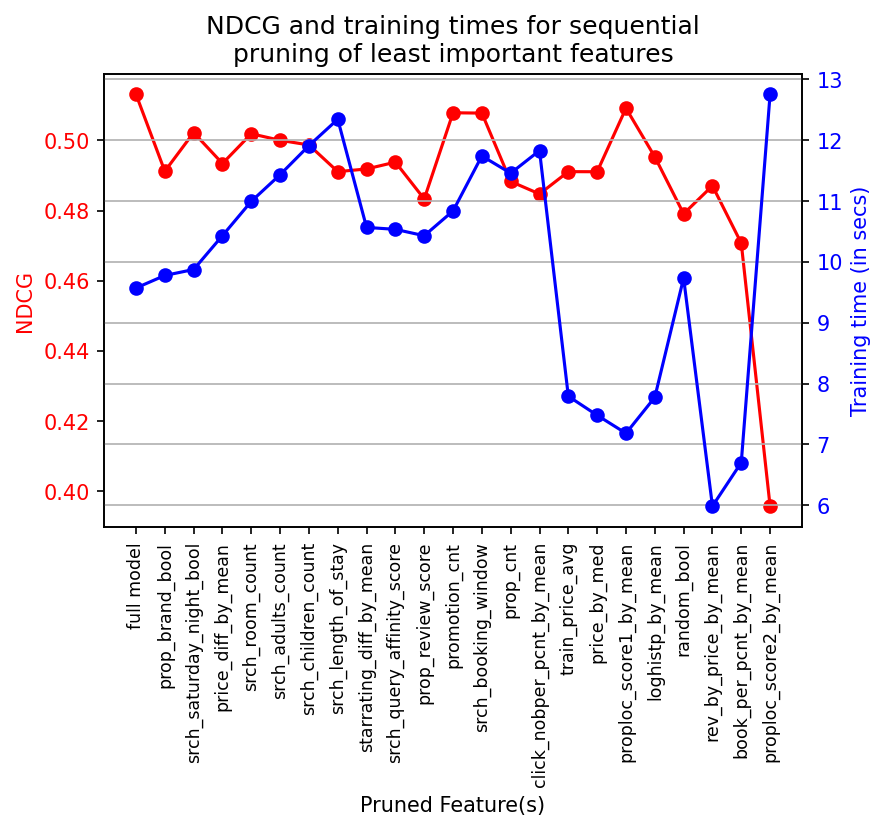

In [559]:
optimizer(train[:int(1e5)], features_to_prune = 22, return_data=False,small_train=True, verbose=True)

In [686]:
Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean' ,'star_by_price_by_mean', 
                    'random_bool' ,'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean',
                    'train_price_avg','price_by_med','click_nobper_pcnt_by_mean']

'''
Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean' ,'star_by_price_by_mean', 
                    'random_bool' ,'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean',
                    'train_price_avg'] -  RFC NDCG score of 0.513633(with norm.diffs-) with 1e5 data (train:valid = 7:3)  
                                       -  ADA NDCG score of 0.51959(with norm.diffs-) with 1e5 data (train:valid = 7:3)
                                       -  GradBoosting NDCG score of 0.51913(with norm.diffs-) with 1e5 data (train:valid = 7:3)
                                       -  Xgboost score of 0.6571(with norm.diffs-) with 1e5 data (train:valid = 7:3)
                                       
                                       
Selected_features= ['prop_review_score', 'random_bool', 'srch_children_count', 'srch_query_affinity_score',
                    'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 'star_by_price_by_mean', 'price_by_med']
'''

"\nSelected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean' ,'star_by_price_by_mean', \n                    'random_bool' ,'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean',\n                    'train_price_avg'] -  RFC NDCG score of 0.513633(with norm.diffs-) with 1e5 data (train:valid = 7:3)  \n                                       -  ADA NDCG score of 0.51959(with norm.diffs-) with 1e5 data (train:valid = 7:3)\n                                       -  GradBoosting NDCG score of 0.51913(with norm.diffs-) with 1e5 data (train:valid = 7:3)\n                                       -  Xgboost score of 0.6571(with norm.diffs-) with 1e5 data (train:valid = 7:3)\n                                       \n                                       \nSelected_features= ['prop_review_score', 'random_bool', 'srch_children_count', 'srch_query_affinity_score',\n                    'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 'star_by_price_by_mean', 'price_by_med'

In [687]:
Selected_features= ['proploc_score2_by_mean', 'book_per_pcnt_by_mean' ,'star_by_price_by_mean', 
                    'random_bool' ,'rev_by_price_by_mean', 'loghistp_by_mean', 'proploc_score1_by_mean',
                    'train_price_avg']

model_dict = {}
for i in range(20):
    
    GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
    model, ndcg = trainer(train[:int(1e5)], Selected_features, model = GradModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict[model]= ndcg
    
small_grad = max(model_dict, key=model_dict.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5148507849456277
Feature Importances:
[[0.2687841208356539, 'proploc_score2_by_mean'],
 [0.18165373721855263, 'random_bool'],
 [0.17287149725026857, 'book_per_pcnt_by_mean'],
 [0.17044717568261952, 'star_by_price_by_mean'],
 [0.07699759424268685, 'loghistp_by_mean'],
 [0.06374782490574807, 'rev_by_price_by_mean'],
 [0.033653238931040406, 'proploc_score1_by_mean'],
 [0.031844810933430036, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 7.38 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49770747288469
Feature Importances:
[[0.20441399952308534, 'star_by_price_by_mean'],
 [0.20029943492369287, 'proploc_score2_by_mean'],
 [0.19537147134968344, 'book_per_pcnt_by_mean'],
 [0.1578745005004363, 'random_bool'],
 [0.09905551224124844, 'loghistp_by_mean'],
 [0.05663213437136283, 'rev_by_price_by_mean'],
 [0.043612167814902424, 'proploc_score1_by_mean'],
 [0.042740779275588184, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.12 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4952964271233592
Feature Importances:
[[0.22306163922259012, 'proploc_score2_by_mean'],
 [0.18028719938946924, 'book_per_pcnt_by_mean'],
 [0.16978614338019202, 'star_by_price_by_mean'],
 [0.1662838434474452, 'random_bool'],
 [0.09153493188586515, 'loghistp_by_mean'],
 [0.07426662666300615, 'rev_by_price_by_mean'],
 [0.05319702084320272, 'proploc_score1_by_mean'],
 [0.04158259516822941, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 10.40 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5007018794291344
Feature Importances:
[[0.22495222260597386, 'proploc_score2_by_mean'],
 [0.21266168093954896, 'random_bool'],
 [0.18860031542075342, 'star_by_price_by_mean'],
 [0.1878844550311189, 'book_per_pcnt_by_mean'],
 [0.06685050320446818, 'loghistp_by_mean'],
 [0.05826381298757013, 'proploc_score1_by_mean'],
 [0.044749677974537674, 'rev_by_price_by_mean'],
 [0.01603733183602892, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 4.78 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5007817399771418
Feature Importances:
[[0.2038074354301922, 'star_by_price_by_mean'],
 [0.20153791108713584, 'proploc_score2_by_mean'],
 [0.16472904748774617, 'book_per_pcnt_by_mean'],
 [0.156496991872568, 'random_bool'],
 [0.09419889285571578, 'rev_by_price_by_mean'],
 [0.0860738095346923, 'loghistp_by_mean'],
 [0.0576626723529766, 'proploc_score1_by_mean'],
 [0.03549323937897313, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.38 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4947564983244435
Feature Importances:
[[0.2641589875748219, 'proploc_score2_by_mean'],
 [0.227136838638452, 'random_bool'],
 [0.2204191349990093, 'star_by_price_by_mean'],
 [0.17498359721659945, 'book_per_pcnt_by_mean'],
 [0.04116063248696956, 'loghistp_by_mean'],
 [0.03410998018463306, 'rev_by_price_by_mean'],
 [0.03085346174637522, 'proploc_score1_by_mean'],
 [0.007177367153139467, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 3.64 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5032997028110155
Feature Importances:
[[0.24753989941143023, 'proploc_score2_by_mean'],
 [0.20743188557532843, 'star_by_price_by_mean'],
 [0.20105998817283918, 'random_bool'],
 [0.13609977008459687, 'book_per_pcnt_by_mean'],
 [0.07528105808522854, 'loghistp_by_mean'],
 [0.048936226454338434, 'rev_by_price_by_mean'],
 [0.04379071399908272, 'proploc_score1_by_mean'],
 [0.03986045821715553, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 6.72 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.506995198907822
Feature Importances:
[[0.25247340130128637, 'proploc_score2_by_mean'],
 [0.1917829149347872, 'random_bool'],
 [0.18485124593611765, 'star_by_price_by_mean'],
 [0.1586468383756614, 'book_per_pcnt_by_mean'],
 [0.08250238722228645, 'loghistp_by_mean'],
 [0.0722612104624282, 'rev_by_price_by_mean'],
 [0.031687059377566947, 'proploc_score1_by_mean'],
 [0.02579494238986579, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.77 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.499182096362354
Feature Importances:
[[0.20711907394544887, 'proploc_score2_by_mean'],
 [0.20245080495686263, 'star_by_price_by_mean'],
 [0.20102292951723258, 'book_per_pcnt_by_mean'],
 [0.19105350423900122, 'random_bool'],
 [0.06628123761146441, 'loghistp_by_mean'],
 [0.06155312021187684, 'rev_by_price_by_mean'],
 [0.0429364012853604, 'proploc_score1_by_mean'],
 [0.027582928232753066, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 6.65 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5058292662710475
Feature Importances:
[[0.23154095882242312, 'proploc_score2_by_mean'],
 [0.21395723988017523, 'random_bool'],
 [0.1984318081480815, 'star_by_price_by_mean'],
 [0.1836970424333545, 'book_per_pcnt_by_mean'],
 [0.06020346799528609, 'loghistp_by_mean'],
 [0.04396788984988145, 'rev_by_price_by_mean'],
 [0.037454919092572404, 'proploc_score1_by_mean'],
 [0.030746673778225767, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.01 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49861183445355256
Feature Importances:
[[0.23995775686530493, 'proploc_score2_by_mean'],
 [0.17996056957665735, 'book_per_pcnt_by_mean'],
 [0.1750013129695823, 'star_by_price_by_mean'],
 [0.16109264458075778, 'random_bool'],
 [0.08560582015417106, 'loghistp_by_mean'],
 [0.08103269618539796, 'rev_by_price_by_mean'],
 [0.042884349421540166, 'proploc_score1_by_mean'],
 [0.03446485024658845, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 12.06 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5065858895200527
Feature Importances:
[[0.229608926949928, 'proploc_score2_by_mean'],
 [0.18901095783587596, 'book_per_pcnt_by_mean'],
 [0.17967281021558149, 'random_bool'],
 [0.17599366326594884, 'star_by_price_by_mean'],
 [0.08343548450619595, 'loghistp_by_mean'],
 [0.07865596907208557, 'rev_by_price_by_mean'],
 [0.03416421954348341, 'train_price_avg'],
 [0.029457968610900782, 'proploc_score1_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.45 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5031209418511939
Feature Importances:
[[0.23713621934076287, 'proploc_score2_by_mean'],
 [0.20379172223306177, 'random_bool'],
 [0.20007550196982524, 'book_per_pcnt_by_mean'],
 [0.185385079577103, 'star_by_price_by_mean'],
 [0.07782310915857067, 'loghistp_by_mean'],
 [0.048191001517551284, 'rev_by_price_by_mean'],
 [0.024589590038746435, 'train_price_avg'],
 [0.023007776164378668, 'proploc_score1_by_mean']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 4.67 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5088511414900246
Feature Importances:
[[0.24949958001317904, 'proploc_score2_by_mean'],
 [0.2142792930960295, 'random_bool'],
 [0.1819274874146464, 'star_by_price_by_mean'],
 [0.15872630827655593, 'book_per_pcnt_by_mean'],
 [0.07584996127325663, 'rev_by_price_by_mean'],
 [0.07021183808368532, 'loghistp_by_mean'],
 [0.02529472784843145, 'proploc_score1_by_mean'],
 [0.02421080399421579, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 5.46 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5054520746412287
Feature Importances:
[[0.22228527903545017, 'proploc_score2_by_mean'],
 [0.18597102366596227, 'book_per_pcnt_by_mean'],
 [0.1752479683770583, 'random_bool'],
 [0.17291904139546072, 'star_by_price_by_mean'],
 [0.09886713248048797, 'loghistp_by_mean'],
 [0.07536821860893787, 'rev_by_price_by_mean'],
 [0.03739426029100938, 'proploc_score1_by_mean'],
 [0.0319470761456334, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 9.28 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4944364155402187
Feature Importances:
[[0.23709655784949119, 'proploc_score2_by_mean'],
 [0.20623740693100162, 'star_by_price_by_mean'],
 [0.17085240537729618, 'book_per_pcnt_by_mean'],
 [0.1634418986575719, 'random_bool'],
 [0.083902771850927, 'loghistp_by_mean'],
 [0.06300634834916352, 'rev_by_price_by_mean'],
 [0.04139531183427889, 'proploc_score1_by_mean'],
 [0.034067299150269716, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.64 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5068628682631603
Feature Importances:
[[0.2435872803320258, 'proploc_score2_by_mean'],
 [0.24055800477817388, 'random_bool'],
 [0.20577437048232206, 'book_per_pcnt_by_mean'],
 [0.18471467762135968, 'star_by_price_by_mean'],
 [0.042163851262288804, 'rev_by_price_by_mean'],
 [0.03709714438051336, 'loghistp_by_mean'],
 [0.026212513023891208, 'proploc_score1_by_mean'],
 [0.01989215811942523, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 4.05 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5104910361756936
Feature Importances:
[[0.21912431110067065, 'proploc_score2_by_mean'],
 [0.2008284320111537, 'book_per_pcnt_by_mean'],
 [0.18684787485995688, 'star_by_price_by_mean'],
 [0.15891135948325344, 'random_bool'],
 [0.08152842145607805, 'loghistp_by_mean'],
 [0.06377913981571386, 'rev_by_price_by_mean'],
 [0.046642947042315086, 'proploc_score1_by_mean'],
 [0.042337514230858325, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 11.25 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5090216381414869
Feature Importances:
[[0.24228795583463633, 'proploc_score2_by_mean'],
 [0.18697777983220315, 'star_by_price_by_mean'],
 [0.17489317048287478, 'random_bool'],
 [0.15543730230641944, 'book_per_pcnt_by_mean'],
 [0.08389683305344867, 'rev_by_price_by_mean'],
 [0.07621655413111365, 'loghistp_by_mean'],
 [0.0474590319322444, 'proploc_score1_by_mean'],
 [0.0328313724270596, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training time = 8.75 sec
NDCG: 0.5139518720995807
Feature Importances:
[[0.21473029345568756, 'proploc_score2_by_mean'],
 [0.17520353014304868, 'star_by_price_by_mean'],
 [0.1666262092657746, 'book_per_pcnt_by_mean'],
 [0.15951700351407977, 'random_bool'],
 [0.09465990003800431, 'rev_by_price_by_mean'],
 [0.0871352204824883, 'loghistp_by_mean'],
 [0.05401239385526363, 'proploc_score1_by_mean'],
 [0.04811544924565311, 'train_price_avg']]
GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
Training 

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [688]:
model_dict[small_grad]

0.5148507849456277

In [679]:
model_dict = {}
for i in range(20):
    model, ndcg = trainer(train[:int(1e5)], Selected_features , model = None, target='booking_bool', 
                         print_factors = True, return_model = True, small_trainer=True)
    model_dict[model]=ndcg
    
small_rfc = max(model_dict, key=model_dict.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49502515283655296
Feature Importances:
[[0.1987103920339334, 'proploc_score2_by_mean'],
 [0.14263206415871632, 'book_per_pcnt_by_mean'],
 [0.13425342542632437, 'star_by_price_by_mean'],
 [0.1208100162598218, 'random_bool'],
 [0.08460514589927255, 'loghistp_by_mean'],
 [0.08140942535366084, 'rev_by_price_by_mean'],
 [0.0733482734596932, 'proploc_score1_by_mean'],
 [0.06162630560134785, 'train_price_avg'],
 [0.05712521522929919, 'price_by_med'],
 [0.04547973657793035, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.62 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.48683419575170805
Feature Importances:
[[0.19870067385758997, 'proploc_score2_by_mean'],
 [0.14969430986318352, 'book_per_pcnt_by_mean'],
 [0.13877972232306818, 'star_by_price_by_mean'],
 [0.11650686093943649, 'random_bool'],
 [0.08182486539675977, 'rev_by_price_by_mean'],
 [0.08132196068788525, 'loghistp_by_mean'],
 [0.06768625031334714, 'proploc_score1_by_mean'],
 [0.05987088876774693, 'train_price_avg'],
 [0.05979186660276559, 'price_by_med'],
 [0.045822601248217146, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.36 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4931868353944626
Feature Importances:
[[0.1965907520892645, 'proploc_score2_by_mean'],
 [0.14221784289260683, 'book_per_pcnt_by_mean'],
 [0.1405648925273497, 'star_by_price_by_mean'],
 [0.11863933192134335, 'random_bool'],
 [0.08758603196376963, 'rev_by_price_by_mean'],
 [0.07610512005064952, 'loghistp_by_mean'],
 [0.07148026958619305, 'proploc_score1_by_mean'],
 [0.06002771828185782, 'train_price_avg'],
 [0.05642505181904738, 'price_by_med'],
 [0.050362988867918235, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.45 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49494976738501023
Feature Importances:
[[0.21025975803649072, 'proploc_score2_by_mean'],
 [0.14120004784438206, 'book_per_pcnt_by_mean'],
 [0.13765229081596092, 'star_by_price_by_mean'],
 [0.11366944803970387, 'random_bool'],
 [0.09171297312735739, 'rev_by_price_by_mean'],
 [0.07485003592077921, 'loghistp_by_mean'],
 [0.07065541008334852, 'proploc_score1_by_mean'],
 [0.059072371390701324, 'train_price_avg'],
 [0.05455120598069852, 'price_by_med'],
 [0.04637645876057753, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.48 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5029705284893113
Feature Importances:
[[0.2002615066779192, 'proploc_score2_by_mean'],
 [0.14978361669292103, 'star_by_price_by_mean'],
 [0.1265646003910518, 'random_bool'],
 [0.1223857155425946, 'book_per_pcnt_by_mean'],
 [0.0839504114444399, 'loghistp_by_mean'],
 [0.07848543543766485, 'rev_by_price_by_mean'],
 [0.06563958572454455, 'train_price_avg'],
 [0.06490122312854281, 'proploc_score1_by_mean'],
 [0.061599032849284266, 'price_by_med'],
 [0.046428872111037016, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.28 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49665122451079086
Feature Importances:
[[0.1966203154013883, 'proploc_score2_by_mean'],
 [0.15762513097024203, 'book_per_pcnt_by_mean'],
 [0.12915538872751062, 'star_by_price_by_mean'],
 [0.11931656518846398, 'random_bool'],
 [0.08201596856627538, 'loghistp_by_mean'],
 [0.08146760363713962, 'rev_by_price_by_mean'],
 [0.06979445734682177, 'proploc_score1_by_mean'],
 [0.057109227826007504, 'train_price_avg'],
 [0.05411423350087541, 'price_by_med'],
 [0.052781108835275405, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.56 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4881469673281236
Feature Importances:
[[0.1987164710817851, 'proploc_score2_by_mean'],
 [0.15158039161051706, 'book_per_pcnt_by_mean'],
 [0.15008855123101167, 'star_by_price_by_mean'],
 [0.11446874369164244, 'random_bool'],
 [0.07692656196731919, 'loghistp_by_mean'],
 [0.07632413856274986, 'rev_by_price_by_mean'],
 [0.0675308759965722, 'proploc_score1_by_mean'],
 [0.061313592045434955, 'train_price_avg'],
 [0.053349589029859805, 'price_by_med'],
 [0.04970108478310771, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.42 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4885728832971372
Feature Importances:
[[0.19820567451790963, 'proploc_score2_by_mean'],
 [0.15369334547312427, 'book_per_pcnt_by_mean'],
 [0.139322981917159, 'star_by_price_by_mean'],
 [0.12446086306747503, 'random_bool'],
 [0.08756324575310623, 'rev_by_price_by_mean'],
 [0.07480291858440567, 'loghistp_by_mean'],
 [0.06869106898187063, 'proploc_score1_by_mean'],
 [0.05878063348591115, 'train_price_avg'],
 [0.0553520152638133, 'price_by_med'],
 [0.03912725295522518, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.49 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.495438741266704
Feature Importances:
[[0.1818107854430956, 'proploc_score2_by_mean'],
 [0.1604542937879316, 'book_per_pcnt_by_mean'],
 [0.15456459865109065, 'star_by_price_by_mean'],
 [0.12192046996478033, 'random_bool'],
 [0.08271978185736756, 'loghistp_by_mean'],
 [0.08184763482371872, 'rev_by_price_by_mean'],
 [0.05845141435638899, 'proploc_score1_by_mean'],
 [0.05458879301858137, 'train_price_avg'],
 [0.05294507948961296, 'click_nobper_pcnt_by_mean'],
 [0.050697148607432255, 'price_by_med']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.37 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5008821527047108
Feature Importances:
[[0.20231818699571222, 'proploc_score2_by_mean'],
 [0.1479675679858374, 'book_per_pcnt_by_mean'],
 [0.14690880799638953, 'star_by_price_by_mean'],
 [0.12388970762926886, 'random_bool'],
 [0.08485114190682813, 'loghistp_by_mean'],
 [0.07946333440603368, 'rev_by_price_by_mean'],
 [0.06365635061500853, 'proploc_score1_by_mean'],
 [0.055430283362022624, 'price_by_med'],
 [0.05406340627366512, 'train_price_avg'],
 [0.04145121282923398, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.15 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.509583380745135
Feature Importances:
[[0.19010719634312442, 'proploc_score2_by_mean'],
 [0.147849550065962, 'book_per_pcnt_by_mean'],
 [0.1412285011975318, 'star_by_price_by_mean'],
 [0.12598332254744143, 'random_bool'],
 [0.08660420810635389, 'loghistp_by_mean'],
 [0.07540895554488528, 'rev_by_price_by_mean'],
 [0.06490968901860852, 'proploc_score1_by_mean'],
 [0.0608644234319184, 'price_by_med'],
 [0.05996676093861854, 'train_price_avg'],
 [0.047077392805555805, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.25 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49446855034380455
Feature Importances:
[[0.20355407643867768, 'proploc_score2_by_mean'],
 [0.1522574654737398, 'book_per_pcnt_by_mean'],
 [0.13593897828383034, 'star_by_price_by_mean'],
 [0.12111163112805262, 'random_bool'],
 [0.08456771100152465, 'rev_by_price_by_mean'],
 [0.08060220163404731, 'loghistp_by_mean'],
 [0.06216158387046663, 'proploc_score1_by_mean'],
 [0.058250063490776036, 'train_price_avg'],
 [0.05240520549860689, 'price_by_med'],
 [0.04915108318027797, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.15 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5036920820418382
Feature Importances:
[[0.19533860250124846, 'proploc_score2_by_mean'],
 [0.14942083162117964, 'book_per_pcnt_by_mean'],
 [0.14401092468458013, 'star_by_price_by_mean'],
 [0.11555231324960527, 'random_bool'],
 [0.08344453563096325, 'loghistp_by_mean'],
 [0.08237450058711145, 'rev_by_price_by_mean'],
 [0.06629277704866826, 'proploc_score1_by_mean'],
 [0.05733915592463957, 'train_price_avg'],
 [0.05544325226455686, 'price_by_med'],
 [0.05078310648744723, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.35 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4862127339308543
Feature Importances:
[[0.19671188374589144, 'proploc_score2_by_mean'],
 [0.15586413326583348, 'book_per_pcnt_by_mean'],
 [0.14133609828834276, 'star_by_price_by_mean'],
 [0.11776879124510171, 'random_bool'],
 [0.08460888602018121, 'loghistp_by_mean'],
 [0.08158119041722267, 'rev_by_price_by_mean'],
 [0.06309478198348754, 'train_price_avg'],
 [0.062347877210442895, 'proploc_score1_by_mean'],
 [0.0532136113707547, 'price_by_med'],
 [0.04347274645274171, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.56 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5065852517753009
Feature Importances:
[[0.20486954876336588, 'proploc_score2_by_mean'],
 [0.14869522341596964, 'book_per_pcnt_by_mean'],
 [0.13565963533377887, 'star_by_price_by_mean'],
 [0.11463517168930908, 'random_bool'],
 [0.08173521901423537, 'rev_by_price_by_mean'],
 [0.07987332562959565, 'loghistp_by_mean'],
 [0.06645090522999793, 'proploc_score1_by_mean'],
 [0.05918204860583414, 'price_by_med'],
 [0.056709685347828734, 'train_price_avg'],
 [0.05218923697008487, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.43 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5058014374561587
Feature Importances:
[[0.20346519837448307, 'proploc_score2_by_mean'],
 [0.1483687340200873, 'book_per_pcnt_by_mean'],
 [0.14296912477498663, 'star_by_price_by_mean'],
 [0.12049241786686073, 'random_bool'],
 [0.08336973688883847, 'rev_by_price_by_mean'],
 [0.06969569334456172, 'proploc_score1_by_mean'],
 [0.06713127697684178, 'loghistp_by_mean'],
 [0.06120150172762029, 'train_price_avg'],
 [0.055195477208628, 'price_by_med'],
 [0.0481108388170922, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.54 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4984897345397756
Feature Importances:
[[0.20096420750363322, 'proploc_score2_by_mean'],
 [0.145098837658273, 'star_by_price_by_mean'],
 [0.13814341137047317, 'book_per_pcnt_by_mean'],
 [0.12353321516169365, 'random_bool'],
 [0.08203476101186606, 'rev_by_price_by_mean'],
 [0.07393645433025257, 'loghistp_by_mean'],
 [0.07244327237126602, 'proploc_score1_by_mean'],
 [0.062123705101020714, 'train_price_avg'],
 [0.05677944346770754, 'price_by_med'],
 [0.04494269202381403, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.70 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5048662946557748
Feature Importances:
[[0.19648674848290096, 'proploc_score2_by_mean'],
 [0.1445730776736797, 'star_by_price_by_mean'],
 [0.1374655659581879, 'book_per_pcnt_by_mean'],
 [0.1216637755173648, 'random_bool'],
 [0.08277080425003064, 'rev_by_price_by_mean'],
 [0.08032508419010177, 'loghistp_by_mean'],
 [0.07256827055894656, 'proploc_score1_by_mean'],
 [0.06172502452561716, 'train_price_avg'],
 [0.05789851554076578, 'price_by_med'],
 [0.04452313330240481, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.57 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4945138045578516
Feature Importances:
[[0.20779912120585184, 'proploc_score2_by_mean'],
 [0.14816782728945488, 'book_per_pcnt_by_mean'],
 [0.1445245340044807, 'star_by_price_by_mean'],
 [0.1184677430576596, 'random_bool'],
 [0.07922397858657494, 'loghistp_by_mean'],
 [0.07439463282652917, 'rev_by_price_by_mean'],
 [0.0664939355284249, 'proploc_score1_by_mean'],
 [0.058943138230005715, 'price_by_med'],
 [0.055481835277421496, 'train_price_avg'],
 [0.04650325399359676, 'click_nobper_pcnt_by_mean']]
RandomForestClassifier(min_samples_split=1000)
Training time = 10.96 sec
NDCG: 0.487877658635613
Feature Importances:
[[0.20148998318119482, 'proploc_score2_by_mean'],
 [0.15489112376368244, 'book_per_pcnt_by_mean'],
 [0.14206300217636073, 'star_by_price_by_mean'],
 [0.11811115078901732, 'random_bool'],
 [0.07643209063277459, 'rev_by_price_by_mean'],
 [0.07461994642980256, 'proploc_score1_by_mean'],
 [0.07417134246816424, 'loghistp_by_mean'],
 [0.0654168849794039, 'train_price_avg'],
 

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [680]:
model_dict[small_rfc]

0.509583380745135

In [352]:
pred_df = test_pred_sorted(test, small_rfc, cols = Selected_features)
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/Results_group77_rfc.csv', index=False)

In [677]:
model_dict = {}
for i in range(20):
    weaklearner = sk.tree.DecisionTreeClassifier(max_depth=1, min_samples_split=4)
    AdaModel = sk.ensemble.AdaBoostClassifier(base_estimator = weaklearner, n_estimators=100)
    model, ndcg = trainer(train[:int(1e5)], Selected_features , model = AdaModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict[model]= ndcg
    
small_ada = max(model_dict, key=model_dict.get)

<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5054084402697486
Feature Importances:
[[0.16, 'proploc_score2_by_mean'],
 [0.15, 'star_by_price_by_mean'],
 [0.12, 'price_by_med'],
 [0.11, 'rev_by_price_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.1, 'train_price_avg'],
 [0.08, 'proploc_score1_by_mean'],
 [0.08, 'loghistp_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 6.99 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5119527631055211
Feature Importances:
[[0.16, 'price_by_med'],
 [0.13, 'train_price_avg'],
 [0.13, 'star_by_price_by_mean'],
 [0.12, 'proploc_score2_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'proploc_score1_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.27 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4931908324529528
Feature Importances:
[[0.2, 'proploc_score2_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.13, 'price_by_med'],
 [0.11, 'train_price_avg'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.1, 'rev_by_price_by_mean'],
 [0.07, 'loghistp_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.06, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.04 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4984466881141323
Feature Importances:
[[0.16, 'proploc_score2_by_mean'],
 [0.14, 'star_by_price_by_mean'],
 [0.13, 'rev_by_price_by_mean'],
 [0.11, 'proploc_score1_by_mean'],
 [0.11, 'price_by_med'],
 [0.11, 'loghistp_by_mean'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.07, 'train_price_avg'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.09 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5044109267558256
Feature Importances:
[[0.17, 'star_by_price_by_mean'],
 [0.15, 'proploc_score2_by_mean'],
 [0.15, 'price_by_med'],
 [0.14, 'proploc_score1_by_mean'],
 [0.1, 'loghistp_by_mean'],
 [0.08, 'click_nobper_pcnt_by_mean'],
 [0.07, 'rev_by_price_by_mean'],
 [0.06, 'train_price_avg'],
 [0.06, 'book_per_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 6.83 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4904727328588689
Feature Importances:
[[0.16, 'price_by_med'],
 [0.15, 'star_by_price_by_mean'],
 [0.15, 'proploc_score2_by_mean'],
 [0.11, 'train_price_avg'],
 [0.11, 'loghistp_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.07, 'rev_by_price_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.05, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 6.90 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5109592378594654
Feature Importances:
[[0.18, 'proploc_score2_by_mean'],
 [0.16, 'price_by_med'],
 [0.13, 'star_by_price_by_mean'],
 [0.11, 'loghistp_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'rev_by_price_by_mean'],
 [0.08, 'click_nobper_pcnt_by_mean'],
 [0.07, 'proploc_score1_by_mean'],
 [0.05, 'train_price_avg'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.14 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49871654431351914
Feature Importances:
[[0.18, 'star_by_price_by_mean'],
 [0.15, 'price_by_med'],
 [0.14, 'proploc_score2_by_mean'],
 [0.11, 'rev_by_price_by_mean'],
 [0.11, 'book_per_pcnt_by_mean'],
 [0.09, 'click_nobper_pcnt_by_mean'],
 [0.08, 'loghistp_by_mean'],
 [0.07, 'train_price_avg'],
 [0.05, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 6.96 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49043305620398914
Feature Importances:
[[0.16, 'price_by_med'],
 [0.14, 'proploc_score2_by_mean'],
 [0.13, 'star_by_price_by_mean'],
 [0.13, 'loghistp_by_mean'],
 [0.12, 'train_price_avg'],
 [0.09, 'rev_by_price_by_mean'],
 [0.08, 'book_per_pcnt_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.06, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.40 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4900913184684444
Feature Importances:
[[0.18, 'proploc_score2_by_mean'],
 [0.16, 'star_by_price_by_mean'],
 [0.12, 'loghistp_by_mean'],
 [0.11, 'train_price_avg'],
 [0.11, 'rev_by_price_by_mean'],
 [0.09, 'price_by_med'],
 [0.08, 'proploc_score1_by_mean'],
 [0.07, 'book_per_pcnt_by_mean'],
 [0.06, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.20 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.5073692945853568
Feature Importances:
[[0.2, 'price_by_med'],
 [0.18, 'star_by_price_by_mean'],
 [0.15, 'proploc_score2_by_mean'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.08, 'rev_by_price_by_mean'],
 [0.08, 'proploc_score1_by_mean'],
 [0.07, 'train_price_avg'],
 [0.07, 'loghistp_by_mean'],
 [0.05, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.08 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4994301089807424
Feature Importances:
[[0.13, 'price_by_med'],
 [0.12, 'train_price_avg'],
 [0.12, 'proploc_score2_by_mean'],
 [0.12, 'loghistp_by_mean'],
 [0.11, 'star_by_price_by_mean'],
 [0.11, 'rev_by_price_by_mean'],
 [0.11, 'proploc_score1_by_mean'],
 [0.09, 'book_per_pcnt_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.36 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4949351095039034
Feature Importances:
[[0.16, 'proploc_score2_by_mean'],
 [0.15, 'star_by_price_by_mean'],
 [0.13, 'price_by_med'],
 [0.12, 'book_per_pcnt_by_mean'],
 [0.11, 'rev_by_price_by_mean'],
 [0.11, 'loghistp_by_mean'],
 [0.08, 'train_price_avg'],
 [0.08, 'click_nobper_pcnt_by_mean'],
 [0.04, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.24 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.502345123896971
Feature Importances:
[[0.18, 'star_by_price_by_mean'],
 [0.17, 'proploc_score2_by_mean'],
 [0.13, 'rev_by_price_by_mean'],
 [0.12, 'book_per_pcnt_by_mean'],
 [0.11, 'price_by_med'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'proploc_score1_by_mean'],
 [0.06, 'train_price_avg'],
 [0.04, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.06 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49321079277284907
Feature Importances:
[[0.16, 'proploc_score2_by_mean'],
 [0.15, 'star_by_price_by_mean'],
 [0.13, 'book_per_pcnt_by_mean'],
 [0.11, 'price_by_med'],
 [0.1, 'rev_by_price_by_mean'],
 [0.1, 'proploc_score1_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.08, 'train_price_avg'],
 [0.06, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.10 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49251521184754127
Feature Importances:
[[0.17, 'price_by_med'],
 [0.15, 'star_by_price_by_mean'],
 [0.12, 'rev_by_price_by_mean'],
 [0.12, 'loghistp_by_mean'],
 [0.11, 'train_price_avg'],
 [0.11, 'proploc_score2_by_mean'],
 [0.09, 'book_per_pcnt_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.04, 'proploc_score1_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.22 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.4839051369560565
Feature Importances:
[[0.16, 'star_by_price_by_mean'],
 [0.14, 'proploc_score2_by_mean'],
 [0.14, 'price_by_med'],
 [0.12, 'rev_by_price_by_mean'],
 [0.1, 'train_price_avg'],
 [0.1, 'loghistp_by_mean'],
 [0.1, 'book_per_pcnt_by_mean'],
 [0.08, 'proploc_score1_by_mean'],
 [0.04, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.14 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.501345642465996
Feature Importances:
[[0.17, 'proploc_score2_by_mean'],
 [0.16, 'star_by_price_by_mean'],
 [0.14, 'price_by_med'],
 [0.13, 'rev_by_price_by_mean'],
 [0.12, 'book_per_pcnt_by_mean'],
 [0.08, 'train_price_avg'],
 [0.08, 'loghistp_by_mean'],
 [0.07, 'click_nobper_pcnt_by_mean'],
 [0.04, 'proploc_score1_by_mean'],
 [0.01, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.16 sec


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


NDCG: 0.49275029851061336
Feature Importances:
[[0.15, 'proploc_score2_by_mean'],
 [0.12, 'train_price_avg'],
 [0.12, 'star_by_price_by_mean'],
 [0.12, 'book_per_pcnt_by_mean'],
 [0.11, 'loghistp_by_mean'],
 [0.1, 'proploc_score1_by_mean'],
 [0.1, 'click_nobper_pcnt_by_mean'],
 [0.09, 'price_by_med'],
 [0.07, 'rev_by_price_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 7.14 sec
NDCG: 0.497198800813803
Feature Importances:
[[0.2, 'price_by_med'],
 [0.17, 'proploc_score2_by_mean'],
 [0.13, 'book_per_pcnt_by_mean'],
 [0.12, 'star_by_price_by_mean'],
 [0.09, 'rev_by_price_by_mean'],
 [0.09, 'loghistp_by_mean'],
 [0.07, 'train_price_avg'],
 [0.07, 'proploc_score1_by_mean'],
 [0.04, 'click_nobper_pcnt_by_mean'],
 [0.02, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,


<ipython-input-568-9446a4240f98>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-568-9446a4240f98>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [678]:
model_dict[small_ada]

0.5119527631055211

In [367]:
pred_df = test_pred_sorted(test, small_ada, cols = Selected_features)
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results/Results_group77_ada.csv', index=False)

In [585]:
model_dict = {}
for i in range(20):
    _, _, small_train, small_valid = data_splitter(train[:int(1e5)], Selected_features, small_train=True)


    y_train = small_train['booking_bool'].values
    x_train = small_train[Selected_features].values
    y_valid = small_valid['booking_bool'].values
    x_valid = small_valid[Selected_features].values

    group_train = small_train.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values
    group_valid = small_valid.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values

    train_dmatrix = xgb.DMatrix(x_train, label = y_train)
    valid_dmatrix = xgb.DMatrix(x_valid, label = y_valid)

    train_dmatrix.set_group(group_train)
    valid_dmatrix.set_group(group_valid)

    params = {'objective': 'rank:ndcg', 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 5.127, 
              'max_depth': 2}
    params['eval_metric'] = ['ndcg']

    xgb_model = xgb.train(params, train_dmatrix, num_boost_round=999, evals=[(valid_dmatrix, 'Val')],
                          early_stopping_rounds=10)
    
    model_dict[xgb_model] = xgb_model.best_score

small_xgb = max(model_dict, key=model_dict.get)

[0]	Val-ndcg:0.60588
[1]	Val-ndcg:0.61639
[2]	Val-ndcg:0.61633
[3]	Val-ndcg:0.61633
[4]	Val-ndcg:0.61633
[5]	Val-ndcg:0.63073
[6]	Val-ndcg:0.63044
[7]	Val-ndcg:0.63051
[8]	Val-ndcg:0.63050
[9]	Val-ndcg:0.63068
[10]	Val-ndcg:0.63025
[11]	Val-ndcg:0.63040
[12]	Val-ndcg:0.63028
[13]	Val-ndcg:0.63025
[14]	Val-ndcg:0.63025
[0]	Val-ndcg:0.61354
[1]	Val-ndcg:0.61340
[2]	Val-ndcg:0.61340
[3]	Val-ndcg:0.61340
[4]	Val-ndcg:0.61374
[5]	Val-ndcg:0.61374
[6]	Val-ndcg:0.62687
[7]	Val-ndcg:0.63340
[8]	Val-ndcg:0.63371
[9]	Val-ndcg:0.63397
[10]	Val-ndcg:0.63398
[11]	Val-ndcg:0.63408
[12]	Val-ndcg:0.63407
[13]	Val-ndcg:0.63122
[14]	Val-ndcg:0.63214
[15]	Val-ndcg:0.63485
[16]	Val-ndcg:0.63701
[17]	Val-ndcg:0.63684
[18]	Val-ndcg:0.63684
[19]	Val-ndcg:0.63708
[20]	Val-ndcg:0.63675
[21]	Val-ndcg:0.63877
[22]	Val-ndcg:0.63894
[23]	Val-ndcg:0.64121
[24]	Val-ndcg:0.64291
[25]	Val-ndcg:0.64363
[26]	Val-ndcg:0.64441
[27]	Val-ndcg:0.64450
[28]	Val-ndcg:0.64712
[29]	Val-ndcg:0.64795
[30]	Val-ndcg:0.64873
[31]	Val

[89]	Val-ndcg:0.64242
[90]	Val-ndcg:0.64227
[91]	Val-ndcg:0.64204
[92]	Val-ndcg:0.64237
[93]	Val-ndcg:0.64190
[94]	Val-ndcg:0.64206
[95]	Val-ndcg:0.64228
[96]	Val-ndcg:0.64196
[97]	Val-ndcg:0.64228
[98]	Val-ndcg:0.64191
[99]	Val-ndcg:0.64263
[100]	Val-ndcg:0.64326
[101]	Val-ndcg:0.64324
[102]	Val-ndcg:0.64377
[103]	Val-ndcg:0.64341
[104]	Val-ndcg:0.64291
[105]	Val-ndcg:0.64343
[106]	Val-ndcg:0.64298
[107]	Val-ndcg:0.64264
[108]	Val-ndcg:0.64293
[109]	Val-ndcg:0.64332
[110]	Val-ndcg:0.64356
[111]	Val-ndcg:0.64296
[112]	Val-ndcg:0.64325
[0]	Val-ndcg:0.61071
[1]	Val-ndcg:0.61076
[2]	Val-ndcg:0.61076
[3]	Val-ndcg:0.61076
[4]	Val-ndcg:0.61076
[5]	Val-ndcg:0.61076
[6]	Val-ndcg:0.62973
[7]	Val-ndcg:0.63036
[8]	Val-ndcg:0.63041
[9]	Val-ndcg:0.63038
[10]	Val-ndcg:0.63035
[11]	Val-ndcg:0.63035
[12]	Val-ndcg:0.63035
[13]	Val-ndcg:0.63109
[14]	Val-ndcg:0.63268
[15]	Val-ndcg:0.63341
[16]	Val-ndcg:0.63323
[17]	Val-ndcg:0.63437
[18]	Val-ndcg:0.63468
[19]	Val-ndcg:0.63943
[20]	Val-ndcg:0.63851
[21]	Va

[10]	Val-ndcg:0.62774
[11]	Val-ndcg:0.62896
[12]	Val-ndcg:0.62899
[13]	Val-ndcg:0.62897
[14]	Val-ndcg:0.62928
[15]	Val-ndcg:0.62986
[16]	Val-ndcg:0.63442
[17]	Val-ndcg:0.63434
[18]	Val-ndcg:0.63694
[19]	Val-ndcg:0.63499
[20]	Val-ndcg:0.63443
[21]	Val-ndcg:0.63447
[22]	Val-ndcg:0.63561
[23]	Val-ndcg:0.63619
[24]	Val-ndcg:0.63510
[25]	Val-ndcg:0.63523
[26]	Val-ndcg:0.63554
[27]	Val-ndcg:0.63582
[0]	Val-ndcg:0.59078
[1]	Val-ndcg:0.59059
[2]	Val-ndcg:0.59092
[3]	Val-ndcg:0.59095
[4]	Val-ndcg:0.60757
[5]	Val-ndcg:0.61359
[6]	Val-ndcg:0.61316
[7]	Val-ndcg:0.61350
[8]	Val-ndcg:0.61299
[9]	Val-ndcg:0.61238
[10]	Val-ndcg:0.61356
[11]	Val-ndcg:0.61365
[12]	Val-ndcg:0.61442
[13]	Val-ndcg:0.61568
[14]	Val-ndcg:0.61562
[15]	Val-ndcg:0.61572
[16]	Val-ndcg:0.61561
[17]	Val-ndcg:0.61559
[18]	Val-ndcg:0.62559
[19]	Val-ndcg:0.62599
[20]	Val-ndcg:0.62667
[21]	Val-ndcg:0.62881
[22]	Val-ndcg:0.62936
[23]	Val-ndcg:0.62934
[24]	Val-ndcg:0.62888
[25]	Val-ndcg:0.62992
[26]	Val-ndcg:0.62932
[27]	Val-ndcg:0.6296

[39]	Val-ndcg:0.64199
[40]	Val-ndcg:0.64184
[41]	Val-ndcg:0.64133
[42]	Val-ndcg:0.64100
[43]	Val-ndcg:0.64170
[44]	Val-ndcg:0.64164
[45]	Val-ndcg:0.64155
[46]	Val-ndcg:0.64125
[47]	Val-ndcg:0.64190
[48]	Val-ndcg:0.64319
[49]	Val-ndcg:0.64305
[50]	Val-ndcg:0.64336
[51]	Val-ndcg:0.64322
[52]	Val-ndcg:0.64348
[53]	Val-ndcg:0.64313
[54]	Val-ndcg:0.64318
[55]	Val-ndcg:0.64292
[56]	Val-ndcg:0.64225
[57]	Val-ndcg:0.64214
[58]	Val-ndcg:0.64251
[59]	Val-ndcg:0.64315
[60]	Val-ndcg:0.64360
[61]	Val-ndcg:0.64343
[62]	Val-ndcg:0.64324
[63]	Val-ndcg:0.64384
[64]	Val-ndcg:0.64383
[65]	Val-ndcg:0.64470
[66]	Val-ndcg:0.64553
[67]	Val-ndcg:0.64517
[68]	Val-ndcg:0.64430
[69]	Val-ndcg:0.64552
[70]	Val-ndcg:0.64557
[71]	Val-ndcg:0.64555
[72]	Val-ndcg:0.64650
[73]	Val-ndcg:0.64600
[74]	Val-ndcg:0.64717
[75]	Val-ndcg:0.64747
[76]	Val-ndcg:0.64767
[77]	Val-ndcg:0.64693
[78]	Val-ndcg:0.64729
[79]	Val-ndcg:0.64694
[80]	Val-ndcg:0.64711
[81]	Val-ndcg:0.64707
[82]	Val-ndcg:0.64681
[83]	Val-ndcg:0.64650
[84]	Val-n

[96]	Val-ndcg:0.63826
[97]	Val-ndcg:0.63847
[98]	Val-ndcg:0.63948
[99]	Val-ndcg:0.64015
[100]	Val-ndcg:0.63995
[101]	Val-ndcg:0.63978
[102]	Val-ndcg:0.63944
[103]	Val-ndcg:0.63951
[104]	Val-ndcg:0.63902
[105]	Val-ndcg:0.63986
[106]	Val-ndcg:0.63996
[107]	Val-ndcg:0.63973
[108]	Val-ndcg:0.63970
[109]	Val-ndcg:0.64002
[0]	Val-ndcg:0.60117
[1]	Val-ndcg:0.60139
[2]	Val-ndcg:0.60138
[3]	Val-ndcg:0.60138
[4]	Val-ndcg:0.60141
[5]	Val-ndcg:0.60141
[6]	Val-ndcg:0.60141
[7]	Val-ndcg:0.62216
[8]	Val-ndcg:0.62368
[9]	Val-ndcg:0.62515
[10]	Val-ndcg:0.62512
[11]	Val-ndcg:0.62491
[12]	Val-ndcg:0.62603
[13]	Val-ndcg:0.62657
[14]	Val-ndcg:0.62463
[15]	Val-ndcg:0.62449
[16]	Val-ndcg:0.62502
[17]	Val-ndcg:0.62476
[18]	Val-ndcg:0.62412
[19]	Val-ndcg:0.62502
[20]	Val-ndcg:0.62446
[21]	Val-ndcg:0.62847
[22]	Val-ndcg:0.62789
[23]	Val-ndcg:0.62819
[24]	Val-ndcg:0.62771
[25]	Val-ndcg:0.62847
[26]	Val-ndcg:0.63092
[27]	Val-ndcg:0.63105
[28]	Val-ndcg:0.63008
[29]	Val-ndcg:0.63257
[30]	Val-ndcg:0.63407
[31]	Val-n

In [586]:
model_dict[small_xgb]

0.66355

In [690]:
x_test = test[Selected_features].values
test_dmatrix = xgb.DMatrix(x_test)

In [ ]:
pred = small_xgb.predict(test_dmatrix, iteration_range=(0, small_xgb.best_iteration))

pred_df = pd.DataFrame({'Scores':pred},index=test.index)
temp = pd.concat([test[['srch_id', 'prop_id']], pred_df], axis=1)
#temp.sort_values(by=['srch_id','Scores'],ascending=[True,False]).groupby('srch_id').count().max()

In [ ]:
Lamda_Res = temp.sort_values(by=['srch_id','Scores'],ascending=[True,False]).groupby('srch_id').head(38)[['srch_id', 'prop_id']]
Lamda_Res.to_csv('Results\Results_group77_Lambda.csv', index=False)

In [490]:
xgb_model.best_iteration

26

In [491]:
xgb_model.best_score

0.629976

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

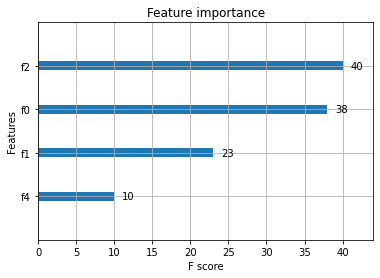

In [492]:
xgb.plot_importance(xgb_model)

In [224]:
# took a small train and validation set with 80:20 ratio.
#small_train= train[:int(4e5)]

#small_valid= train[:int(1e5)]
tloc1 = 3499709
tloc2 = int(tloc1+4e5)
vloc1= 4499608
vloc2 = int(vloc1+1e5)

In [230]:
small_train = train.loc[tloc1:tloc2,]
small_valid =  train.loc[vloc1:vloc2,]

NDCG: 0.4680889640205465
Feature Importances:
[[0.26425526174641645, 'book_per_pcnt_by_mean'],
 [0.21540149565013042, 'star_by_price_by_mean'],
 [0.15130947419625004, 'rev_by_price_by_mean'],
 [0.14941521116017414, 'random_bool'],
 [0.12930281072592367, 'price_by_med'],
 [0.04780414794107101, 'srch_query_affinity_score'],
 [0.029721062775627347, 'prop_review_score'],
 [0.012790535804406856, 'srch_children_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 46.25 sec


<ipython-input-2-a6f819f7c39b>:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['score'] = pred_scores
<ipython-input-2-a6f819f7c39b>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


## Create a small train and valid set

In [5]:
# took a small train and validation set with 80:20 ratio.
small_train= train[:int(4e5)]
Selected_features= ['prop_review_score', 'random_bool', 'srch_children_count', 'srch_query_affinity_score',
                    'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 'star_by_price_by_mean', 'price_by_med']
small_valid= valid[:int(1e5)]

## using XgBoost

In [235]:
small_valid

srch_id  prop_id  price_usd  prop_review_score  random_bool  \
row_num                                                                
4499608   301884    15047      75.00                2.0            0   
4499609   301884    17494      77.00                4.0            0   
4499610   301884    21712      65.00                3.0            0   
4499611   301884    23526     107.00                5.0            0   
4499612   301884    25368     109.00                3.5            0   
4499613   301884    25913     100.00                1.5            0   
4499614   301884    36363     204.00                4.0            0   
4499615   301884    39266      89.00                4.0            0   
4499616   301884    40948     159.00                4.5            0   
4499617   301884    44217     109.00                3.5            0   
4499618   301884    44574     125.00                4.0            0   
4499619   301884    48462     163.00                4.0            0   
4499620   301884    63161     109.00                4.5            0   
4499621   301884    70124     129.00                4.5            0   
4499622   301884    73724      82.00                4.5            0   
4499623   301884    75298     125.00                4.5            0   
4499624   301884    75822     146.00                4.5            0   
4499625   301884    81726     180.00                4.5            0   
4499626   301884    86840      84.00                4.0            0   
4499627   301884    89101     106.00                4.5            0   
4499628   301884    93717     169.00                4.0            0   
4499629   301884   103563      89.00                3.5            0   
4499630   301884   106301      79.00                3.0            0   
4499631   301884   108089      99.00                3.5            0   
4499632   301884   108668      89.00                2.0            0   
4499633   301884   109609     115.00                4.0            0   
4499634   301884   113223     111.00                4.5            0   
4499635   301884   119944      79.00                3.0            0   
4499636   301884   122748     143.00                4.0            0   
4499637   301884   123404     123.00                4.0            0   
...          ...      ...        ...                ...          ...   
4599579   308573   115835     194.97                4.0            0   
4599580   308573   117007     112.92                3.5            0   
4599581   308573   120079     125.49                4.0            0   
4599582   308573   120093     302.36                4.5            0   
4599583   308573   121984     116.19                4.5            0   
4599584   308573   133579     104.42                4.0            0   
4599585   308573   134594      72.29                3.5            0   
4599586   308573   135559     130.55                4.5            0   
4599587   308577     1707    1045.00                5.0            0   
4599588   308577     8962     219.00                4.0            0   
4599589   308577    11102     169.00                4.5            0   
4599590   308577    24559     334.00                4.5            0   
4599591   308577    25075     125.00                3.5            0   
4599592   308577    32887     309.00                4.0            0   
4599593   308577    33977     600.00                4.5            0   
4599594   308577    38291     220.00                4.0            0   
4599595   308577    38750     421.00                4.5            0   
4599596   308577    47179     299.00                4.5            0   
4599597   308577    62400     595.00                5.0            0   
4599598   308577    72492     475.00                5.0            0   
4599599   308577    84122     595.00                5.0            0   
4599600   308577   100685     475.00                4.5            0   
4599601   308577   126665     239.00             

In [236]:
y_train = small_train['booking_bool'].values
x_train = small_train[Selected_features].values
y_valid = small_valid['booking_bool'].values
x_valid = small_valid[Selected_features].values

group_train = small_train.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values
group_valid = small_valid.groupby('srch_id', sort=False).agg({'prop_id': 'size'})['prop_id'].values

train_dmatrix = xgb.DMatrix(x_train, label = y_train)
valid_dmatrix = xgb.DMatrix(x_valid, label = y_valid)

train_dmatrix.set_group(group_train)
valid_dmatrix.set_group(group_valid)

In [237]:
x_test = test[Selected_features].values
test_dmatrix = xgb.DMatrix(x_test)

In [238]:
params = {'objective': 'rank:ndcg', 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 5.127, 
          'max_depth': 2}
params['eval_metric'] = ['ndcg']

#params = {'objective': 'rank:ndcg'}
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=999, evals=[(valid_dmatrix, 'Val')],
                      early_stopping_rounds=10)

[0]	Val-ndcg:0.60554
[1]	Val-ndcg:0.60557
[2]	Val-ndcg:0.60554
[3]	Val-ndcg:0.60558
[4]	Val-ndcg:0.60574
[5]	Val-ndcg:0.60574
[6]	Val-ndcg:0.60640
[7]	Val-ndcg:0.60705
[8]	Val-ndcg:0.61276
[9]	Val-ndcg:0.61265
[10]	Val-ndcg:0.61536
[11]	Val-ndcg:0.61552
[12]	Val-ndcg:0.61585
[13]	Val-ndcg:0.61723
[14]	Val-ndcg:0.61718
[15]	Val-ndcg:0.61718
[16]	Val-ndcg:0.61765
[17]	Val-ndcg:0.62153
[18]	Val-ndcg:0.62168
[19]	Val-ndcg:0.62188
[20]	Val-ndcg:0.62195
[21]	Val-ndcg:0.62234
[22]	Val-ndcg:0.62326
[23]	Val-ndcg:0.62288
[24]	Val-ndcg:0.62309
[25]	Val-ndcg:0.62327
[26]	Val-ndcg:0.62369
[27]	Val-ndcg:0.62352
[28]	Val-ndcg:0.62382
[29]	Val-ndcg:0.62390
[30]	Val-ndcg:0.62422
[31]	Val-ndcg:0.62440
[32]	Val-ndcg:0.62416
[33]	Val-ndcg:0.62443
[34]	Val-ndcg:0.62444
[35]	Val-ndcg:0.62451
[36]	Val-ndcg:0.62510
[37]	Val-ndcg:0.62551
[38]	Val-ndcg:0.62566
[39]	Val-ndcg:0.62610
[40]	Val-ndcg:0.62648
[41]	Val-ndcg:0.62627
[42]	Val-ndcg:0.62614
[43]	Val-ndcg:0.62661
[44]	Val-ndcg:0.62650
[45]	Val-ndcg:0.6262

In [183]:
# Parameters that we are going to tune.
params = { 'max_depth':6, 'min_child_weight': 1, 'eta':.3,  'subsample': 1,  'colsample_bytree': 1, 
          'objective':'rank:ndcg'}

params['eval_metric'] = ['ndcg']
num_boost_round = 999

In [179]:
gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(1,8) for min_child_weight in np.linspace(0.1,8,12)]

In [180]:
gridsearch_params

[(1, 0.1),
 (1, 0.8181818181818182),
 (1, 1.5363636363636366),
 (1, 2.254545454545455),
 (1, 2.972727272727273),
 (1, 3.6909090909090914),
 (1, 4.409090909090909),
 (1, 5.127272727272727),
 (1, 5.845454545454546),
 (1, 6.563636363636364),
 (1, 7.281818181818182),
 (1, 8.0),
 (2, 0.1),
 (2, 0.8181818181818182),
 (2, 1.5363636363636366),
 (2, 2.254545454545455),
 (2, 2.972727272727273),
 (2, 3.6909090909090914),
 (2, 4.409090909090909),
 (2, 5.127272727272727),
 (2, 5.845454545454546),
 (2, 6.563636363636364),
 (2, 7.281818181818182),
 (2, 8.0),
 (3, 0.1),
 (3, 0.8181818181818182),
 (3, 1.5363636363636366),
 (3, 2.254545454545455),
 (3, 2.972727272727273),
 (3, 3.6909090909090914),
 (3, 4.409090909090909),
 (3, 5.127272727272727),
 (3, 5.845454545454546),
 (3, 6.563636363636364),
 (3, 7.281818181818182),
 (3, 8.0),
 (4, 0.1),
 (4, 0.8181818181818182),
 (4, 1.5363636363636366),
 (4, 2.254545454545455),
 (4, 2.972727272727273),
 (4, 3.6909090909090914),
 (4, 4.409090909090909),
 (4, 5.1272

In [181]:
max_ndcg = 0.5
best_params = None

for max_depth, min_child_weight in tqdm(gridsearch_params):
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(params, train_dmatrix, num_boost_round=num_boost_round, seed=42, nfold=5,
        metrics={'ndcg'}, early_stopping_rounds=10 )
    # Update best NDCG
    mean_ndcg = cv_results['test-ndcg-mean'].max()
    boost_rounds = cv_results['test-ndcg-mean'].idxmax()
    print("\tNDCG {} for {} rounds".format(mean_ndcg, boost_rounds))
    if mean_ndcg > max_ndcg:
        max_ndcg = mean_ndcg
        best_params = (max_depth, min_child_weight)
        
print("Best params: {}, {}, NDCG: {}".format(best_params[0], best_params[1], max_ndcg))

  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

CV with max_depth=1, min_child_weight=0.1


  1%|▉                                                                                  | 1/84 [00:24<33:28, 24.20s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=0.8181818181818182


  2%|█▉                                                                                 | 2/84 [00:49<34:07, 24.97s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=1.5363636363636366


  4%|██▉                                                                                | 3/84 [01:15<34:08, 25.30s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=2.254545454545455


  5%|███▉                                                                               | 4/84 [01:40<33:48, 25.36s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=2.972727272727273


  6%|████▉                                                                              | 5/84 [02:06<33:19, 25.31s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=3.6909090909090914


  7%|█████▉                                                                             | 6/84 [02:31<32:55, 25.32s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=4.409090909090909


  8%|██████▉                                                                            | 7/84 [02:57<32:50, 25.59s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=5.127272727272727


 10%|███████▉                                                                           | 8/84 [03:23<32:35, 25.73s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=5.845454545454546


 11%|████████▉                                                                          | 9/84 [03:50<32:46, 26.22s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=6.563636363636364


 12%|█████████▊                                                                        | 10/84 [04:17<32:21, 26.24s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=7.281818181818182


 13%|██████████▋                                                                       | 11/84 [04:42<31:43, 26.08s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=1, min_child_weight=8.0


 14%|███████████▋                                                                      | 12/84 [05:08<31:15, 26.05s/it]

	NDCG 0.6858332 for 107 rounds
CV with max_depth=2, min_child_weight=0.1


 15%|████████████▋                                                                     | 13/84 [06:00<40:00, 33.81s/it]

	NDCG 0.6877275999999999 for 132 rounds
CV with max_depth=2, min_child_weight=0.8181818181818182


 17%|█████████████▋                                                                    | 14/84 [06:49<44:55, 38.51s/it]

	NDCG 0.687652 for 126 rounds
CV with max_depth=2, min_child_weight=1.5363636363636366


 18%|██████████████▋                                                                   | 15/84 [07:46<50:24, 43.83s/it]

	NDCG 0.687948 for 145 rounds
CV with max_depth=2, min_child_weight=2.254545454545455


 19%|███████████████▌                                                                  | 16/84 [08:37<52:13, 46.08s/it]

	NDCG 0.6876287999999999 for 131 rounds
CV with max_depth=2, min_child_weight=2.972727272727273


 20%|████████████████▌                                                                 | 17/84 [09:30<53:57, 48.32s/it]

	NDCG 0.6878124 for 135 rounds
CV with max_depth=2, min_child_weight=3.6909090909090914


 21%|█████████████████▌                                                                | 18/84 [10:26<55:28, 50.43s/it]

	NDCG 0.6877078000000001 for 141 rounds
CV with max_depth=2, min_child_weight=4.409090909090909


 23%|██████████████████▌                                                               | 19/84 [11:20<55:52, 51.57s/it]

	NDCG 0.6877139999999999 for 139 rounds
CV with max_depth=2, min_child_weight=5.127272727272727


 24%|███████████████████▌                                                              | 20/84 [12:16<56:29, 52.97s/it]

	NDCG 0.6880680000000001 for 147 rounds
CV with max_depth=2, min_child_weight=5.845454545454546


 25%|████████████████████▌                                                             | 21/84 [12:50<49:36, 47.25s/it]

	NDCG 0.6862928 for 82 rounds
CV with max_depth=2, min_child_weight=6.563636363636364


 26%|█████████████████████▍                                                            | 22/84 [13:24<44:35, 43.16s/it]

	NDCG 0.6861882 for 82 rounds
CV with max_depth=2, min_child_weight=7.281818181818182


 27%|██████████████████████▍                                                           | 23/84 [13:57<40:59, 40.32s/it]

	NDCG 0.6861774 for 82 rounds
CV with max_depth=2, min_child_weight=8.0


 29%|███████████████████████▍                                                          | 24/84 [14:19<34:41, 34.69s/it]

	NDCG 0.6850456 for 44 rounds
CV with max_depth=3, min_child_weight=0.1


 30%|████████████████████████▍                                                         | 25/84 [14:48<32:27, 33.01s/it]

	NDCG 0.686065 for 44 rounds
CV with max_depth=3, min_child_weight=0.8181818181818182


 31%|█████████████████████████▍                                                        | 26/84 [15:25<32:59, 34.13s/it]

	NDCG 0.6866215999999999 for 60 rounds
CV with max_depth=3, min_child_weight=1.5363636363636366


 32%|██████████████████████████▎                                                       | 27/84 [16:01<33:00, 34.75s/it]

	NDCG 0.6864336000000001 for 60 rounds
CV with max_depth=3, min_child_weight=2.254545454545455


 33%|███████████████████████████▎                                                      | 28/84 [16:40<33:40, 36.08s/it]

	NDCG 0.6865859999999999 for 66 rounds
CV with max_depth=3, min_child_weight=2.972727272727273


 35%|████████████████████████████▎                                                     | 29/84 [17:27<35:56, 39.21s/it]

	NDCG 0.6870006 for 81 rounds
CV with max_depth=3, min_child_weight=3.6909090909090914


 36%|█████████████████████████████▎                                                    | 30/84 [18:06<35:11, 39.10s/it]

	NDCG 0.6868382000000001 for 65 rounds
CV with max_depth=3, min_child_weight=4.409090909090909


 37%|██████████████████████████████▎                                                   | 31/84 [18:35<32:04, 36.32s/it]

	NDCG 0.6863661999999999 for 46 rounds
CV with max_depth=3, min_child_weight=5.127272727272727


 38%|███████████████████████████████▏                                                  | 32/84 [19:20<33:44, 38.94s/it]

	NDCG 0.6865767999999999 for 78 rounds
CV with max_depth=3, min_child_weight=5.845454545454546


 39%|████████████████████████████████▏                                                 | 33/84 [19:50<30:46, 36.20s/it]

	NDCG 0.6863614 for 46 rounds
CV with max_depth=3, min_child_weight=6.563636363636364


 40%|█████████████████████████████████▏                                                | 34/84 [20:41<33:48, 40.57s/it]

	NDCG 0.6871156 for 89 rounds
CV with max_depth=3, min_child_weight=7.281818181818182


 42%|██████████████████████████████████▏                                               | 35/84 [21:36<36:41, 44.92s/it]

	NDCG 0.6872438000000001 for 96 rounds
CV with max_depth=3, min_child_weight=8.0


 43%|███████████████████████████████████▏                                              | 36/84 [22:14<34:16, 42.83s/it]

	NDCG 0.6872270000000001 for 62 rounds
CV with max_depth=4, min_child_weight=0.1


 44%|████████████████████████████████████                                              | 37/84 [22:37<28:56, 36.94s/it]

	NDCG 0.6859483999999999 for 23 rounds
CV with max_depth=4, min_child_weight=0.8181818181818182


 45%|█████████████████████████████████████                                             | 38/84 [23:01<25:15, 32.94s/it]

	NDCG 0.6859252 for 23 rounds
CV with max_depth=4, min_child_weight=1.5363636363636366


 46%|██████████████████████████████████████                                            | 39/84 [23:28<23:28, 31.30s/it]

	NDCG 0.68618 for 30 rounds
CV with max_depth=4, min_child_weight=2.254545454545455


 48%|███████████████████████████████████████                                           | 40/84 [24:18<27:03, 36.89s/it]

	NDCG 0.6871465999999999 for 65 rounds
CV with max_depth=4, min_child_weight=2.972727272727273


 49%|████████████████████████████████████████                                          | 41/84 [25:03<28:13, 39.37s/it]

	NDCG 0.6867501999999999 for 55 rounds
CV with max_depth=4, min_child_weight=3.6909090909090914


 50%|█████████████████████████████████████████                                         | 42/84 [25:46<28:16, 40.39s/it]

	NDCG 0.6865112 for 51 rounds
CV with max_depth=4, min_child_weight=4.409090909090909


 51%|█████████████████████████████████████████▉                                        | 43/84 [26:23<26:48, 39.24s/it]

	NDCG 0.686357 for 41 rounds
CV with max_depth=4, min_child_weight=5.127272727272727


 52%|██████████████████████████████████████████▉                                       | 44/84 [27:09<27:36, 41.41s/it]

	NDCG 0.6866510000000001 for 56 rounds
CV with max_depth=4, min_child_weight=5.845454545454546


 54%|███████████████████████████████████████████▉                                      | 45/84 [27:49<26:32, 40.83s/it]

	NDCG 0.6865195999999999 for 46 rounds
CV with max_depth=4, min_child_weight=6.563636363636364


 55%|████████████████████████████████████████████▉                                     | 46/84 [28:30<26:00, 41.08s/it]

	NDCG 0.6866931999999999 for 49 rounds
CV with max_depth=4, min_child_weight=7.281818181818182


 56%|█████████████████████████████████████████████▉                                    | 47/84 [29:26<27:58, 45.36s/it]

	NDCG 0.6867928 for 68 rounds
CV with max_depth=4, min_child_weight=8.0


 57%|██████████████████████████████████████████████▊                                   | 48/84 [30:12<27:23, 45.64s/it]

	NDCG 0.6868314 for 55 rounds
CV with max_depth=5, min_child_weight=0.1


 58%|███████████████████████████████████████████████▊                                  | 49/84 [30:57<26:28, 45.39s/it]

	NDCG 0.6876044 for 41 rounds
CV with max_depth=5, min_child_weight=0.8181818181818182


 60%|████████████████████████████████████████████████▊                                 | 50/84 [31:42<25:45, 45.46s/it]

	NDCG 0.6873722000000001 for 42 rounds
CV with max_depth=5, min_child_weight=1.5363636363636366


 61%|█████████████████████████████████████████████████▊                                | 51/84 [32:32<25:37, 46.58s/it]

	NDCG 0.6867905999999999 for 46 rounds
CV with max_depth=5, min_child_weight=2.254545454545455


 62%|██████████████████████████████████████████████████▊                               | 52/84 [33:21<25:17, 47.43s/it]

	NDCG 0.687269 for 47 rounds
CV with max_depth=5, min_child_weight=2.972727272727273


 63%|███████████████████████████████████████████████████▋                              | 53/84 [34:03<23:34, 45.64s/it]

	NDCG 0.6869614 for 38 rounds
CV with max_depth=5, min_child_weight=3.6909090909090914


 64%|████████████████████████████████████████████████████▋                             | 54/84 [34:48<22:51, 45.72s/it]

	NDCG 0.6865361999999999 for 45 rounds
CV with max_depth=5, min_child_weight=4.409090909090909


 65%|█████████████████████████████████████████████████████▋                            | 55/84 [35:20<20:01, 41.43s/it]

	NDCG 0.6864049999999999 for 28 rounds
CV with max_depth=5, min_child_weight=5.127272727272727


 67%|██████████████████████████████████████████████████████▋                           | 56/84 [35:52<18:01, 38.63s/it]

	NDCG 0.6867314 for 29 rounds
CV with max_depth=5, min_child_weight=5.845454545454546


 68%|███████████████████████████████████████████████████████▋                          | 57/84 [36:32<17:35, 39.09s/it]

	NDCG 0.6865712 for 39 rounds
CV with max_depth=5, min_child_weight=6.563636363636364


 69%|████████████████████████████████████████████████████████▌                         | 58/84 [37:14<17:17, 39.90s/it]

	NDCG 0.6865524 for 41 rounds
CV with max_depth=5, min_child_weight=7.281818181818182


 70%|█████████████████████████████████████████████████████████▌                        | 59/84 [38:03<17:44, 42.57s/it]

	NDCG 0.6870478 for 47 rounds
CV with max_depth=5, min_child_weight=8.0


 71%|██████████████████████████████████████████████████████████▌                       | 60/84 [38:45<17:03, 42.63s/it]

	NDCG 0.6870331999999999 for 38 rounds
CV with max_depth=6, min_child_weight=0.1


 73%|███████████████████████████████████████████████████████████▌                      | 61/84 [39:20<15:27, 40.33s/it]

	NDCG 0.6857892 for 22 rounds
CV with max_depth=6, min_child_weight=0.8181818181818182


 74%|████████████████████████████████████████████████████████████▌                     | 62/84 [39:57<14:19, 39.09s/it]

	NDCG 0.6856548 for 23 rounds
CV with max_depth=6, min_child_weight=1.5363636363636366


 75%|█████████████████████████████████████████████████████████████▌                    | 63/84 [40:50<15:13, 43.48s/it]

	NDCG 0.686233 for 39 rounds
CV with max_depth=6, min_child_weight=2.254545454545455


 76%|██████████████████████████████████████████████████████████████▍                   | 64/84 [41:39<15:00, 45.03s/it]

	NDCG 0.686145 for 34 rounds
CV with max_depth=6, min_child_weight=2.972727272727273


 77%|███████████████████████████████████████████████████████████████▍                  | 65/84 [42:03<12:18, 38.86s/it]

	NDCG 0.6856448 for 10 rounds
CV with max_depth=6, min_child_weight=3.6909090909090914


 79%|████████████████████████████████████████████████████████████████▍                 | 66/84 [42:52<12:31, 41.74s/it]

	NDCG 0.6868334 for 32 rounds
CV with max_depth=6, min_child_weight=4.409090909090909


 80%|█████████████████████████████████████████████████████████████████▍                | 67/84 [43:31<11:38, 41.08s/it]

	NDCG 0.6861636 for 17 rounds
CV with max_depth=6, min_child_weight=5.127272727272727


 81%|██████████████████████████████████████████████████████████████████▍               | 68/84 [44:27<12:06, 45.41s/it]

	NDCG 0.6864088 for 29 rounds
CV with max_depth=6, min_child_weight=5.845454545454546


 82%|███████████████████████████████████████████████████████████████████▎              | 69/84 [45:20<11:56, 47.76s/it]

	NDCG 0.6862007999999999 for 26 rounds
CV with max_depth=6, min_child_weight=6.563636363636364


 83%|████████████████████████████████████████████████████████████████████▎             | 70/84 [46:09<11:13, 48.13s/it]

	NDCG 0.6863933999999999 for 23 rounds
CV with max_depth=6, min_child_weight=7.281818181818182


 85%|█████████████████████████████████████████████████████████████████████▎            | 71/84 [47:16<11:37, 53.63s/it]

	NDCG 0.6868002000000001 for 36 rounds
CV with max_depth=6, min_child_weight=8.0


 86%|██████████████████████████████████████████████████████████████████████▎           | 72/84 [48:22<11:30, 57.56s/it]

	NDCG 0.6863438000000001 for 36 rounds
CV with max_depth=7, min_child_weight=0.1


 87%|███████████████████████████████████████████████████████████████████████▎          | 73/84 [49:19<10:30, 57.31s/it]

	NDCG 0.6834624 for 23 rounds
CV with max_depth=7, min_child_weight=0.8181818181818182


 88%|████████████████████████████████████████████████████████████████████████▏         | 74/84 [50:07<09:03, 54.37s/it]

	NDCG 0.6836072 for 17 rounds
CV with max_depth=7, min_child_weight=1.5363636363636366


 89%|█████████████████████████████████████████████████████████████████████████▏        | 75/84 [50:45<07:25, 49.55s/it]

	NDCG 0.6835669999999999 for 11 rounds
CV with max_depth=7, min_child_weight=2.254545454545455


 90%|██████████████████████████████████████████████████████████████████████████▏       | 76/84 [51:22<06:05, 45.73s/it]

	NDCG 0.6841484 for 10 rounds
CV with max_depth=7, min_child_weight=2.972727272727273


 92%|███████████████████████████████████████████████████████████████████████████▏      | 77/84 [52:15<05:35, 47.89s/it]

	NDCG 0.683621 for 20 rounds
CV with max_depth=7, min_child_weight=3.6909090909090914


 93%|████████████████████████████████████████████████████████████████████████████▏     | 78/84 [52:53<04:30, 45.03s/it]

	NDCG 0.6844044 for 11 rounds
CV with max_depth=7, min_child_weight=4.409090909090909


 94%|█████████████████████████████████████████████████████████████████████████████     | 79/84 [53:31<03:34, 42.89s/it]

	NDCG 0.6838398 for 11 rounds
CV with max_depth=7, min_child_weight=5.127272727272727


 95%|██████████████████████████████████████████████████████████████████████████████    | 80/84 [54:10<02:47, 41.88s/it]

	NDCG 0.6840961999999999 for 12 rounds
CV with max_depth=7, min_child_weight=5.845454545454546


 96%|███████████████████████████████████████████████████████████████████████████████   | 81/84 [54:48<02:02, 40.68s/it]

	NDCG 0.6840774 for 11 rounds
CV with max_depth=7, min_child_weight=6.563636363636364


 98%|████████████████████████████████████████████████████████████████████████████████  | 82/84 [55:31<01:22, 41.33s/it]

	NDCG 0.6845826 for 14 rounds
CV with max_depth=7, min_child_weight=7.281818181818182


 99%|█████████████████████████████████████████████████████████████████████████████████ | 83/84 [56:19<00:43, 43.24s/it]

	NDCG 0.6845034 for 17 rounds
CV with max_depth=7, min_child_weight=8.0


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [57:29<00:00, 41.06s/it]

	NDCG 0.6848798 for 32 rounds
Best params: 2, 5.127272727272727, NDCG: 0.6880680000000001


In [184]:
params['max_depth'] = 2
params['min_child_weight'] = 5.127

In [186]:
gridsearch_params = [(subsample, colsample) for subsample in [i/10. for i in range(5,11)] 
                     for colsample in [i/10. for i in range(5,11)]]

In [190]:
max_ndcg = 0.5
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format( subsample, colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv( params, train_dmatrix,  num_boost_round=num_boost_round, seed=42,
        nfold=5, metrics={'ndcg'},  early_stopping_rounds=10)
    # Update best NDCG
    mean_ndcg = cv_results['test-ndcg-mean'].max()
    boost_rounds = cv_results['test-ndcg-mean'].idxmax()
    print("\tNDCG {} for {} rounds".format(mean_ndcg, boost_rounds))
    if mean_ndcg > max_ndcg:
        max_ndcg = mean_ndcg
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, NDCG: {}".format(best_params[0], best_params[1], max_ndcg))

CV with subsample=1.0, colsample=1.0
	NDCG 0.6880680000000001 for 147 rounds
CV with subsample=1.0, colsample=0.9
	NDCG 0.6860818 for 62 rounds
CV with subsample=1.0, colsample=0.8
	NDCG 0.6860078000000001 for 51 rounds
CV with subsample=1.0, colsample=0.7
	NDCG 0.686496 for 50 rounds
CV with subsample=1.0, colsample=0.6
	NDCG 0.6860326000000001 for 63 rounds
CV with subsample=1.0, colsample=0.5
	NDCG 0.6860326000000001 for 63 rounds
CV with subsample=0.9, colsample=1.0
	NDCG 0.6861908000000001 for 76 rounds
CV with subsample=0.9, colsample=0.9
	NDCG 0.6872436 for 82 rounds
CV with subsample=0.9, colsample=0.8
	NDCG 0.6880040000000001 for 102 rounds
CV with subsample=0.9, colsample=0.7
	NDCG 0.6861870000000001 for 60 rounds
CV with subsample=0.9, colsample=0.6
	NDCG 0.6870681999999999 for 109 rounds
CV with subsample=0.9, colsample=0.5
	NDCG 0.6870681999999999 for 109 rounds
CV with subsample=0.8, colsample=1.0
	NDCG 0.6868369999999999 for 77 rounds
CV with subsample=0.8, colsample=0.9

In [239]:
pred = xgb_model.predict(test_dmatrix)

In [240]:
pred_df = pd.DataFrame({'Scores':pred},index=test.index)

In [241]:
temp = pd.concat([test[['srch_id', 'prop_id']], pred_df], axis=1)

In [242]:
LambdaMart_Results = temp.sort_values(by=['srch_id','Scores'],ascending=[True,False]).groupby('srch_id').head(38)[['srch_id', 'prop_id']]

In [243]:
LambdaMart_Results.to_csv('Results\Results_group77_Lambda.csv', index=False)

## Using RandomForest , ADABoost

In [36]:
# with small train and small validation set
small_RFC = trainer(small_train, small_valid,Selected_features, model = None, print_factors = True,
                              return_model = True, target='booking_bool')

NDCG: 0.6179798912695414
Feature Importances:
[[0.5412904817044031, 'book_per_pcnt_by_mean'],
 [0.12787240976145983, 'random_bool'],
 [0.12037351758644185, 'star_by_price_by_mean'],
 [0.08854617235958843, 'rev_by_price_by_mean'],
 [0.06997929916667299, 'price_by_med'],
 [0.0262826033777975, 'srch_query_affinity_score'],
 [0.017181888236447482, 'prop_review_score'],
 [0.008473627807188976, 'srch_children_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 65.61 sec


<ipython-input-30-09c582ac59b6>:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-30-09c582ac59b6>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [38]:
# with small train and small validation set and click_bool as target
small_RFC_click = trainer(small_train, small_valid,Selected_features, model = None, print_factors = True,
                              return_model = True, target='click_bool')

NDCG: 0.618811215110603
Feature Importances:
[[0.5297740205883469, 'book_per_pcnt_by_mean'],
 [0.16142701691263292, 'star_by_price_by_mean'],
 [0.10752190144227518, 'rev_by_price_by_mean'],
 [0.09631807037384751, 'price_by_med'],
 [0.035665945318535085, 'srch_query_affinity_score'],
 [0.03495435024078678, 'random_bool'],
 [0.022430092448338084, 'prop_review_score'],
 [0.011908602675237596, 'srch_children_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 50.19 sec


<ipython-input-30-09c582ac59b6>:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-30-09c582ac59b6>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [37]:
# with small trainset and full validation set 
small_RFC_fullvalid = trainer(small_train, valid,Selected_features, model = None, print_factors = True,
                              return_model = True, target='booking_bool')

<ipython-input-30-09c582ac59b6>:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores


NDCG: 0.6227540406981029
Feature Importances:
[[0.5418503547400495, 'book_per_pcnt_by_mean'],
 [0.12562236738682156, 'random_bool'],
 [0.12090220860755645, 'star_by_price_by_mean'],
 [0.08725708204360659, 'rev_by_price_by_mean'],
 [0.07059261481323795, 'price_by_med'],
 [0.028071930478582127, 'srch_query_affinity_score'],
 [0.01719093487290251, 'prop_review_score'],
 [0.008512507057243452, 'srch_children_count']]
RandomForestClassifier(min_samples_split=1000)
Training time = 44.31 sec


<ipython-input-30-09c582ac59b6>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [46]:
# ADABoost with small train and small valid

weaklearner = sk.tree.DecisionTreeClassifier(max_depth=1, min_samples_split=4)

AdaModel = sk.ensemble.AdaBoostClassifier(base_estimator = weaklearner, n_estimators=100)

small_ADA = trainer(small_train, small_valid, Selected_features , model = AdaModel, print_factors = True,
                              return_model = True, target='booking_bool')

NDCG: 0.6210536294628218
Feature Importances:
[[0.43, 'book_per_pcnt_by_mean'],
 [0.17, 'price_by_med'],
 [0.15, 'star_by_price_by_mean'],
 [0.1, 'rev_by_price_by_mean'],
 [0.08, 'srch_query_affinity_score'],
 [0.04, 'prop_review_score'],
 [0.02, 'srch_children_count'],
 [0.01, 'random_bool']]
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_split=4),
                   n_estimators=100)
Training time = 27.71 sec


<ipython-input-45-a6f819f7c39b>:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores
<ipython-input-45-a6f819f7c39b>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


In [ ]:
pred_df = test_pred_sorted(test_df, small_model, cols = Selected_features)
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results_group77_2.csv', index=False)

## NDCG Scores & runtimes when sequentially pruning the least important features 

In [268]:
def optimizer(df, features_to_prune = 5, return_data=False):
    
    train_len = df.shape[0]
    val_len = 0.25*train_len
    # exclude the target and other unnecessary columns
    cols = [col for col in df.columns if col not in ['srch_id', 'prop_id','booking_bool','click_bool']]
    
    NDCG , pruned_features, comp_times = [], [], []
    #because the 1st iteration is for the full model , run the iteration with features_to_prune + 1
    for i in tqdm(range(0,features_to_prune+1)):
       
        tic = time()
        ndcg, feature_list = trainer2(df, cols,train_loc2 = int(3499709+train_len-1), cv_loc2 = int(4499608+val_len-1), 
                                      model = None, print_factors = False, return_model = False, target='booking_bool')
        toc = time()
        pruned = feature_list[-1][1]
        
        NDCG.append(ndcg)
        comp_times.append(toc-tic)
        pruned_features.append(pruned)
        
        cols = [j for j in cols if j not in [pruned]]
    
    pruned_features.insert(0,'full model')
    pruned_features = pruned_features[0:-1]
    
    #plotter
    fig, ax1 = plt.subplots(dpi=150)

    x = np.arange(0,len(pruned_features))
    labels = pruned_features

    ax1.set_xticks(range(0,len(pruned_features)))
    ax1.set_xticklabels(labels, rotation=90,fontsize='small')

    ax1.set_xlabel('Pruned Feature(s)')
    ax1.set_ylabel('NDCG', color='red')
    ax1.plot(x, NDCG, 'ro-')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx() 

    ax2.set_ylabel('Training time (in secs)', color='blue') 
    ax2.plot(x, comp_times, 'bo-')
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.title('NDCG and training times for sequential'+'\n'+'pruning of least important features')
    plt.grid()
    
    if return_data:
        return NDCG, pruned_features, comp_times

In [ ]:
# using the small train set
optimizer(small_trainset,features_to_prune = 3)

## Further work

1. Implement other algorithms like LAMBDAMART, ADABOOST, Neural Networks and compare the NDCG scores and training times.
2. In tree based algrithms, feature importances are derived from impurity based importances which may give biased results and favour high caridnality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories. We should check the more general permutation-based feature importances that do not exhibit such a bias.

## SC additions

In [ ]:
train_df= clean_df.copy()

In [ ]:
train_df['Relevance_target']= train_df['click_bool']*1
train_df['Relevance_target']+= train_df['booking_bool']*4

In [ ]:
df= train_df.copy()[:int(1e4)]
df.shape

In [ ]:
Target_features= ['click_bool', 'booking_bool', 'Relevance_target']
Selected_features= df.columns.drop(Target_features)

# Separate target from predictors
y = df[['srch_id']+Target_features]
X = df[Selected_features]

# Divide data into training and validation subsets
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, groups=df['srch_id']))
X_train = X.iloc[train_inds]
X_valid = X.iloc[test_inds]
y_train = y.iloc[train_inds]
y_valid = y.iloc[test_inds]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = MinMaxScaler()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, Selected_features),
    ])

model = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
# model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', model)
                        ])

In [ ]:
# fit model 
tic= time.time()
pipeline.fit(X_train, y_train['Relevance_target'])
toc= time.time()
print('Training time is', toc-tic)

model= pipeline['model']

In [ ]:
# Get predictions
if hasattr(model, 'predict_proba'):
    preds = model.predict_proba(X_valid)[:, 1]
else:
    preds = model.predict(X_valid)

ndcg= ndcg_calc(y_valid, preds)

print('NDCG is', ndcg)

### Sequential Feature Selection(SFS)

SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. This can done either in a forward and backward manner. In a forward SFS we start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the $\text{n_features_to_select}$ parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. 

Paper about this- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf

In [ ]:
Estimator = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = svm.SVR()

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='forward').fit(X_train, y_train['Relevance_target'])
toc_fwd = time.time()

tic_bwd = time.time()
sfs_backward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='backward').fit(X_train, y_train['Relevance_target'])
toc_bwd = time.time()

print("Features selected by forward sequential selection: "f"{X_train.columns[sfs_forward.get_support()].tolist()}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "f"{X_train.columns[sfs_backward.get_support()].tolist()}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

### Tree Based Feature Selection

Tree-based models assign weights to the features using feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.

Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions predictions and can be used to analyze any model class (not just tree-based models).

More about this:  https://scikit-learn.org/stable/modules/permutation_importance.html#id2

Paper:  L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001. https://doi.org/10.1023/A:1010933404324

In [ ]:
tree_feature_importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]

feature_names = X_train.columns.values #np.r_[feature_names, numerical_columns]

#tree_feature_importances = ( rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort().tolist()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=[12,8])
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()
#fig.savefig('rfr_importance.png', dpi = 200)

## Full model test set predictions:

In [ ]:
def df_from_query(row_start = 3499709, row_end = 4958347, training = True, srch_start = None, srch_end = None):
    """
    >>df_from_query(row_start = 7000014, row_end = 9917530, training = True, srch_start = None, srch_end = None)
      row_start,row_end: Row number range (inclusive) to request from MySQL db (faster than srch_start,srch_end)
      srch_start,srch_end: Search ID range (inclusive) to request (slower than by row_start,row_end)
      training: BOOL, to pull from Training data set to True, set to False for Test data.
    
    Query local MySQL database, (see dbcon, below for permissions) to build a pd.DataFrame for training/testing.
    
    Several columns depend on summary statistics about Properties in the PropFactors/PropFactors7M tables in the
    database.  The "7M" suffix denotes summary statistics from the first 7000013 rows which for training
    are used with the latter ~3M rows. (This is to have these latter rows more closely resemble the test set, since some 
    properties only appear a few times so the "booking_cnt" statistic is an overly strong signal if it includes 
    information from the row that is being used for training.)  However for building the Test Set predictions, it
    is better to use statistics from the entire training set.
    Since some properties will appear in the training/test sets but not among the summary sets, columns that depend
    on these statistics are set to zero.
    Can select data by row_num or srch_id (row_num is the primary key so is faster, but it may be preferrable to 
    select by srch_id where splitting searches between chunks could cause problems, like when compiling test data).
    The presence of srch_start and srch_end overrides row_start/row_end.
    
    
    """
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    #print('Run Ok')
    # MySQL server, user, password, and database

    main_cols = "SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, srch_children_count, srch_length_of_stay, srch_query_affinity_score, srch_room_count, visitor_hist_adr_usd, (prop_starrating / price_usd) AS star_by_price, (prop_review_score / price_usd) AS rev_by_price"

    agg_cols = ", prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price, ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt"

    agg_missing = ", 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS promo_per_procnt, 0 AS avg_by_price, 0 AS click_nobook_per_pcnt"

    if training:
        from_tables1 = ", booking_bool, click_bool FROM TrainSearch AS s, PropFactors3M AS p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors3M"
    else:
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"

    if (srch_start is not None) or (srch_end is not None):
        if (srch_start is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_start = None")
        elif (srch_end is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_end = None")
        else: 
            where_str = " AND srch_id >= " + str(srch_start) + " AND srch_id <= " + str(srch_end) + ";"
    else:
        where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"

    train_dfmost = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id" + where_str, con = dbcon, index_col = 'row_num')
    # DataFrame.to_sql(name, con, schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None, method=None)
    train_dfpropmissing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + missing_from_table + ")" + where_str, con = dbcon, index_col = 'row_num')
    
    dbcon.close()
    
    #display(train_dfmost.head(3))
    #print(train_dfmost.shape)
    #display(train_dfpropmissing.head(3))
    #print(train_dfpropmissing.shape)

    train_df = pd.concat([train_dfmost, train_dfpropmissing])
    train_df.sort_values(by='row_num',inplace = True)
    
    
    train_df.fillna(value = 0, inplace = True)

    return train_df

def trainer2(df, Selected_features, Target_features=Target_features, model=None, target='Relevance_target', return_model=True):
    
    if Selected_features == None:
        Selected_features= Default_features

    # Separate target from predictors
    y = df[['srch_id']+Target_features]
    X = df[Selected_features]

    # Divide data into training and validation subsets
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, groups=df['srch_id']))
    X_train = X.iloc[train_inds]
    X_valid = X.iloc[test_inds]
    y_train = y.iloc[train_inds]
    y_valid = y.iloc[test_inds]

    # Preprocessing for numerical data
    numerical_transformer = MinMaxScaler()

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, Selected_features),
        ])

    if model== None:
#         model = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
        model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)

    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)
                            ])  
    # fit model 
    tic= time.time()
    pipeline.fit(X_train, y_train[target])
    toc= time.time()
    print('Training time is', toc-tic)

    model= pipeline['model']
    
    if return_model== True:
        return model
    else:
        return pipeline

def get_predictions(model, X_valid, y_valid=None, Selected_features= Selected_features):
    
    tic= time.time()
    if hasattr(model, 'predict_proba'):
        preds = model.predict_proba(X_valid[Selected_features])[:, 1]
    else:
        preds = model.predict(X_valid[Selected_features])
    toc= time.time()
    print('Prediction time is', toc-tic)
    
    X_valid['sort_score'] = preds

    pred_df= X_valid[['srch_id', 'prop_id', 'sort_score']].sort_values(by=['srch_id', 'sort_score'], ascending = [True, False])
    
    ndcg= None
    if y_valid!= None:
        ndcg= ndcg_calc(y_valid, preds)
        print('NDCG is', ndcg)
    
    return pred_df, ndcg

def agg_by_srch(train_df):
    """
    >>agg_by_srch(train_df)
    
    Given a training/testing dataset that includes the columns listed in cols_in below, calculate
    new columns that normalize these values among the search in which they appear by dividing by
    the mean (or median for 'price_usd' since it has higher variance).  i.e. given prop_location_score "j"
    for search "i" add column: prop_location_score[i][j] / mean(prop_location_score[i])
    """
    
    cols_in = ['prop_location_score1', 
               'prop_location_score2', 
               'book_per_pcnt', 
               'avg_by_price', 
               'rev_by_price', 
               'star_by_price', 
               'promo_per_procnt',
               'prop_log_historical_price', 
               'click_nobook_per_pcnt']

    cols_out = ['srch_ploc_score1_mean', 
                'srch_ploc_score2_mean', 
                'srch_book_per_pcnt_mean', 
                'srch_avg_by_price_mean', 
                'srch_rev_by_price_mean', 
                'srch_star_by_price_mean', 
                'srch_promo_per_procnt_mean', 
                'srch_prop_log_historical_price_mean', 
                'click_nobook_per_pcnt_mean']

    srch_df = train_df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = train_df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index
    
    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['ploc_score1_by_mean', 
                'ploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 
                'avg_by_price_by_mean', 
                'rev_by_price_by_mean', 
                'star_by_price_by_mean', 
                'promo_perprocnt_by_mean', 
                'loghistp_by_mean', 
                'click_nobper_pcnt_by_mean',
                'price_by_med']

    for i in range(len(cols_inp)):
        train_df[cols_agg[i]] = train_df[cols_inp[i]] / train_df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]
    
    train_df.fillna(value = 0, inplace = True)
    train_df.loc[train_df.price_by_med == np.inf, 'price_by_med'] = 0

    return train_df


In [ ]:
tic= time.time()
FullTrain_df = df_from_query(row_start=1)
agg_by_srch(FullTrain_df) 
toc= time.time()
print('Test loading time takes', toc-tic, 'seconds')

In [ ]:
FullTrain_df['Relevance_target']= train_df['click_bool']*1
FullTrain_df['Relevance_target']+= train_df['booking_bool']*4

In [ ]:
tic= time.time()
FullTest_df = df_from_query(training = False, row_start=1)
agg_by_srch(FullTest_df) 
toc= time.time()
print('Test loading time takes', toc-tic, 'seconds')

In [ ]:
train_df= FullTrain_df[:int(5e5)]
    
Selected_features= ['prop_review_score', 'random_bool', 'srch_children_count', 'srch_query_affinity_score',
                    'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 'star_by_price_by_mean', 'price_by_med']

full_model = trainer2(train_df, Selected_features, target='click_bool')

In [ ]:
pred_df, ndcg = get_predictions(full_model, FullTest_df)
pred_df.head(20)

In [ ]:
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results\Results_group77_1.csv', index=False)

## Deleted Stuff

In [ ]:
def Loader_Preprocessor(training=True, valid=False):
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    
    main_cols = '''SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, 
    prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, 
    srch_children_count, srch_length_of_stay, srch_query_affinity_score, srch_room_count, 
    ABS(visitor_hist_adr_usd-price_usd) AS price_diff, ABS(visitor_hist_starrating-prop_starrating) AS starrating_diff,
    prop_brand_bool , srch_saturday_night_bool , (prop_starrating / price_usd) AS star_by_price, 
    (prop_review_score / price_usd) AS rev_by_price'''

    # removing (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price 
    agg_cols = ''', prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, 
    ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt'''
    
    agg_missing = ''', 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS click_nobook_per_pcnt'''

    if training:
        from_tables1 = ",booking_bool, click_bool FROM TrainSearch as s, PropFactors4M as p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors"
        row_start, row_end = 1 , 3966671  # around 80% of the trainset

    elif valid:
        from_tables1 = ",booking_bool, click_bool FROM TrainSearch as s, PropFactors1M as p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors"
        row_start, row_end = 3966672, 4958347  #around 20% of trainset
        
    else:
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"
        row_start, row_end = 1, 4959183     
    
    where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"
    df_most = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id"+ where_str , con = dbcon, index_col = 'row_num')
    df_missing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + 
                            missing_from_table + ")"+ where_str , con = dbcon, index_col = 'row_num')

    dbcon.close()
    
    #print('shape of df_most: ',df_most.shape)
    #print('shape of df_missing: ',df_missing.shape)
    
    df = pd.concat([df_most, df_missing])
    df.sort_values(by='row_num',inplace = True)
    
    #aggregating 
    cols_in = ['prop_location_score1', 'prop_location_score2', 'book_per_pcnt', 'rev_by_price', 'star_by_price', 
               'prop_log_historical_price', 'click_nobook_per_pcnt']

    cols_out = ['srch_ploc_score1_mean', 'srch_ploc_score2_mean', 'srch_book_per_pcnt_mean', 'srch_rev_by_price_mean', 
                'srch_star_by_price_mean',  'srch_prop_log_historical_price_mean', 'click_nobook_per_pcnt_mean']

    srch_df = df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index

    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['proploc_score1_by_mean', 'proploc_score2_by_mean', 'book_per_pcnt_by_mean', 'rev_by_price_by_mean', 
                'star_by_price_by_mean', 'loghistp_by_mean', 'click_nobper_pcnt_by_mean', 'price_by_med']

    for i in range(len(cols_inp)):
        df[cols_agg[i]] = df[cols_inp[i]] / df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]

    #impute missing values
    df.fillna(value = 0, inplace = True)
    df.loc[df.price_by_med == np.inf, 'price_by_med'] = 0
    
    if training:
        cols_inp.remove('price_usd')  #we need price_usd to remove outliers while training

    #drop redundant columns
    df.drop(columns=cols_inp, inplace=True)

    return df

def trainer(train_df, valid_df, col_list, model = None, print_factors =True, return_model =False, target='booking_bool'):
    """
    Default target is "booking_bool"
    
    Given pd.DataFrame of Expedia Personalized Search training data, 
    [list of columns in DF to train on], and optionally a SciKitLearn model.  Fit the model to classify rows
    based on "target" parameter and train on the train set deterimined by "valid_size".  Calculate the NDCG 
    on a validation sample.
    Optionally print an ordered list of the column names and their "feature_importances" with print_factors.
    Optionally return_model, e.g. for use with Test data.
    """
    target_features = ['click_bool', 'booking_bool']
    
    #exclude outlying prices for training.
    train_df = train_df.loc[(train_df['price_usd'] <= 2000.0) & (train_df['price_usd'] != 0.0)]
    
    y_train, y_valid = train_df[['srch_id']+target_features], valid_df[['srch_id']+target_features]
    X_train, X_valid = train_df[col_list], valid_df[col_list]
     
    if model is None:
        model = sk.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
    
    tic = time()
    model.fit(X_train, y_train[target])
    toc = time()
    
    feature_scores_pairs = [[model.feature_importances_[i], col_list[i]] for i in range(len(col_list))]
    
    if hasattr(model, 'predict_proba'):
        crossval_pred_arr = model.predict_proba(X_valid)[:, 1]
    else:
        crossval_pred_arr = model.predict(X_valid)

    ndcg = ndcg_calc(y_valid, crossval_pred_arr)
    feature_scores = sorted(feature_scores_pairs, reverse = True)
    
    if print_factors:
        print ("NDCG:", ndcg)
        print ("Feature Importances:")
        pprint.pprint(feature_scores)
        print (model)
        print ('Training time = {:.2f} sec'.format(toc-tic))
    
    if return_model:
        return model
    else:
        return ndcg, feature_scores

In [ ]:
'''
    if hist or permute_importance:
        result = permutation_importance(model, X_train, y_train[target], n_repeats=10, n_jobs=-1)
        print(result)
        sorted_idx = result.importances_mean.argsort()

        feature_scores_pairs = [[result.importances_mean[sorted_idx][i], X_train.columns[sorted_idx][i]] 
                                for i in range(len(X_train.columns))]
        #print(feature_scores_pairs)
        feature_scores = sorted(feature_scores_pairs, reverse = True)
    else:   
'''

'''
model_dict_new = {}
for i in range(20):
    GradModel = sk.ensemble.GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10)
    model, ndcg = trainer(train_with_newattr1[:int(1e5)], Selected_features , model = GradModel, target='booking_bool', 
                          print_factors = True, return_model = True, small_trainer=True)
    model_dict_new[model]= ndcg
    
small_grad_new = max(model_dict_new, key=model_dict_new.get)'''

optimizer(train[:int(1e5)], features_to_prune = 22, return_data=False,small_train=True, verbose=True,permute_imp = True)

X_train,X_valid, small_train, small_valid = data_splitter(train[:int(2e5)], DEFAULT_COLS, small_train=True)
y_train = small_train['booking_bool']
y_valid = small_valid['booking_bool']


Estimator = sk.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=Estimator, step=1, cv=5, n_jobs=-1,scoring='accuracy', min_features_to_select=min_features_to_select)

rfecv = rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Features selected : "f"{X_train.columns[rfecv.support_].tolist()}")

# Plot number of features VS. cross-validation scores
plt.figure(dpi=150)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Accuracy)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()
#fig.savefig('rfecv.png', dpi = 600)


Estimator = sk.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, 
                                        scoring='accuracy',direction='forward').fit(X_train, y_train)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1,
                                         scoring='accuracy',direction='backward').fit(X_train, y_train)
toc_bwd = time()

print("Features selected by forward sequential selection: "f"{X_train.columns[sfs_forward.get_support()].tolist()}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "f"{X_train.columns[sfs_backward.get_support()].tolist()}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")